In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import hamming_loss
import seaborn as sns

In [2]:
def scaleMatrix(matrix):
    return matrix.div(matrix.sum(axis=1),axis=0)

In [3]:
def norm(series):
    b = max(series)
    a = min(series)
    return [(x - a) / (b - a) for x in series]

In [4]:
def npmc(init_state, matrix, original_states, init_state_col):
    matrix = scaleMatrix(matrix)
    probs = {k:list(matrix.iloc[original_states.index(k)]) for k in original_states}
    NewState = []
    for x in range(len(init_state)):
        NewState.append(np.random.choice(a = matrix.columns, p = probs[init_state[init_state_col][x]],size=1)[0])
    NextStep = pd.DataFrame()
    NextStep["Original State"] = init_state[init_state_col]
    NextStep["New State"] = NewState
    return NextStep

In [5]:
def chain(init_state, matrix, original_states, init_state_col,n):
    init_state = init_state.copy()
    out = pd.DataFrame()
    out[0] = init_state[init_state_col]
    for i in range(1,n+1):
        out[i] = npmc(out,matrix,original_states,i-1)["New State"]
    return out

In [6]:
def proj(inp,X1,X2,n,start_state_col):
    sts = []
    inp.reset_index(drop = True,inplace = True)
    curr_st = inp[start_state_col].iloc[0]
    for step in range(n):
        sts.append(curr_st)
        if curr_st == -1:
            try:
                up_prob = npdfd["t1"].iloc[downknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[1] / n_neighbors
            except:
                up_prob = 0
            try:
                down_prob = npdfd["t1"].iloc[downknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[0] / n_neighbors
            except:
                down_prob = 1- up_prob
            curr_st = np.random.choice([0,1],1,p = [down_prob, up_prob])[0]
        else:
            try:
                up_prob = npdfu["t1"].iloc[upknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[1] / n_neighbors
            except:
                up_prob = 0
            try:
                down_prob = npdfu["t1"].iloc[upknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[0] / n_neighbors
            except:
                down_prob = 1 - up_prob
            curr_st = np.random.choice([0,1],1,p = [down_prob, up_prob])[0]
    return sts

In [7]:
tick = pd.read_csv("NASDAQ_Ticks.csv")
all_data = {}
all_tm = {}
returns = {}
for x in tick["Ticker"]:
    
    df = pd.DataFrame()
    t0 = pd.read_csv(x+".csv")["Adj Close"]
    returns[x] = t0.pct_change().iloc[::3][1:]
    df["MMYYYY"] = [x[5:7] + x[:4] for x in pd.read_csv(x+".csv")["Date"][1:]]
    df.reset_index(drop = True,inplace = True)
    df["t0"] = np.where(t0.pct_change()[1:] > 0, 1, 0)
    df.dropna(inplace=True)
    df.reset_index(drop = True,inplace = True)
    
    df["t1"] = df["t0"].shift(-3)
    df.dropna(inplace=True)
    df.reset_index(drop = True,inplace = True)
    
    states = ["Up","Down"]
    TM = pd.DataFrame(index = ["Up","Down"])
    
    tm = {"UU":0,"UD":0,"DU":0,"DD":0}
    
    for i in range(2,len(df)):
        
        if df["t0"][i] == 1 and df["t0"][i-1] == 1:
            tm["UU"] += 1
        elif df["t0"][i] == 0 and df["t0"][i-1] == 1:
            tm["UD"] += 1
        elif df["t0"][i] == 1 and df["t0"][i-1] == 0:
            tm["DU"] += 1
        else:
            tm["DD"] += 1
            
    TM["Up"] = [tm["UU"],tm["UD"]]
    TM["Down"] = [tm["DU"],tm["DD"]]
    
    findf = pd.read_csv(x + "_quarterly_valuation_measures.csv",header=None).T
    findf.columns = findf.iloc[0]
    findf.drop([0,1],inplace=True)
    
    findf1 = pd.DataFrame()
    findf1["MMYYYY"] = [y[:2]+ y[6:10] for y in findf["name"].str.replace('/', '-')]
    try:
        findf1["PeRatio"] = np.log(findf["PeRatio"].str.replace(',', '').astype(float))
    except:
        findf1["PeRatio"] = np.log(findf["PegRatio"].str.replace(',', '').astype(float)*0.18)
    findf1['MarketCap'] = np.log(findf['MarketCap'].str.replace(',', '').astype(float))
    findf1.interpolate(method='linear',inplace=True)
    
    findf1.dropna(inplace=True)
    findf1.reset_index(drop = True,inplace = True)
    
    alldf = df.merge(right=findf1, on = ["MMYYYY"])
    if len(alldf) > 20:
        all_tm[x] = scaleMatrix(TM)
        all_data[x] = alldf
len(all_data)

91

In [8]:
npdf = pd.DataFrame()
tk = []
my = []
t0 = []
t1 = []
ps = []
mc = []
for x in all_data.keys():
    tk.extend([x for y in range(len(all_data[x]))])
    my.extend([x for x in all_data[x]["MMYYYY"]])
    t0.extend([x for x in all_data[x]["t0"]])
    t1.extend([x for x in all_data[x]["t1"]])
    ps.extend([x for x in all_data[x]["PeRatio"]])
    mc.extend([x for x in all_data[x]["MarketCap"]])
npdf["Ticker"] = tk
npdf["MMYYYY"] = my
npdf["t0"] = t0
npdf["t1"] = t1
npdf["PeRatio"] = ps
npdf["MarketCap"] = mc

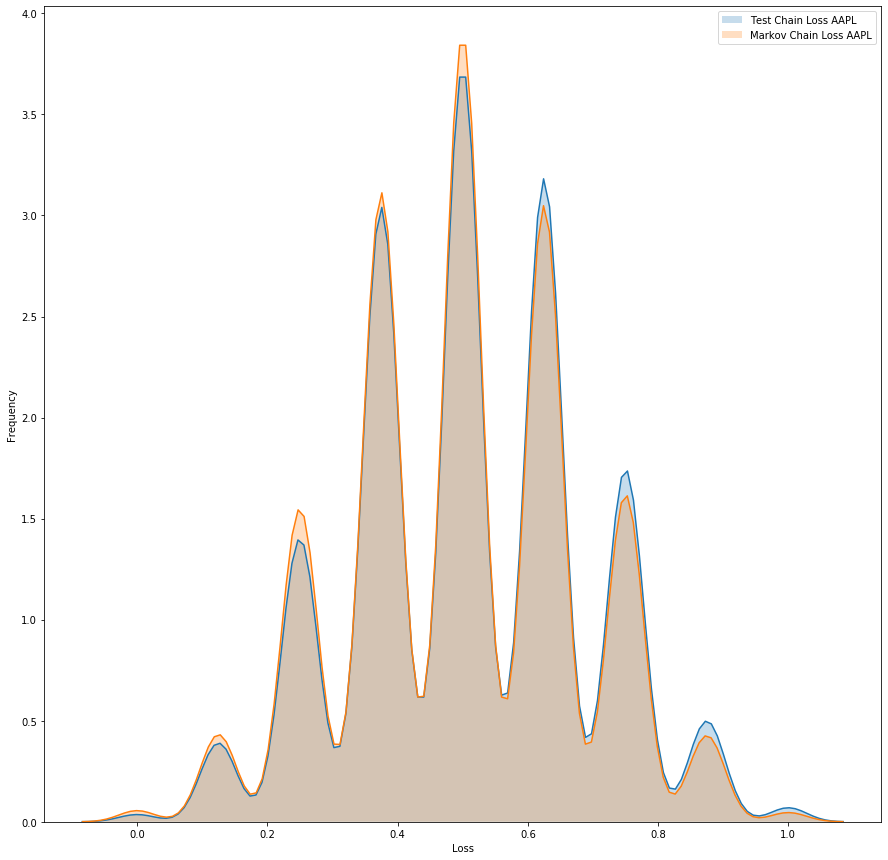

1.098901098901099% done!


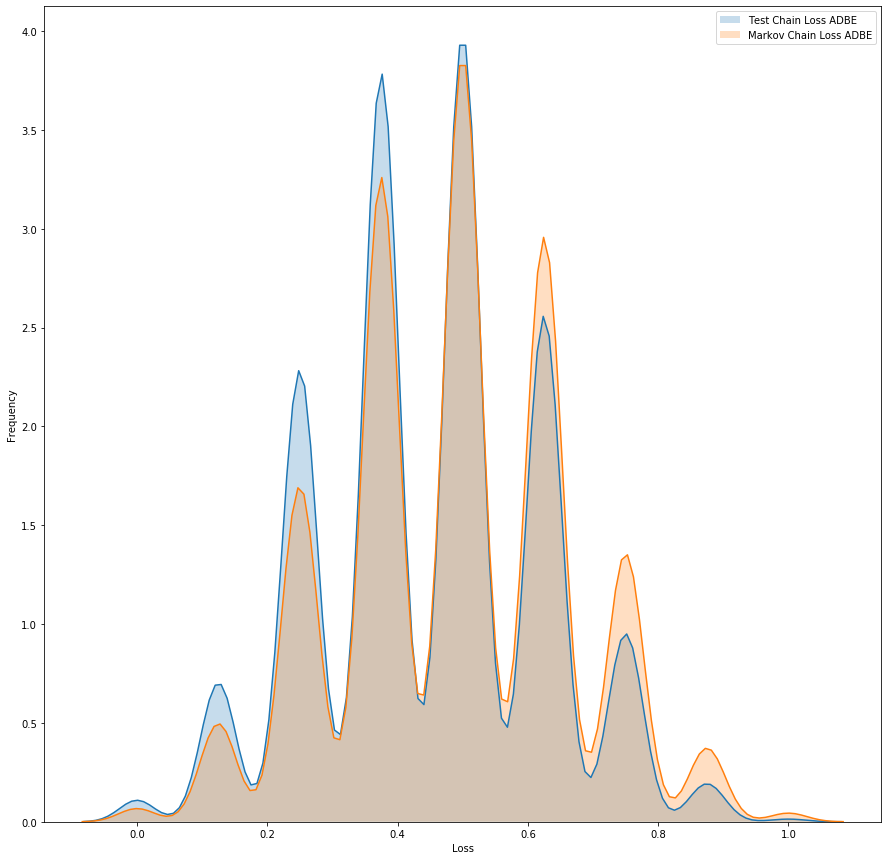

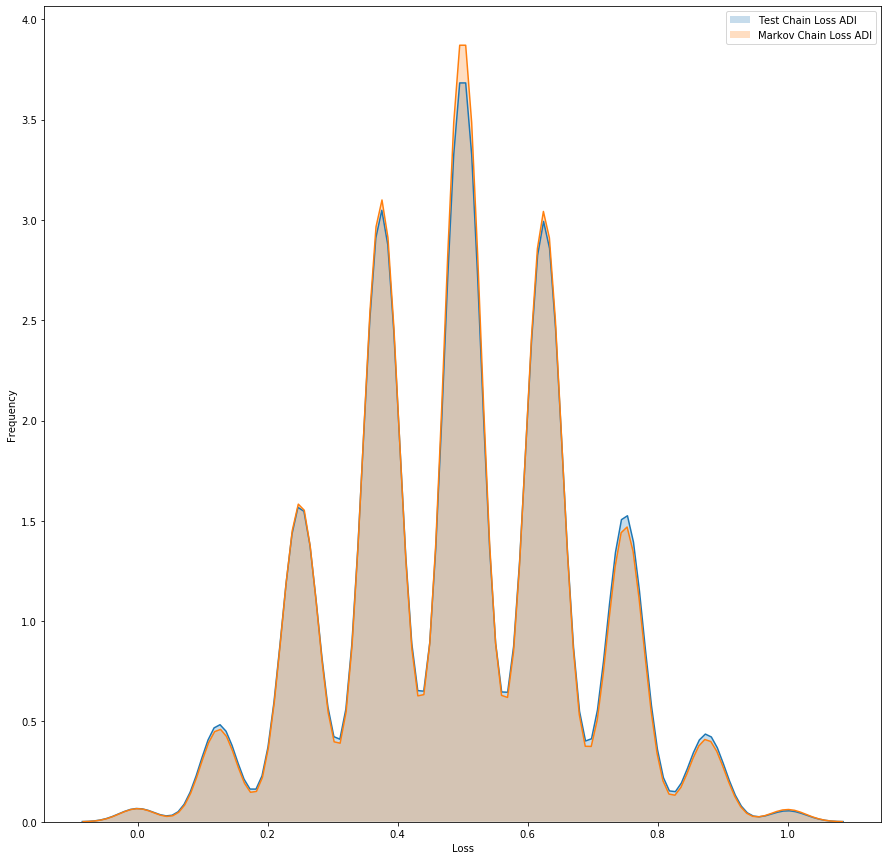

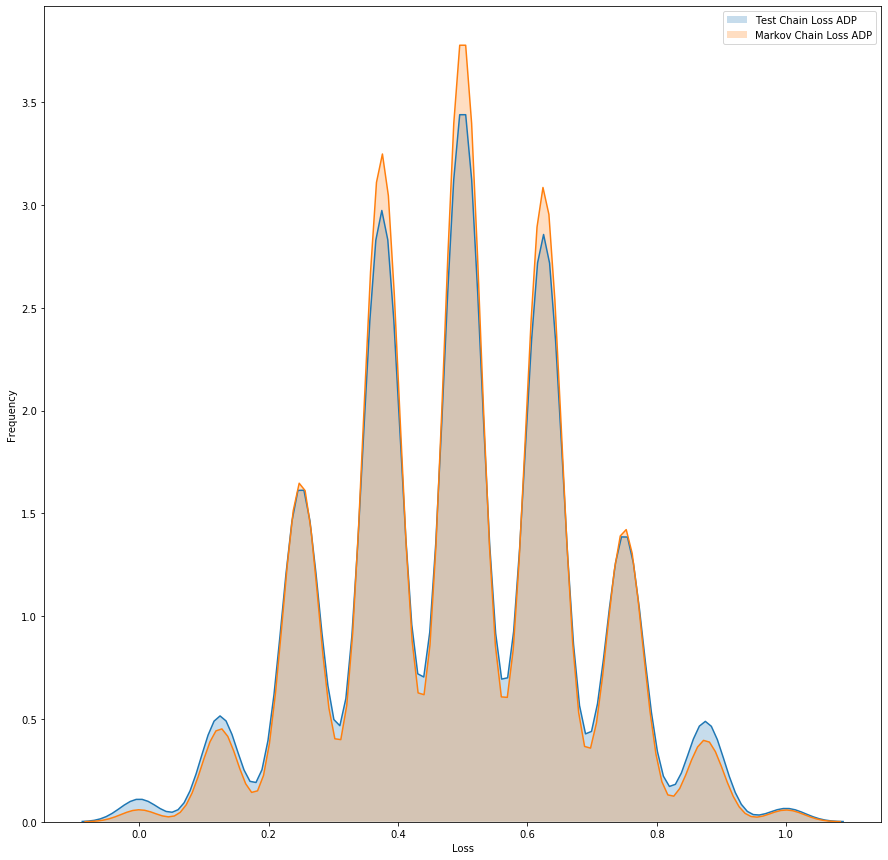

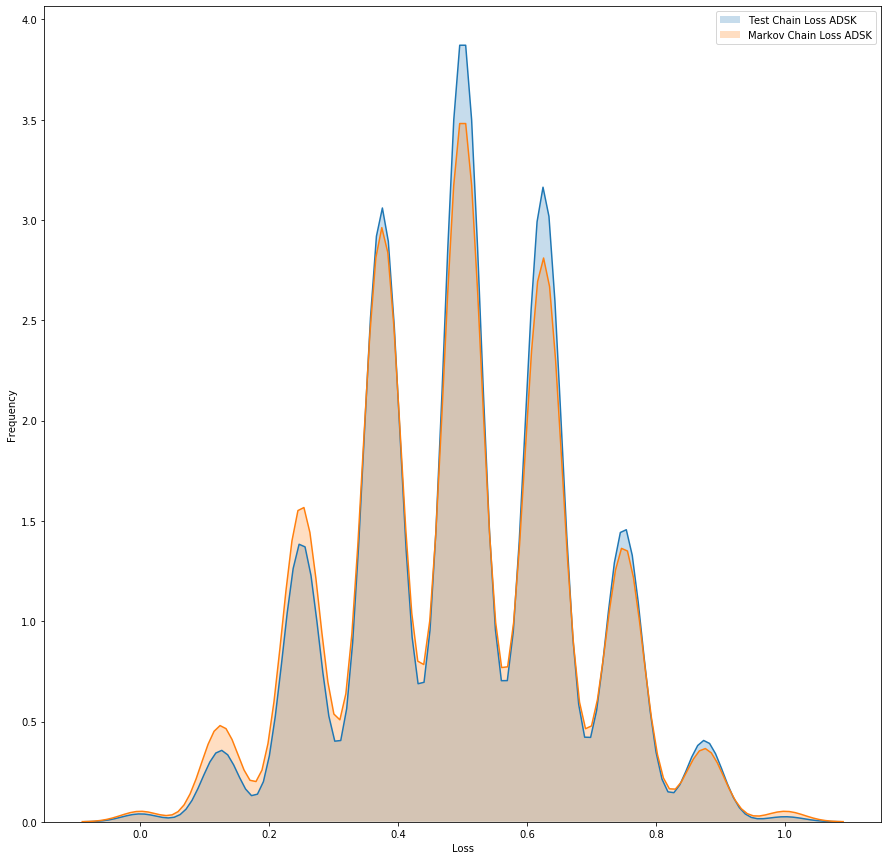

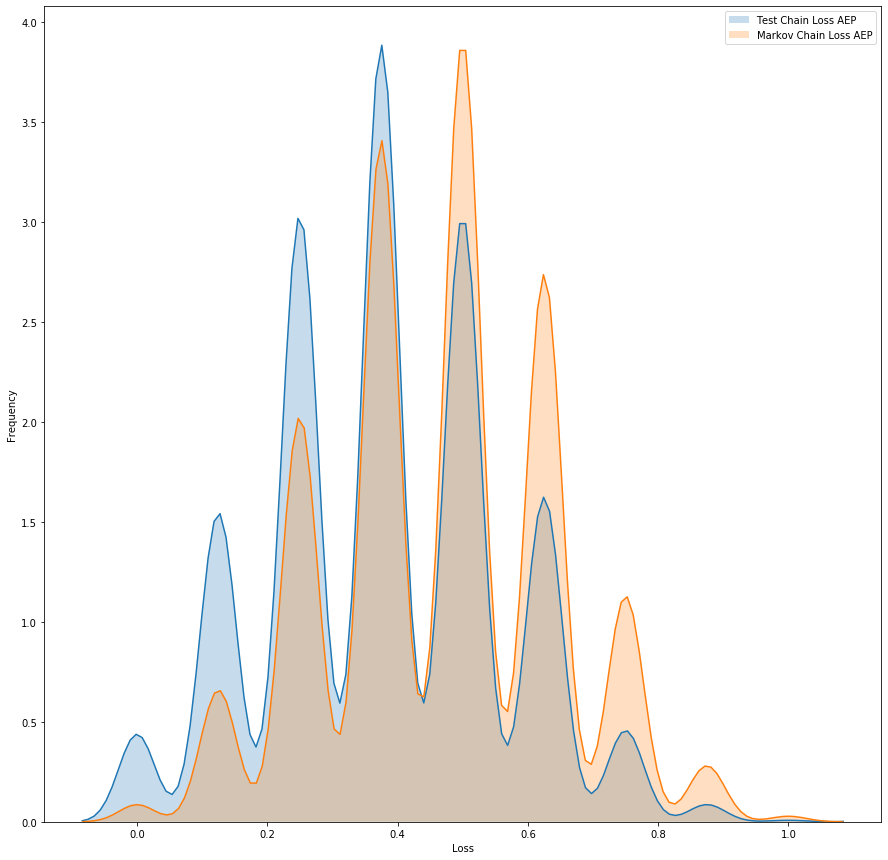

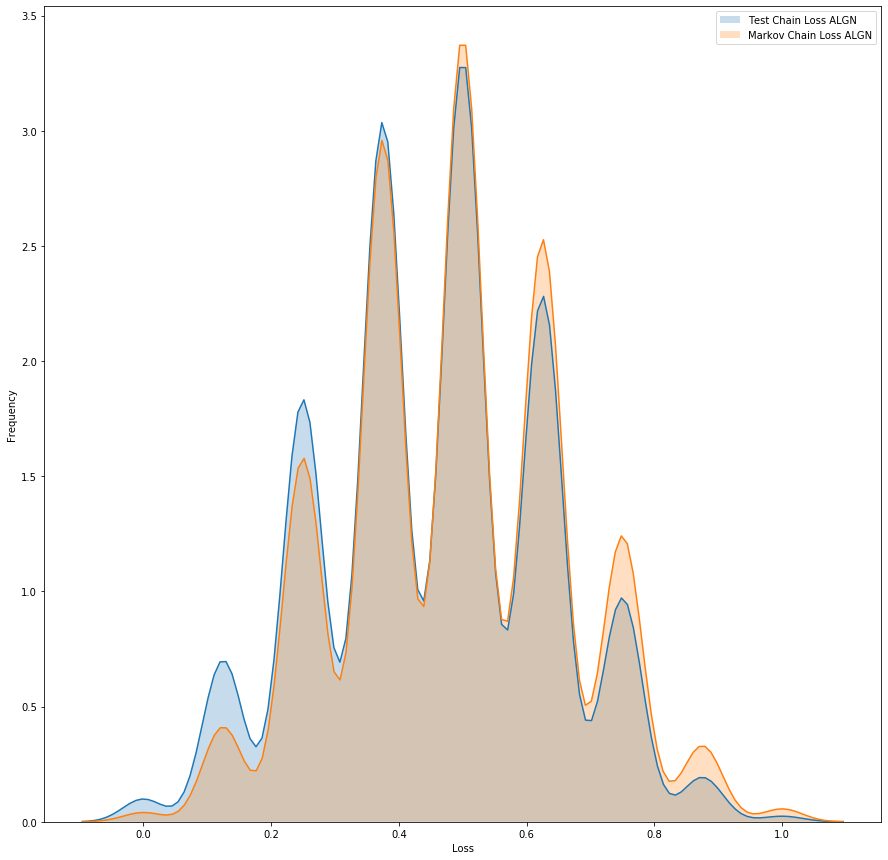

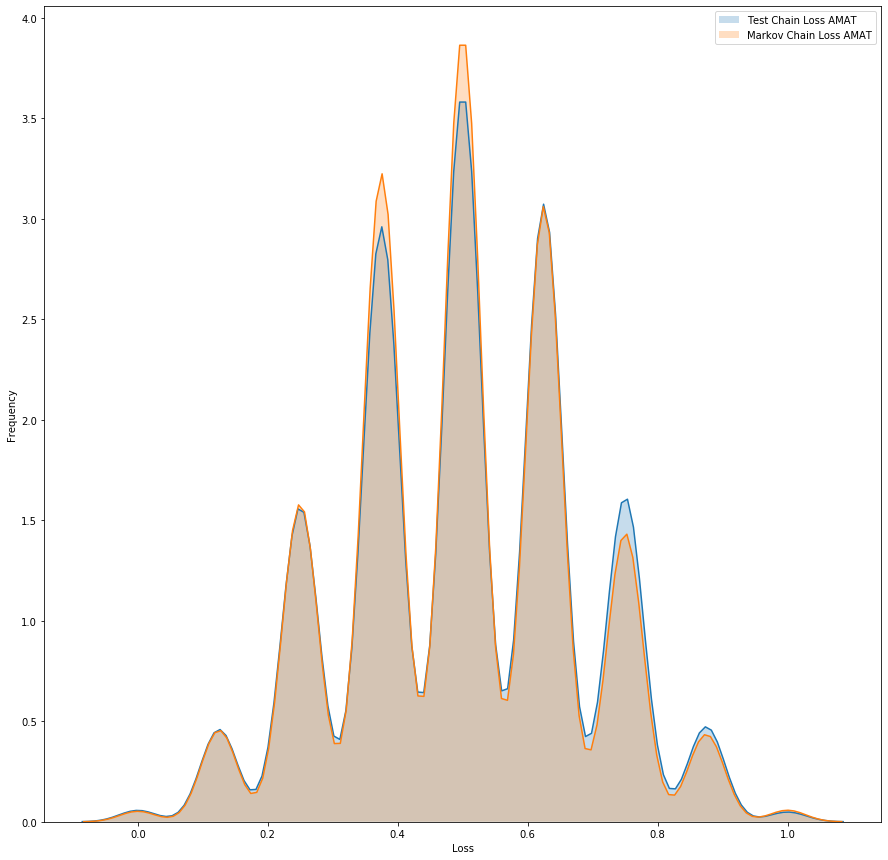

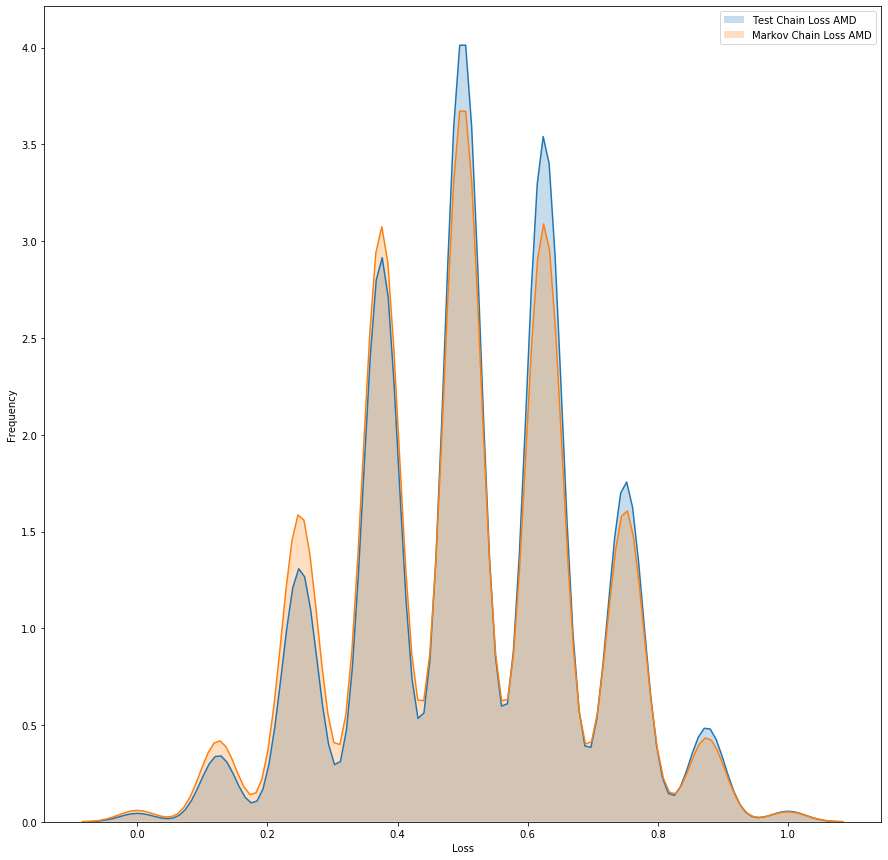

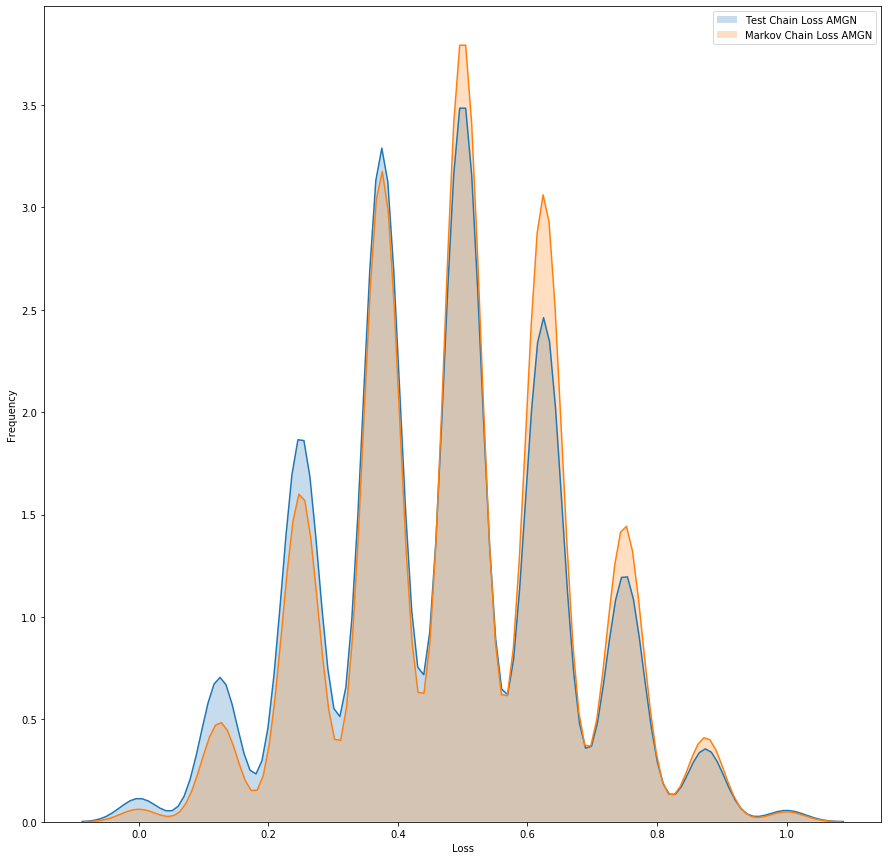

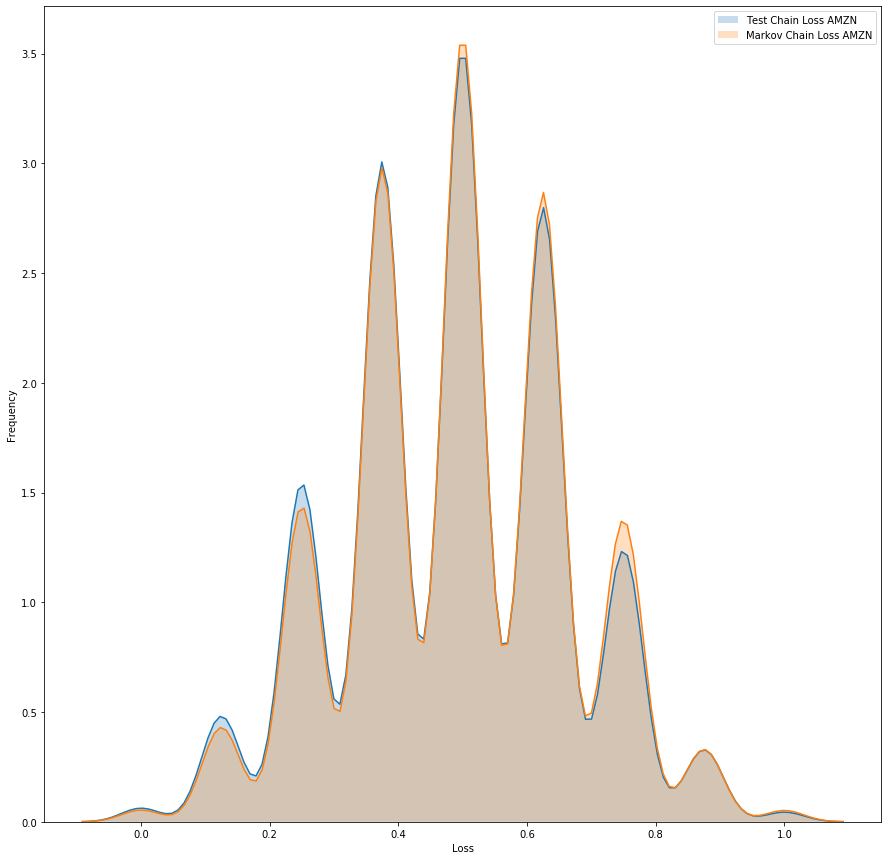

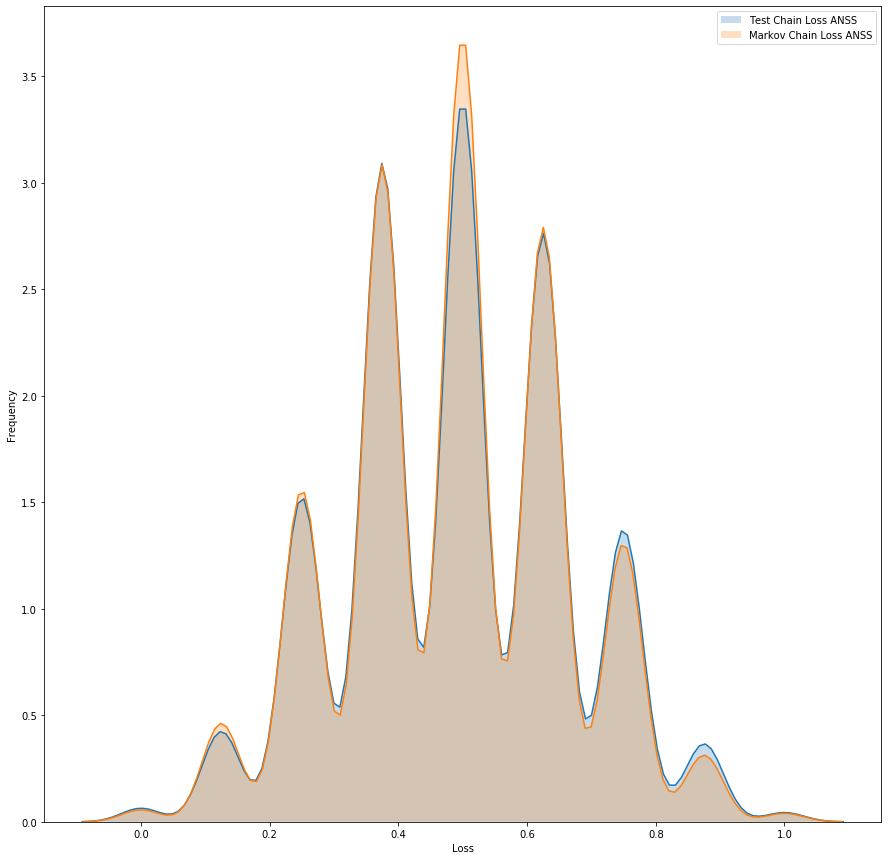

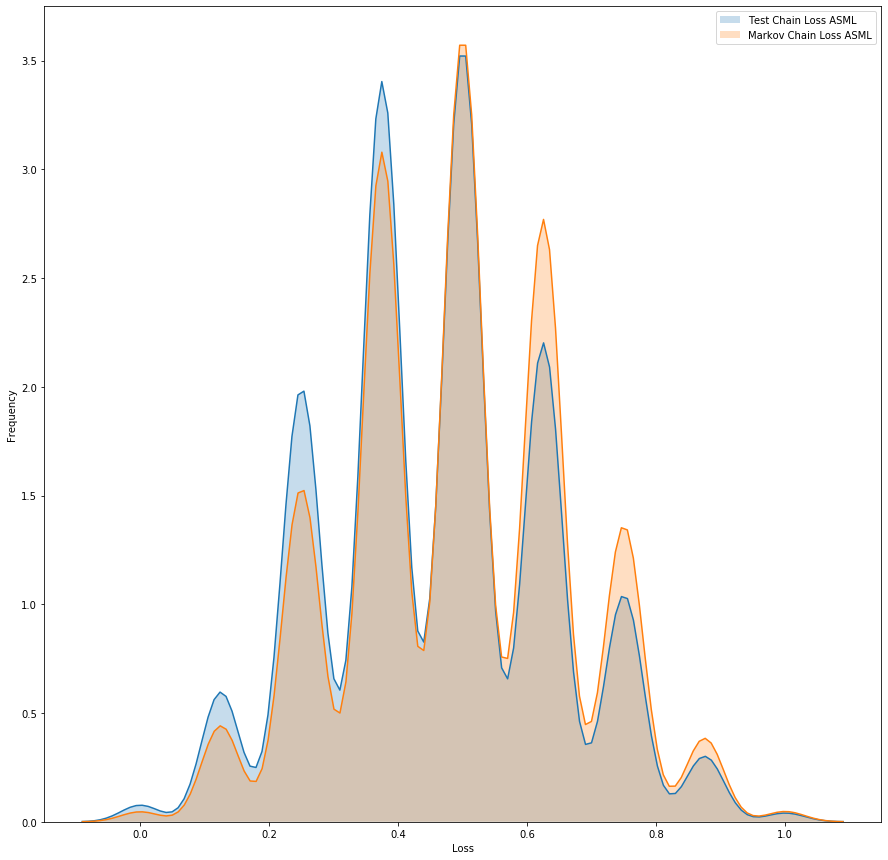

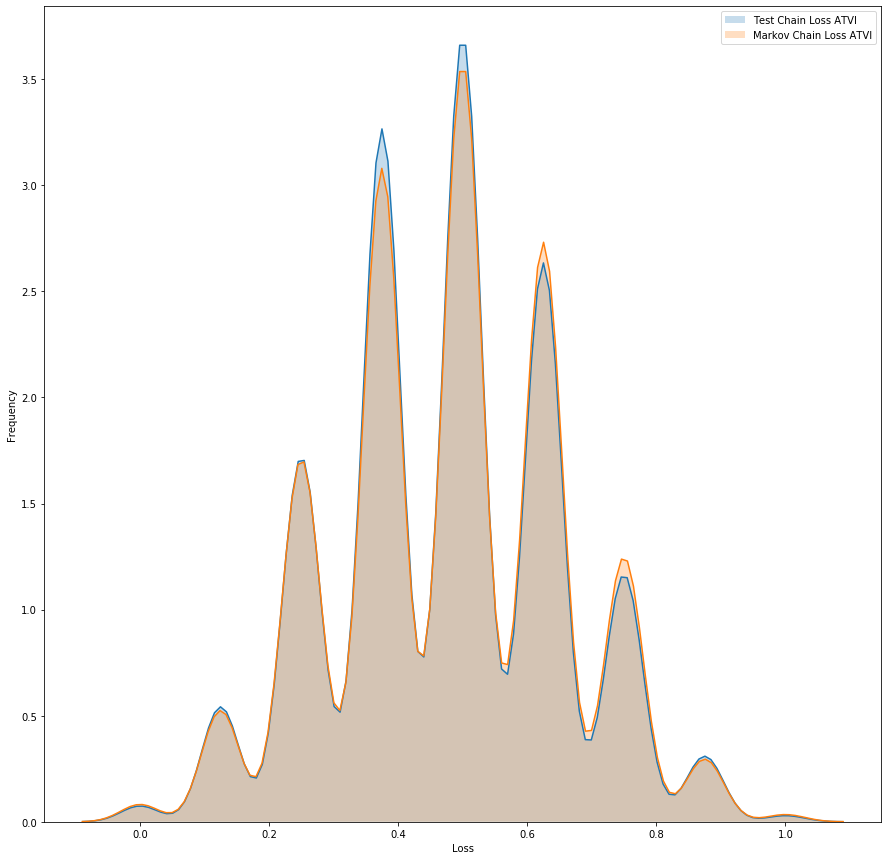

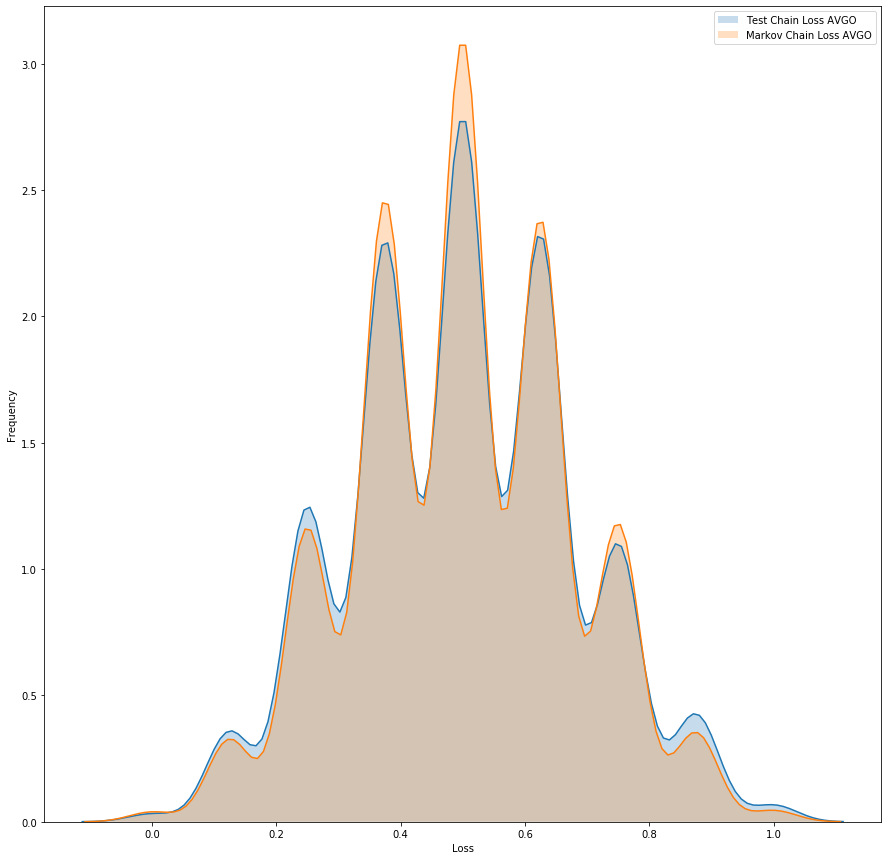

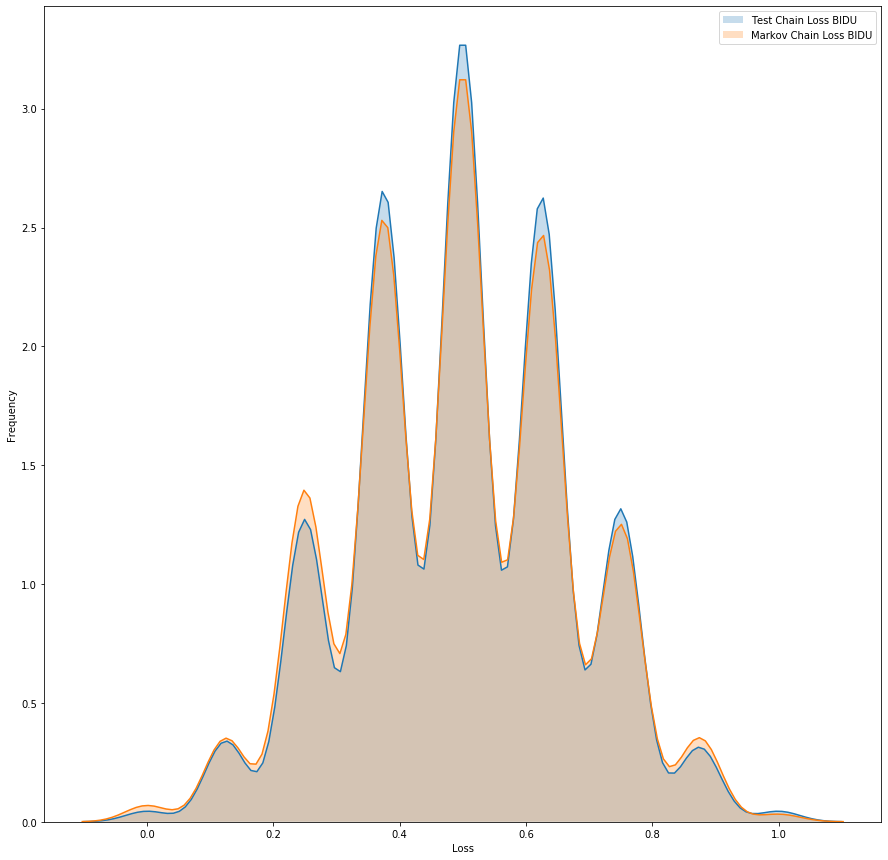

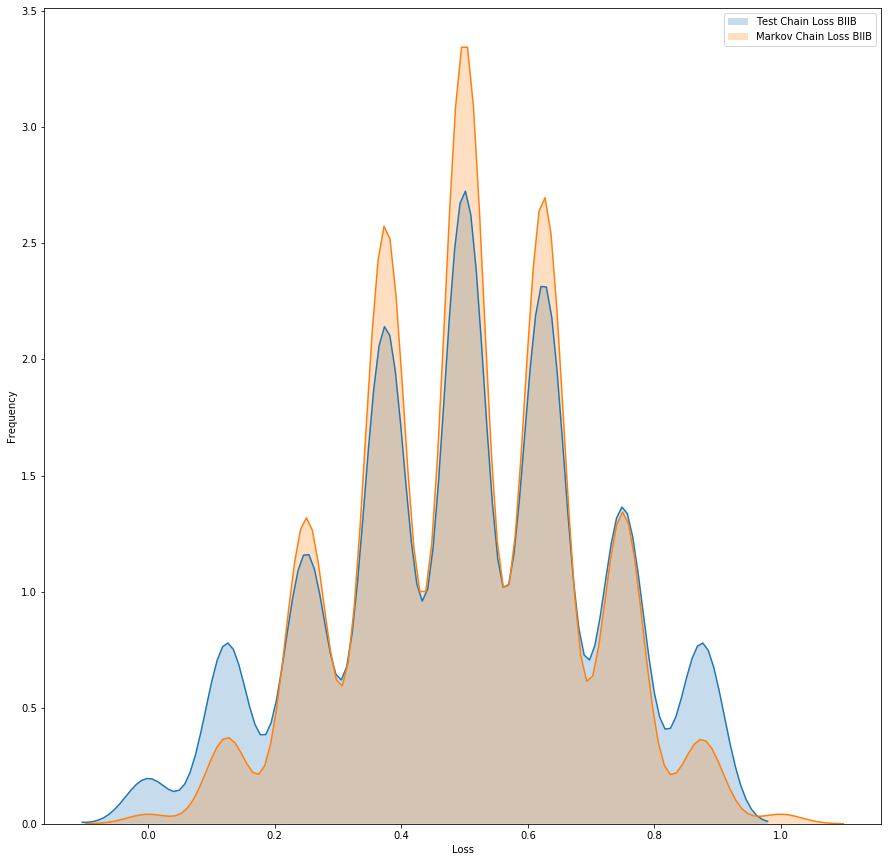

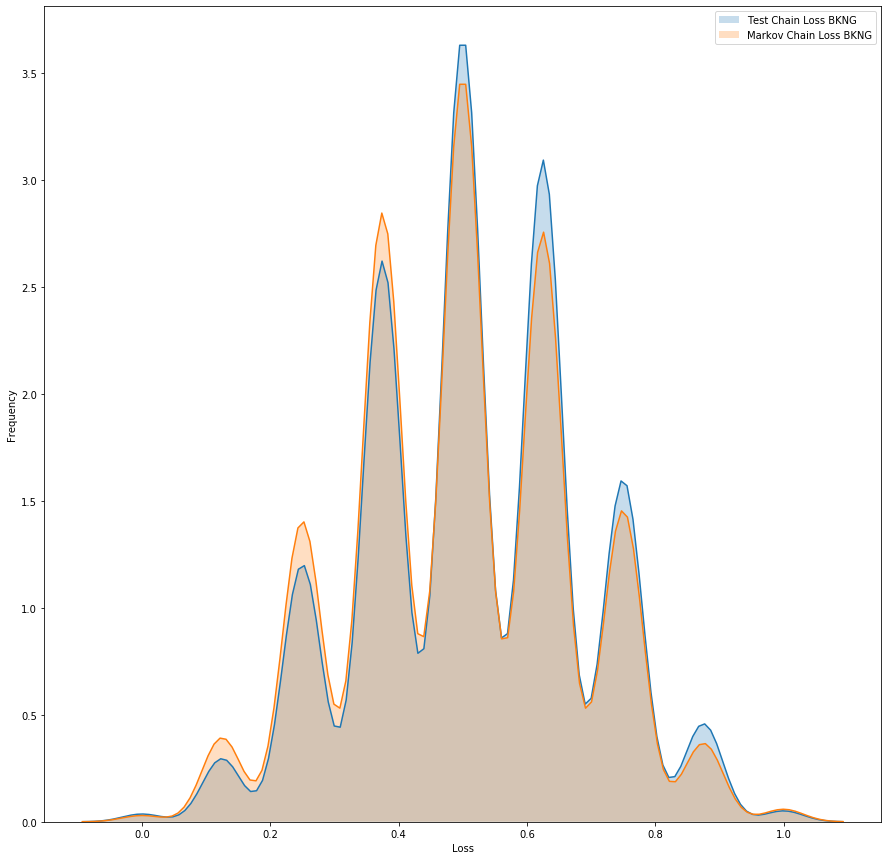

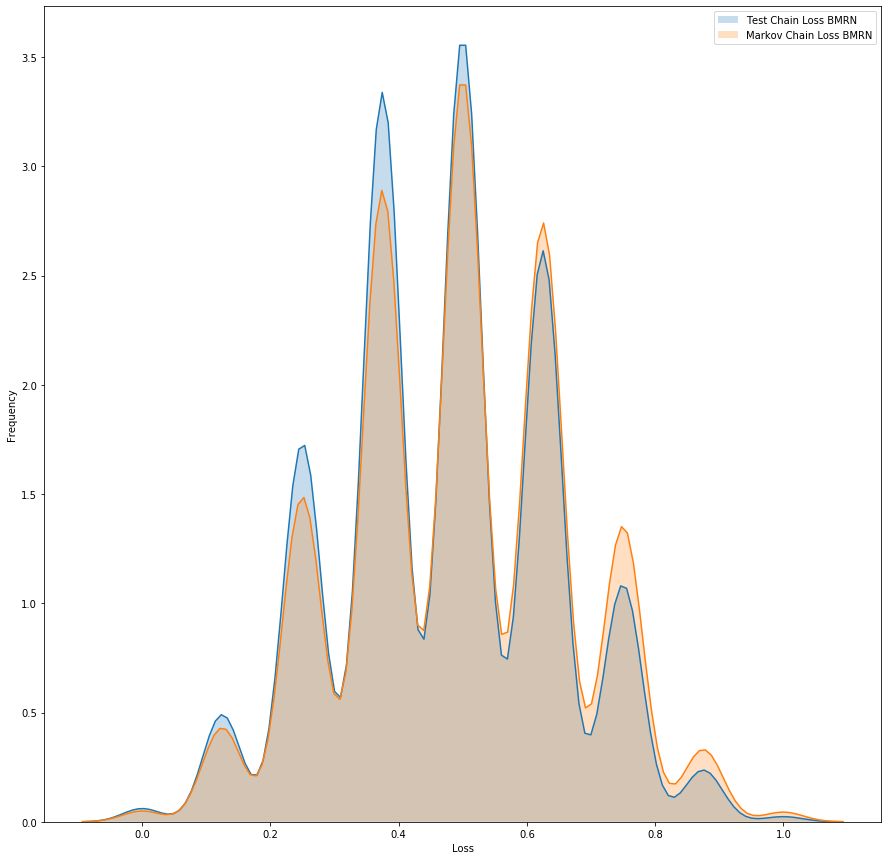

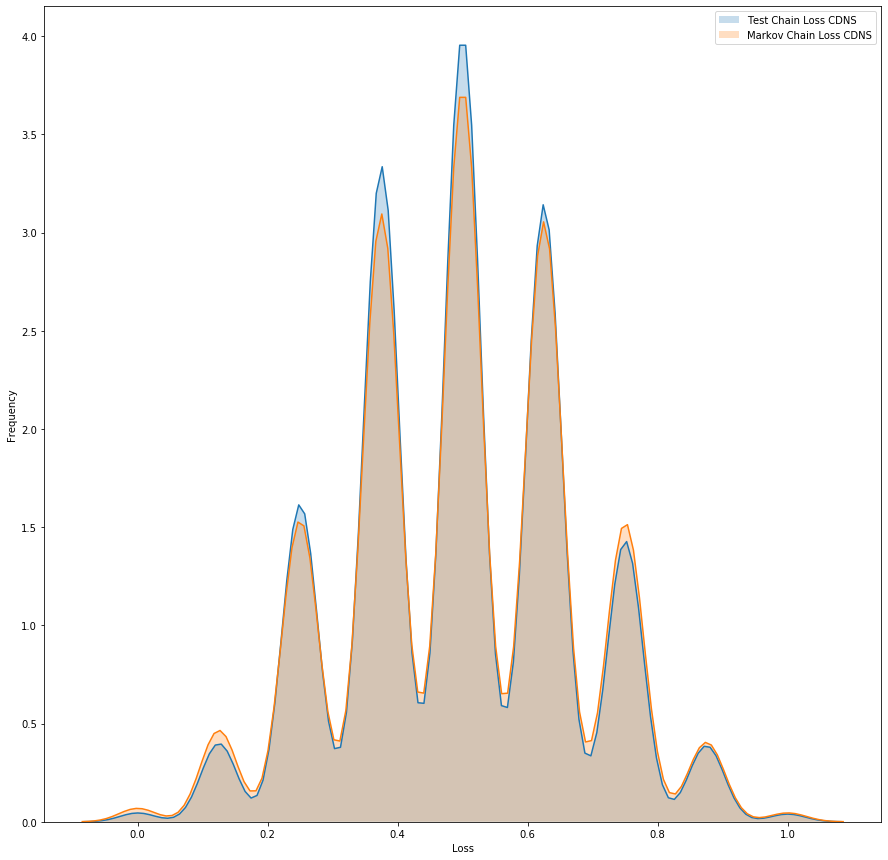

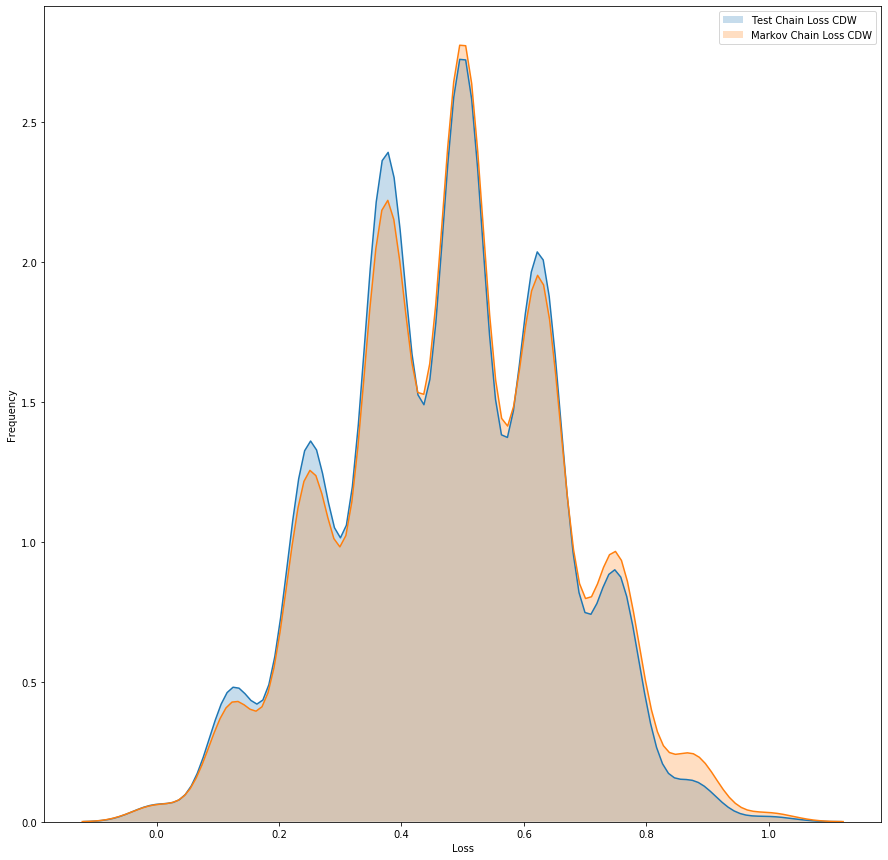

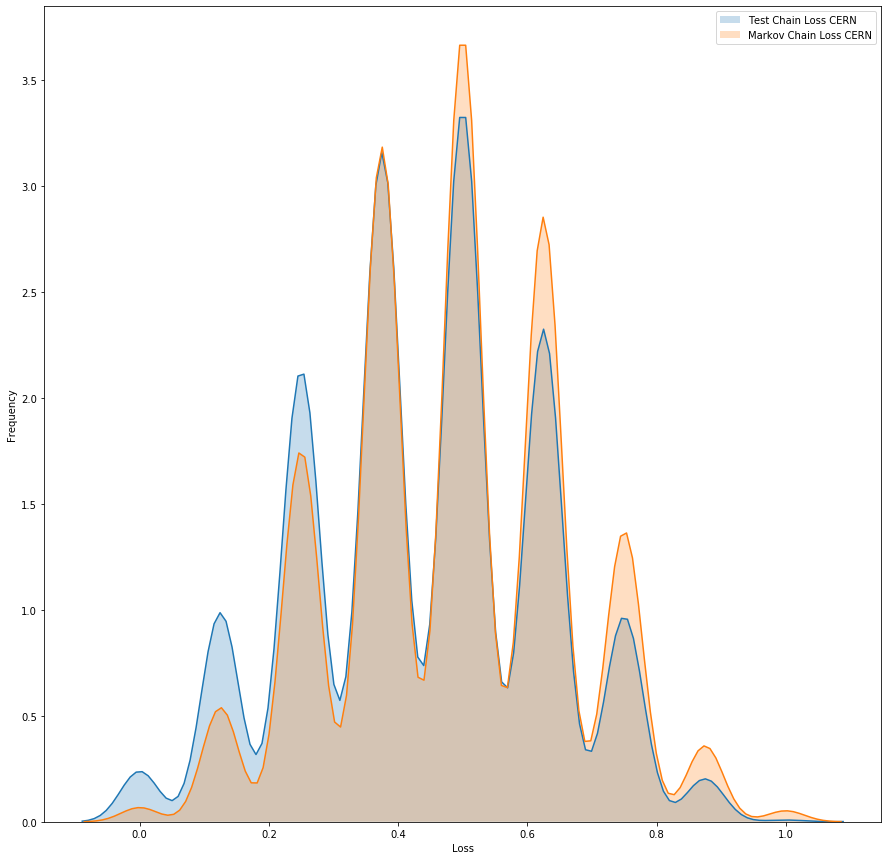

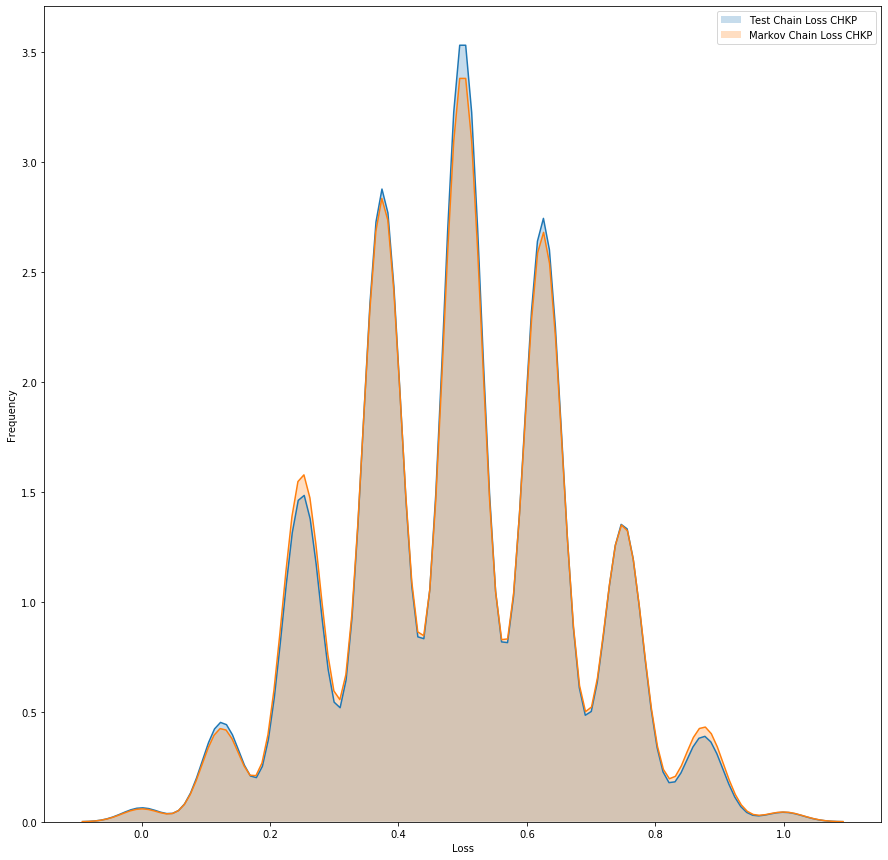

25.274725274725274% done!


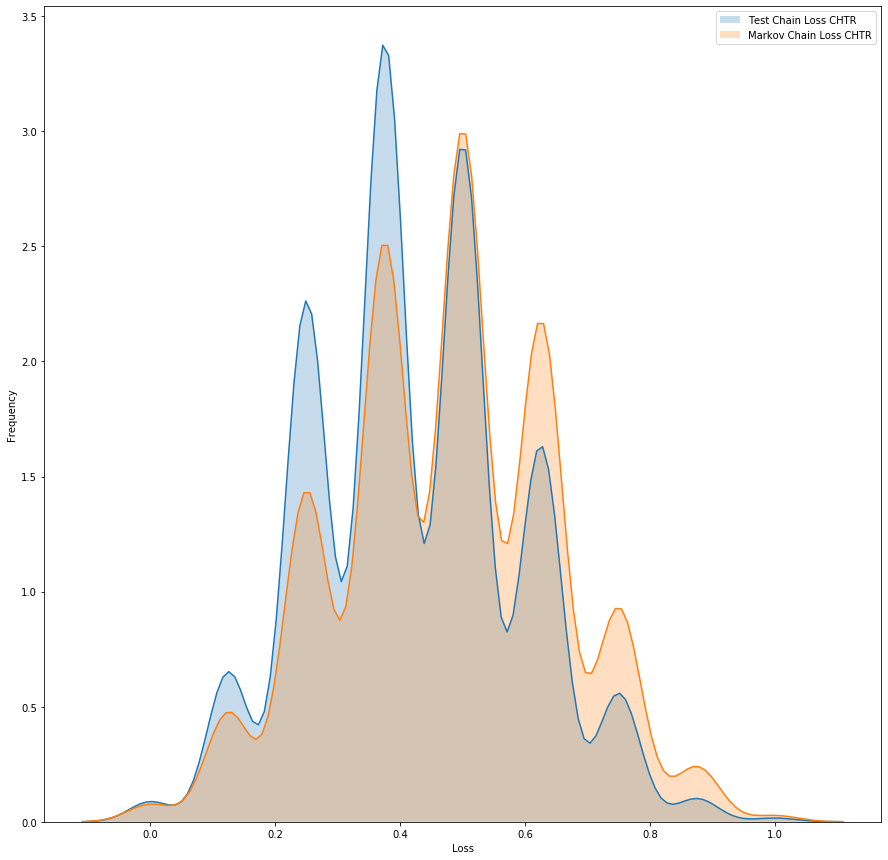

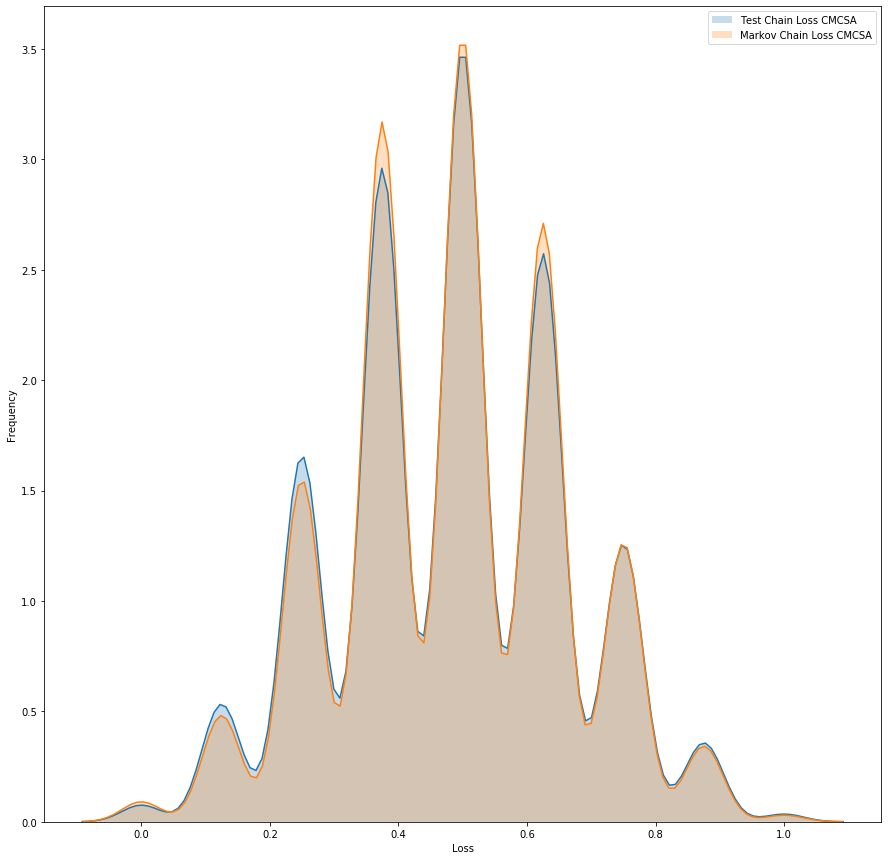

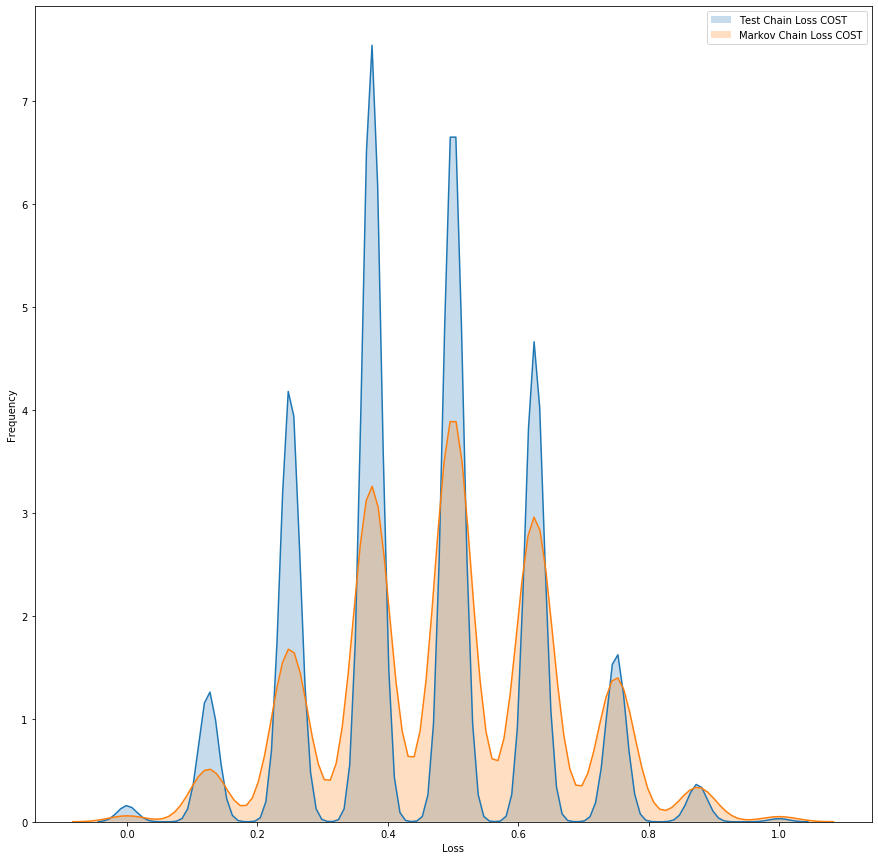

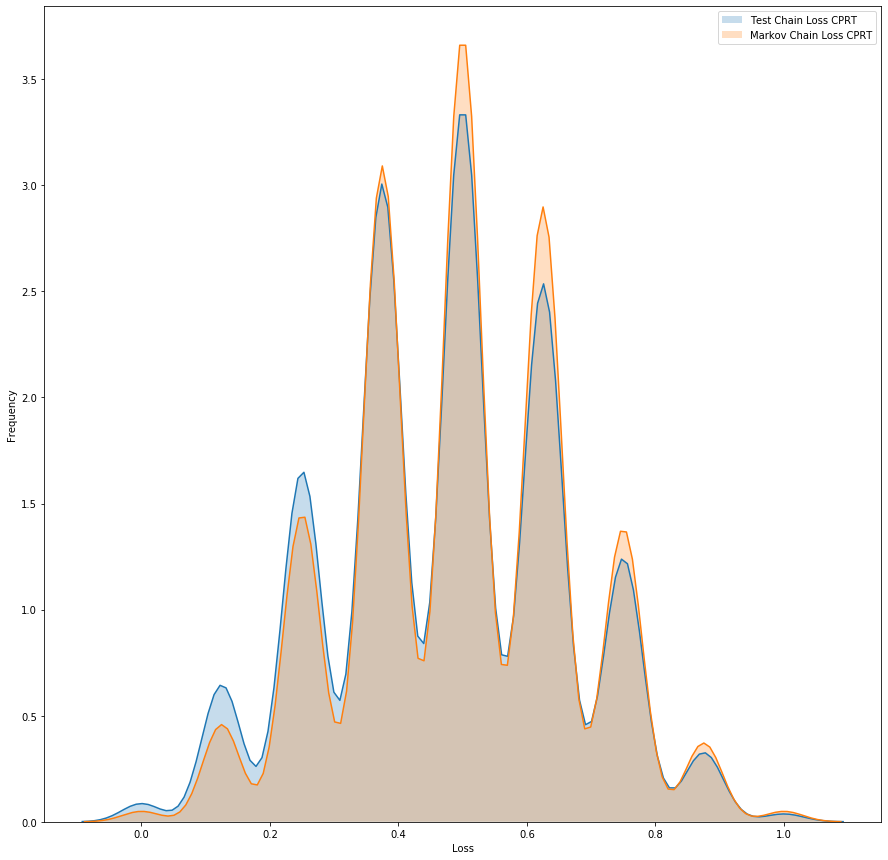

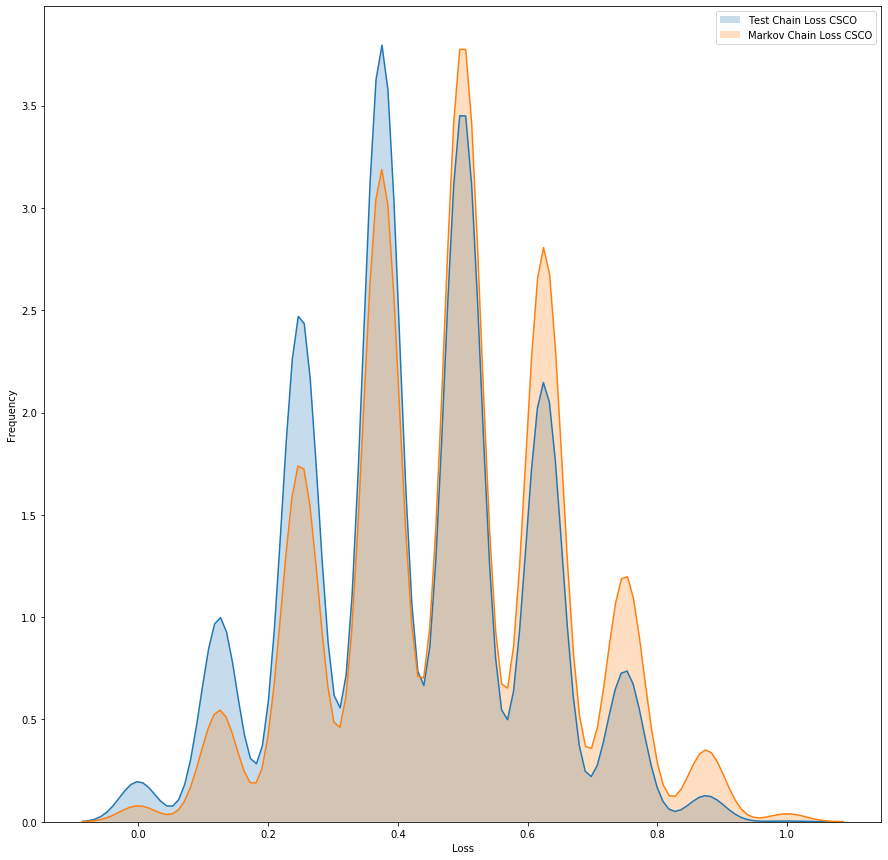

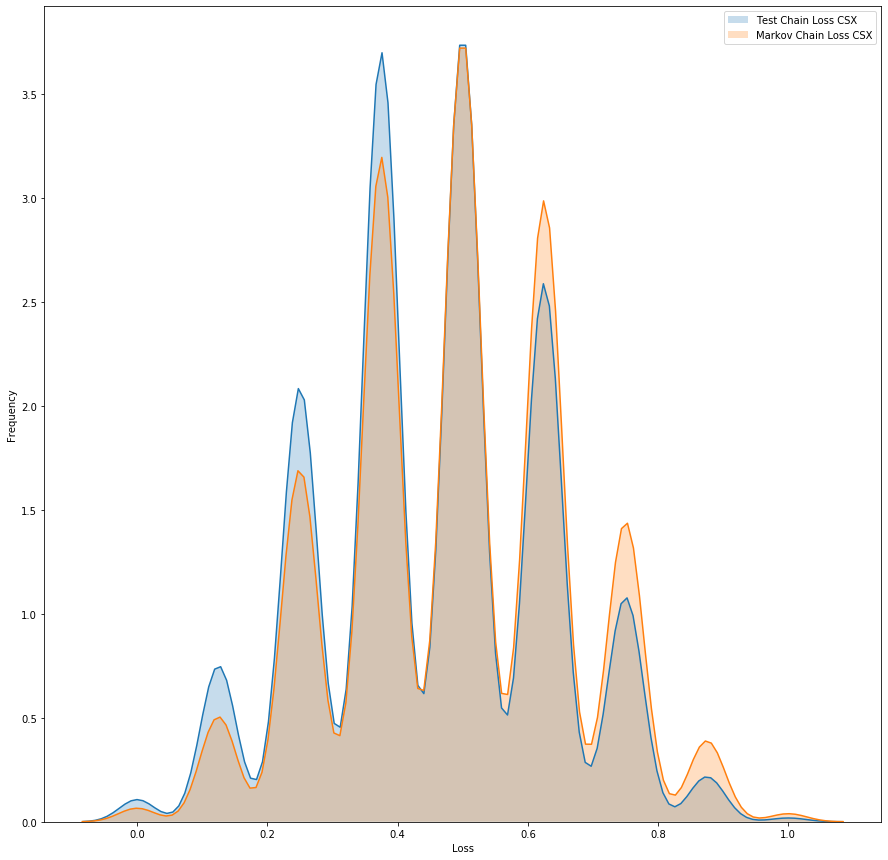

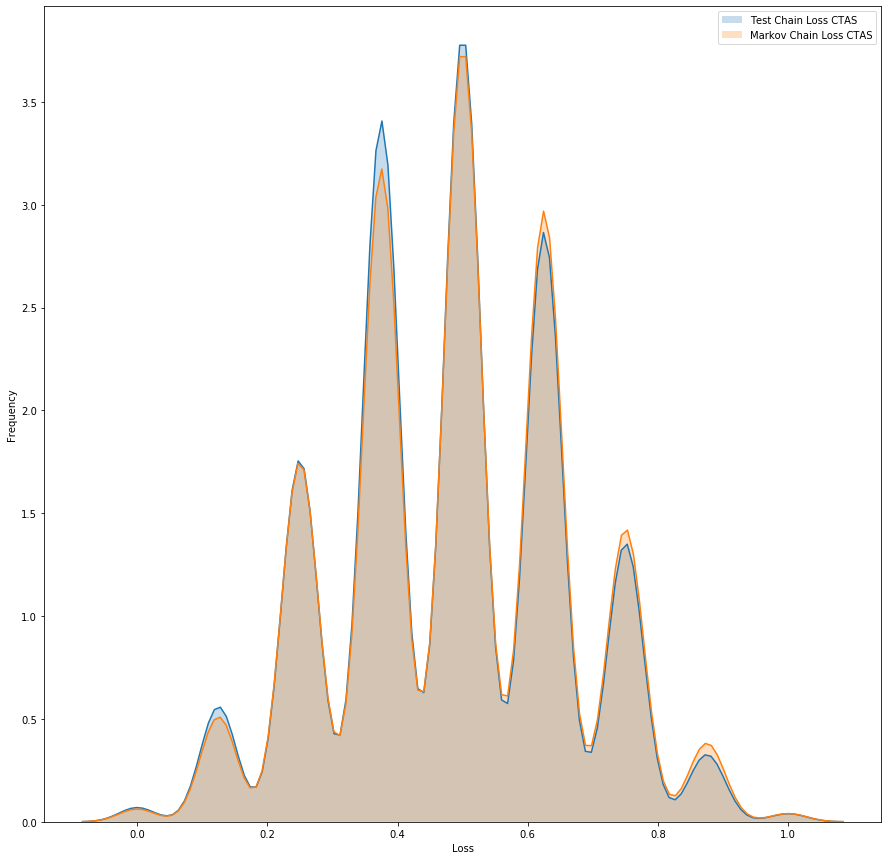

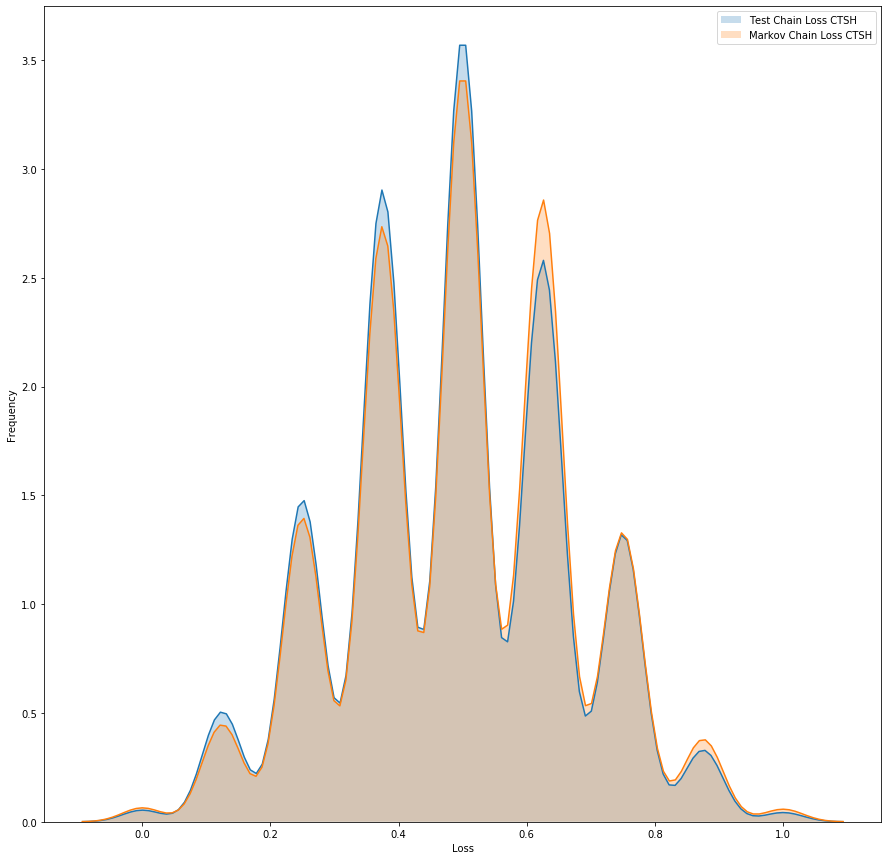

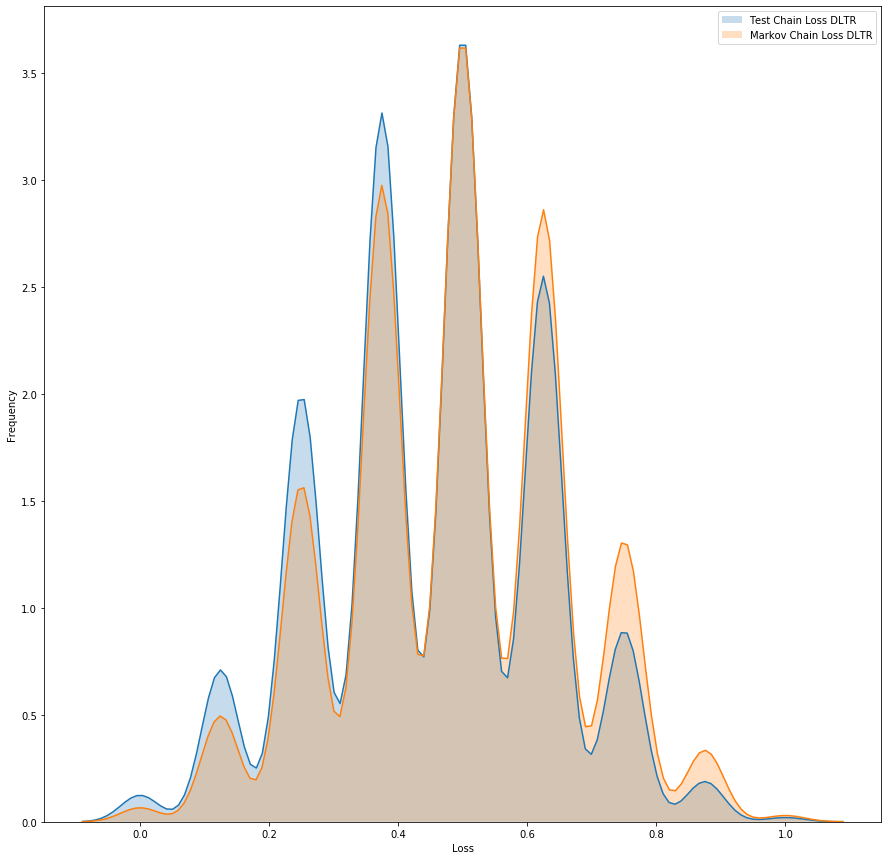

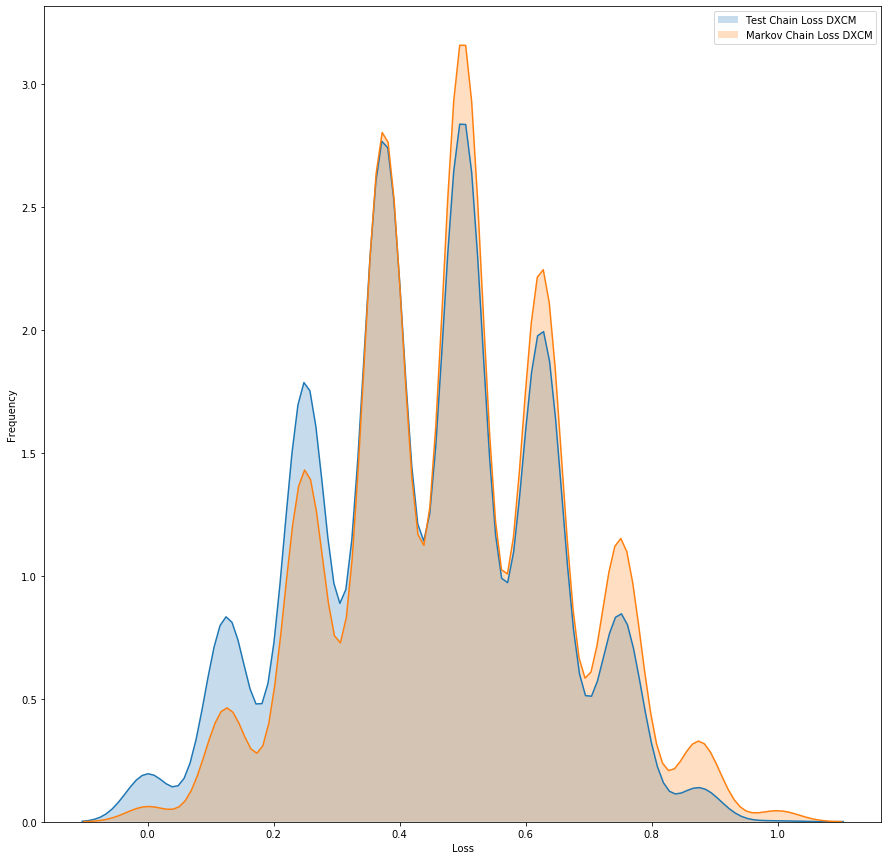

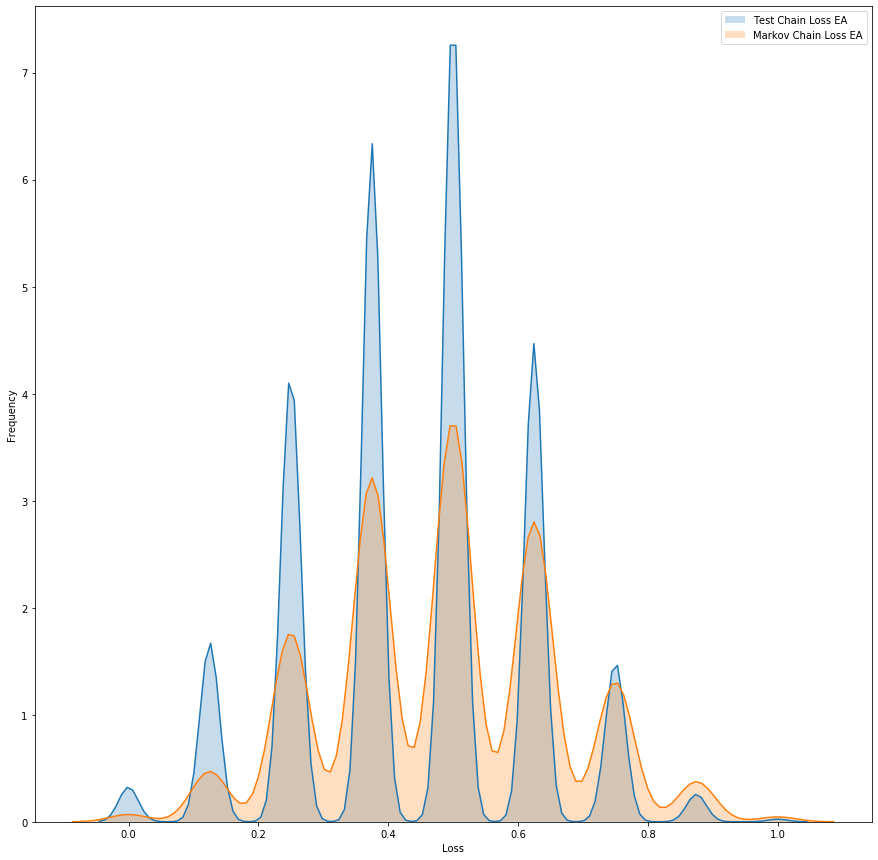

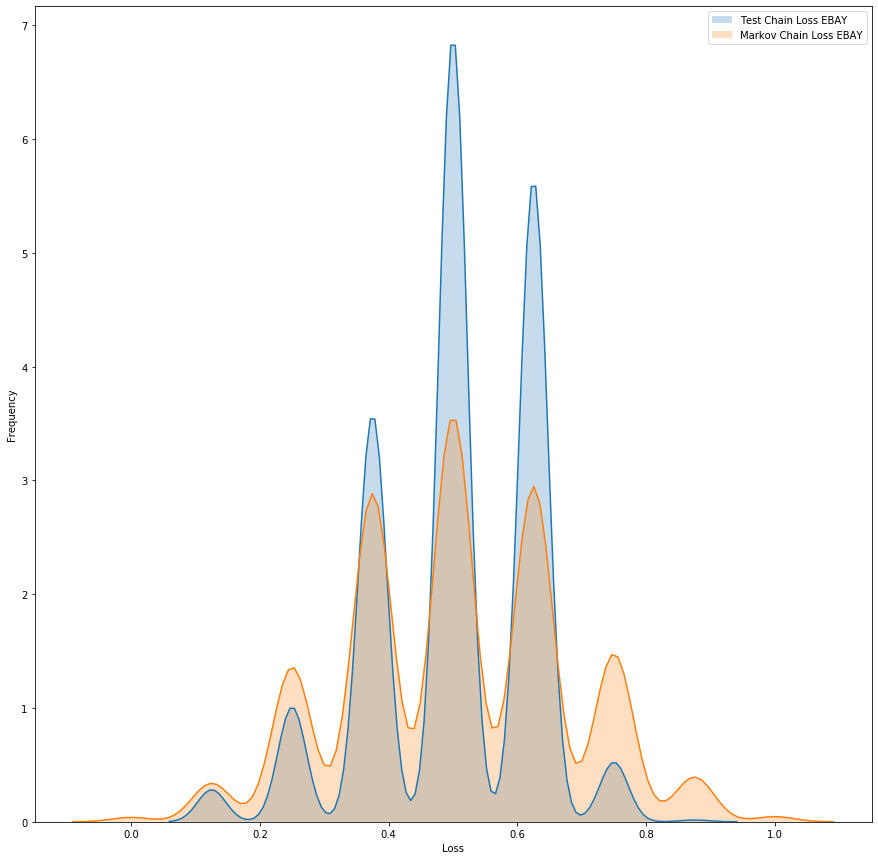

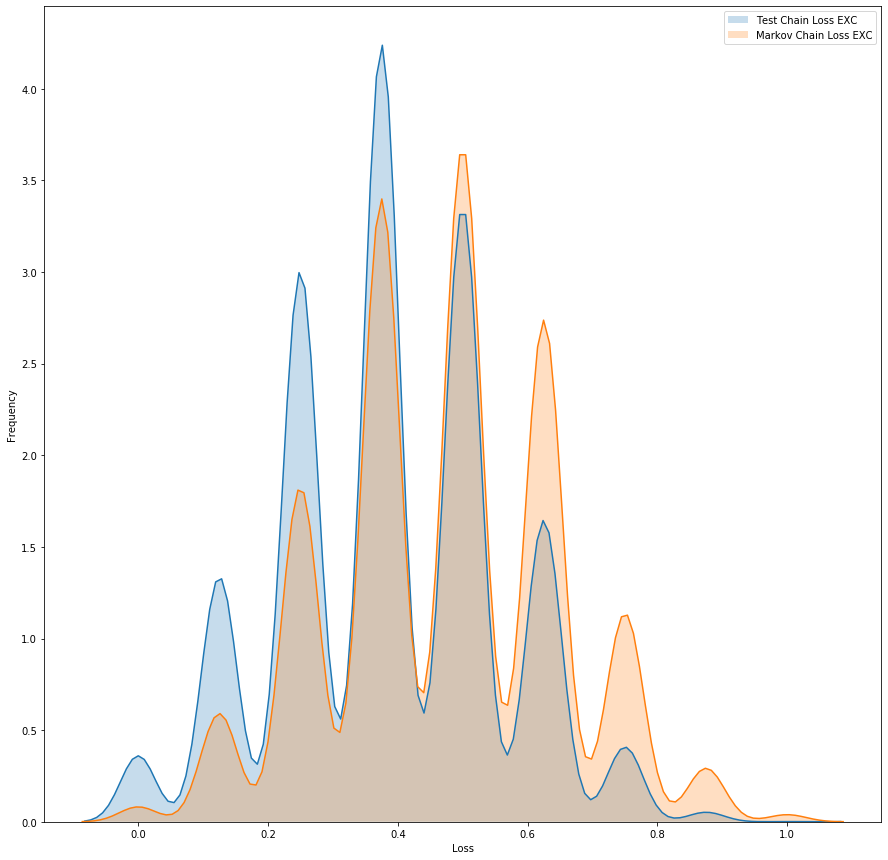

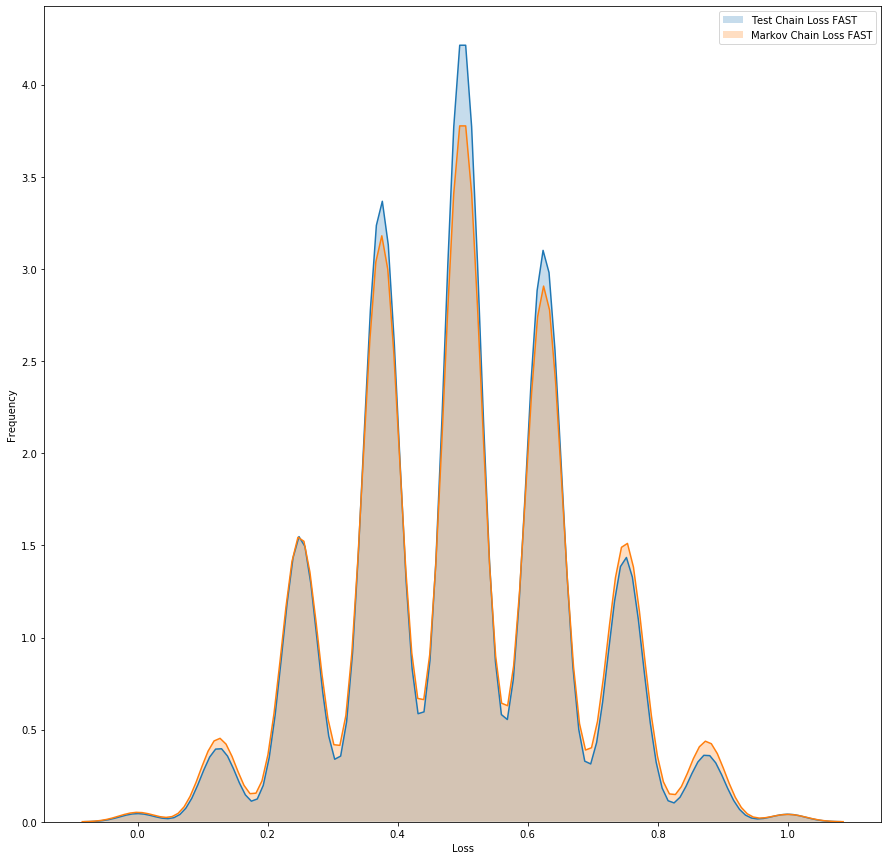

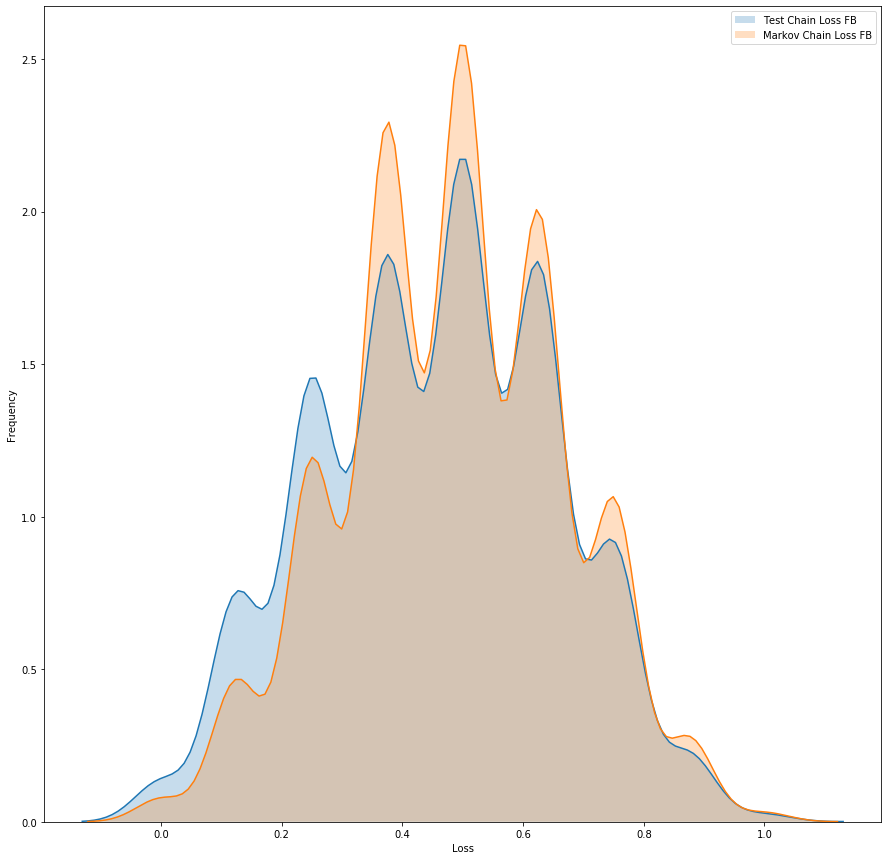

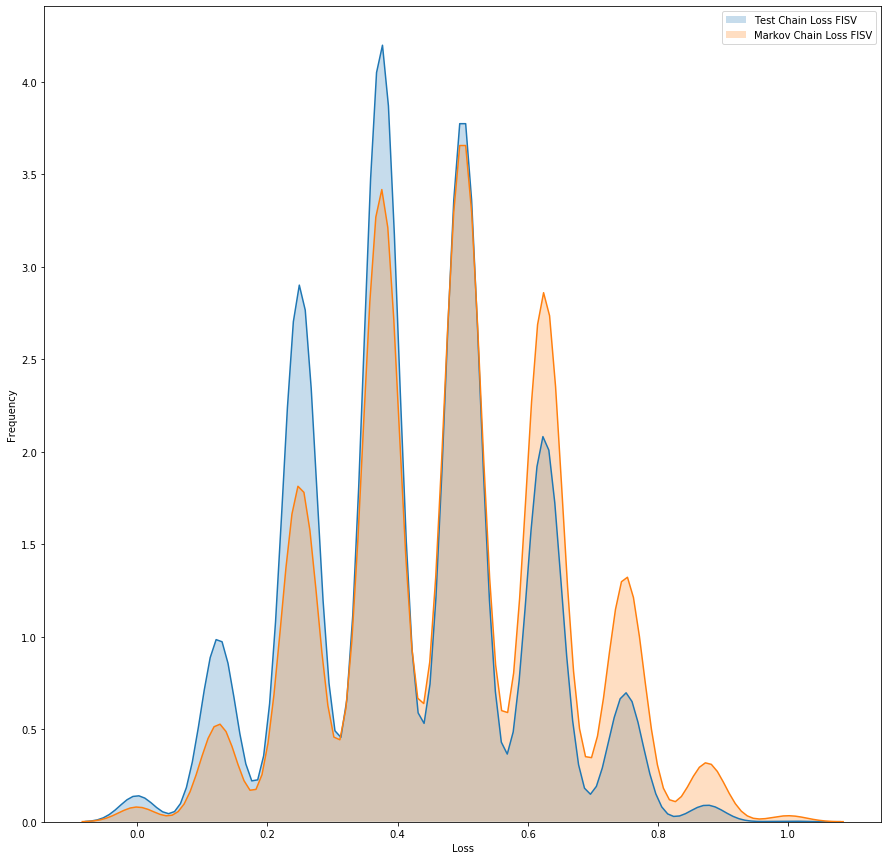

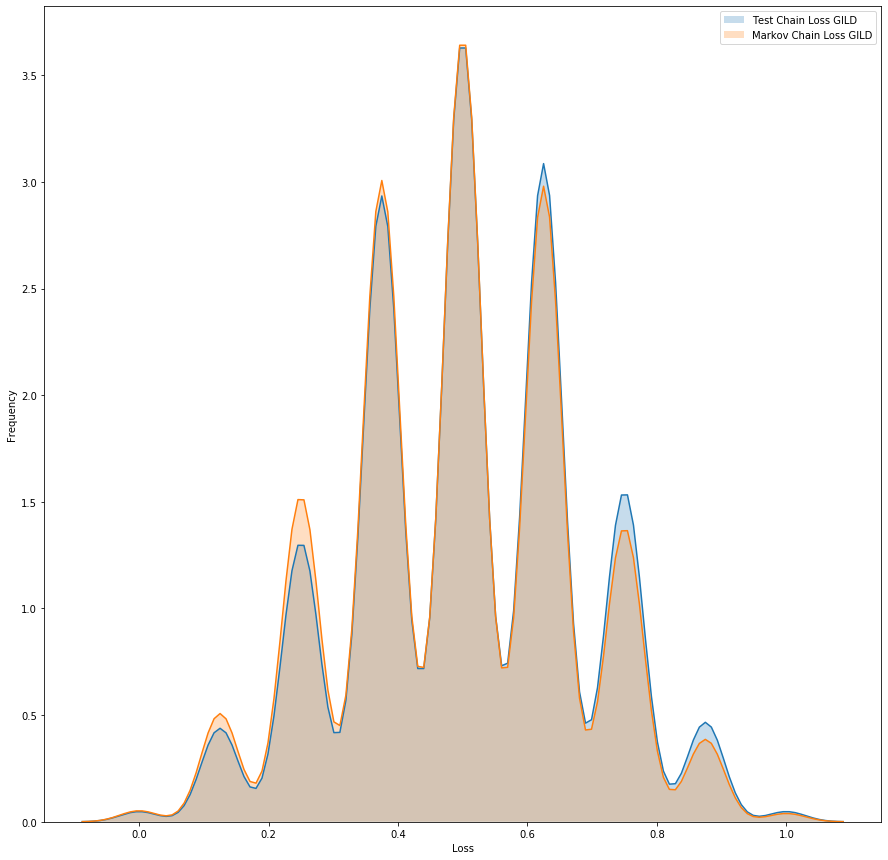

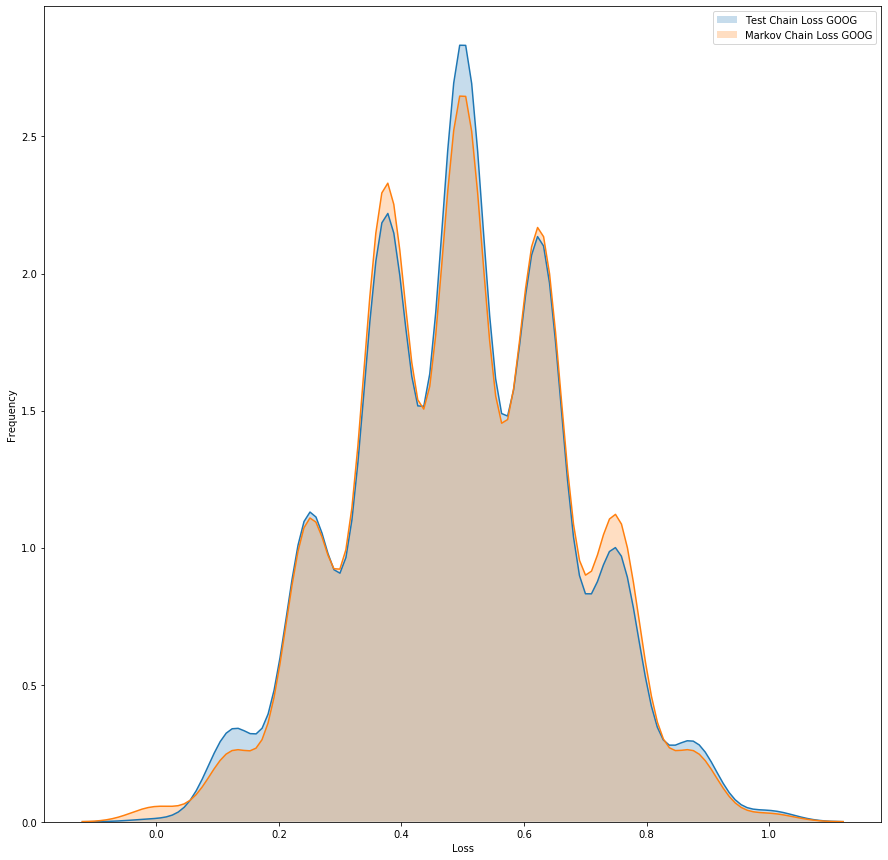

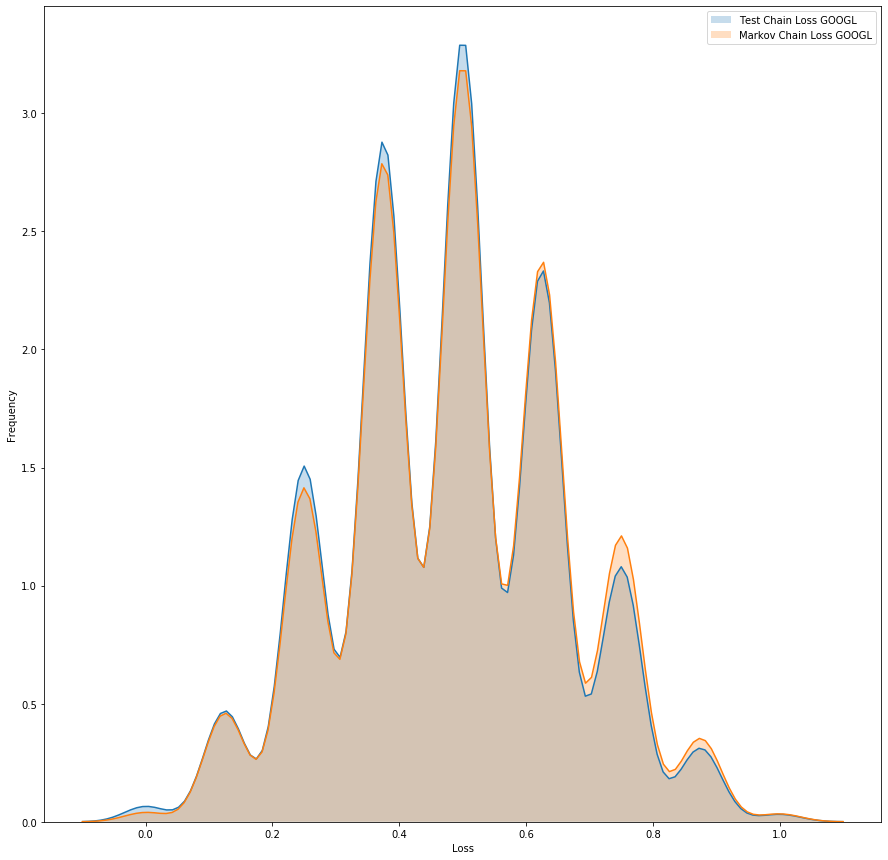

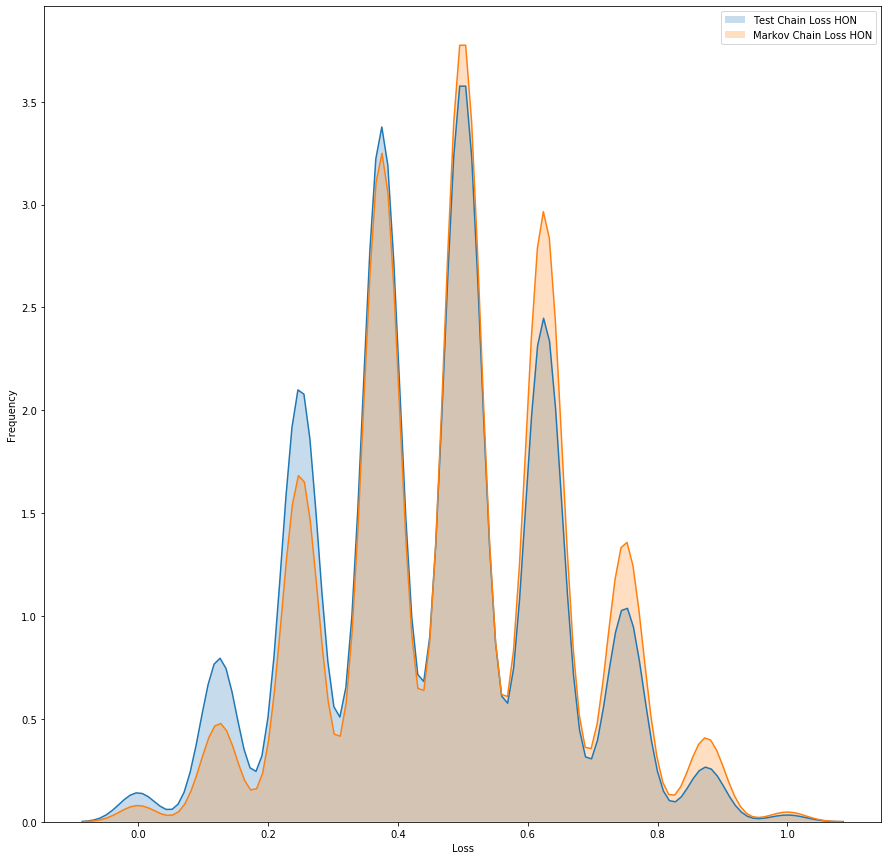

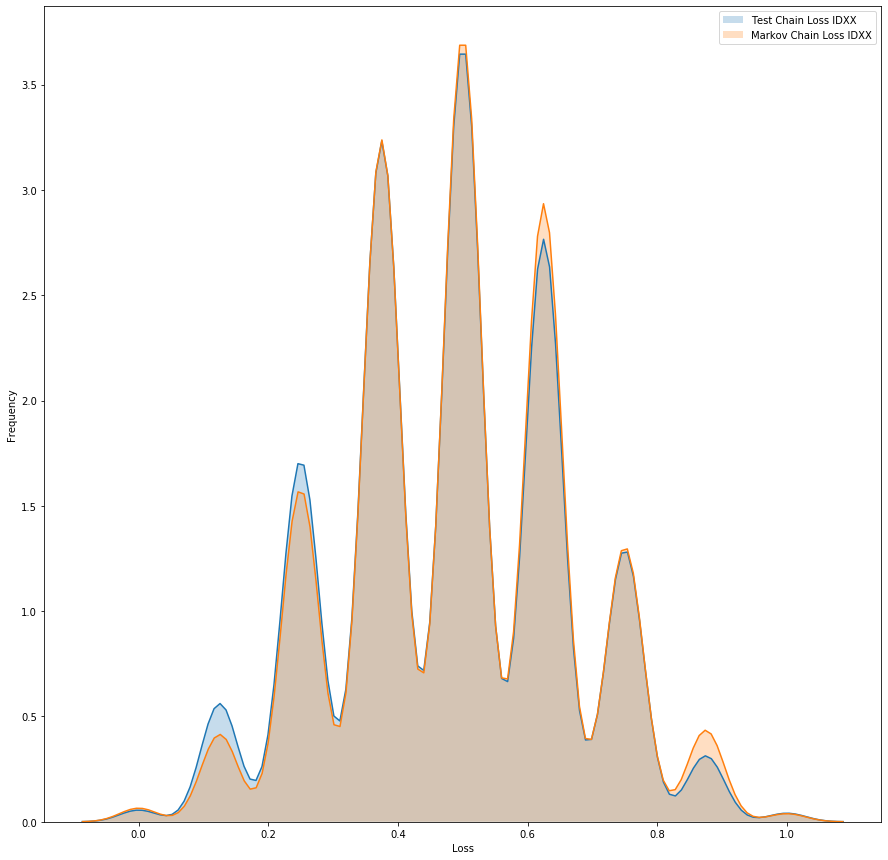

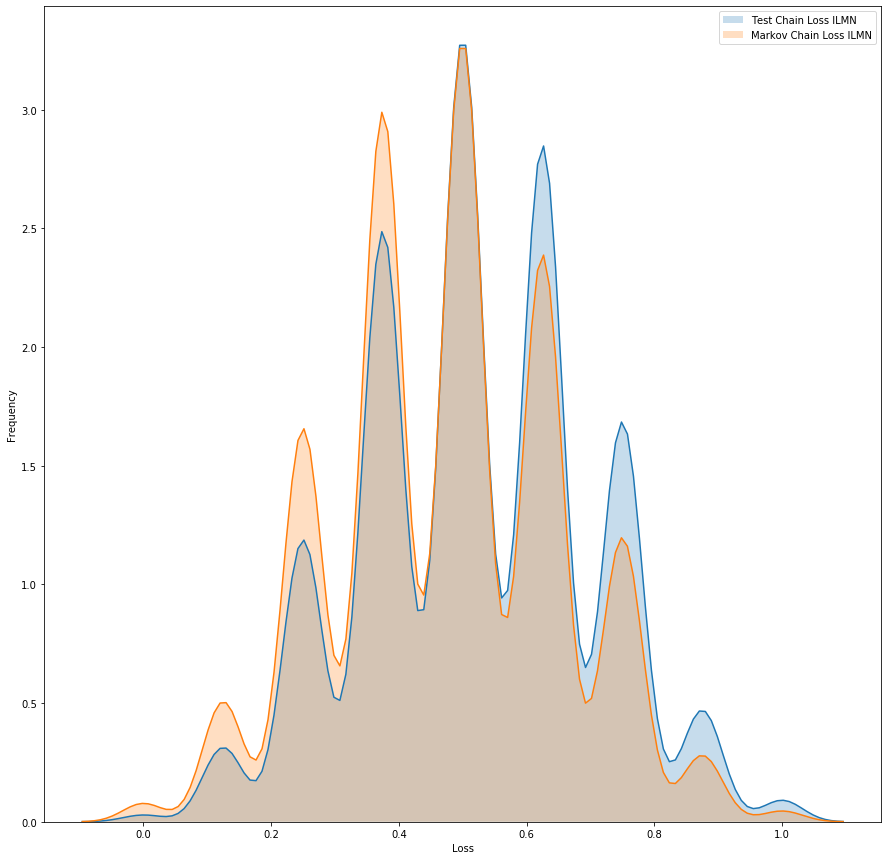

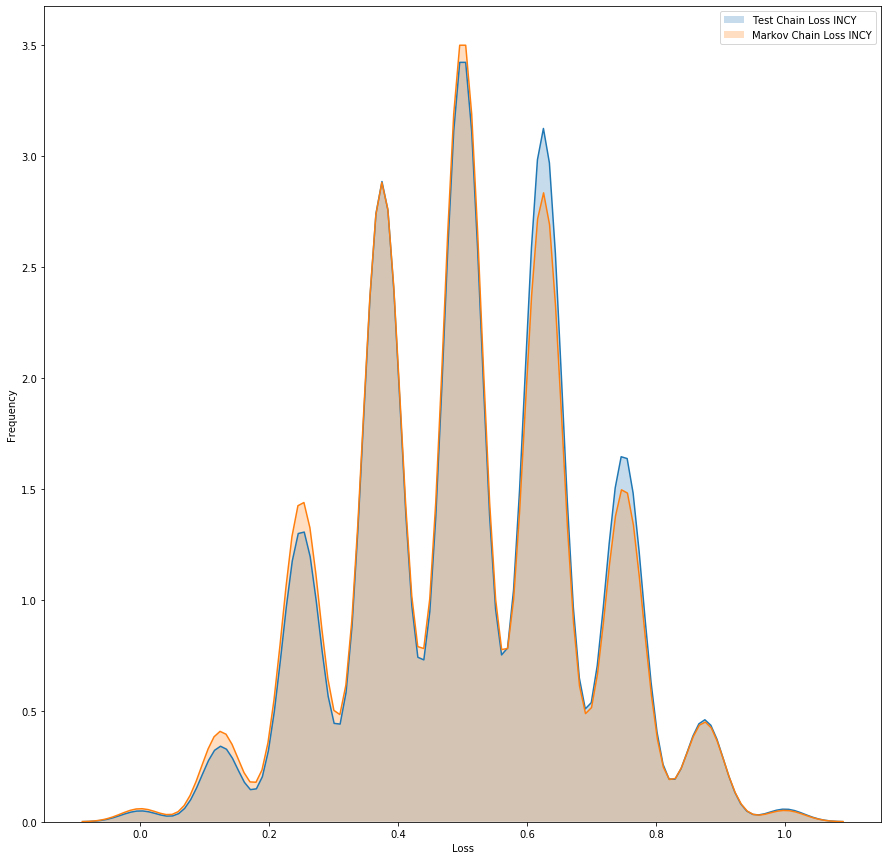

50.54945054945055% done!


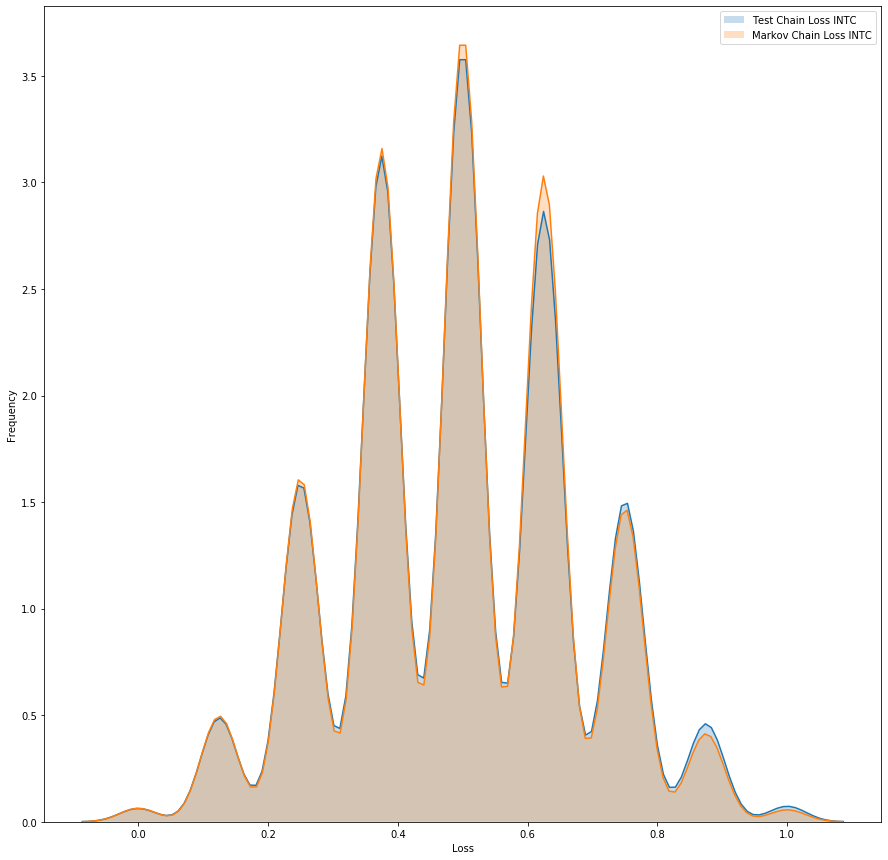

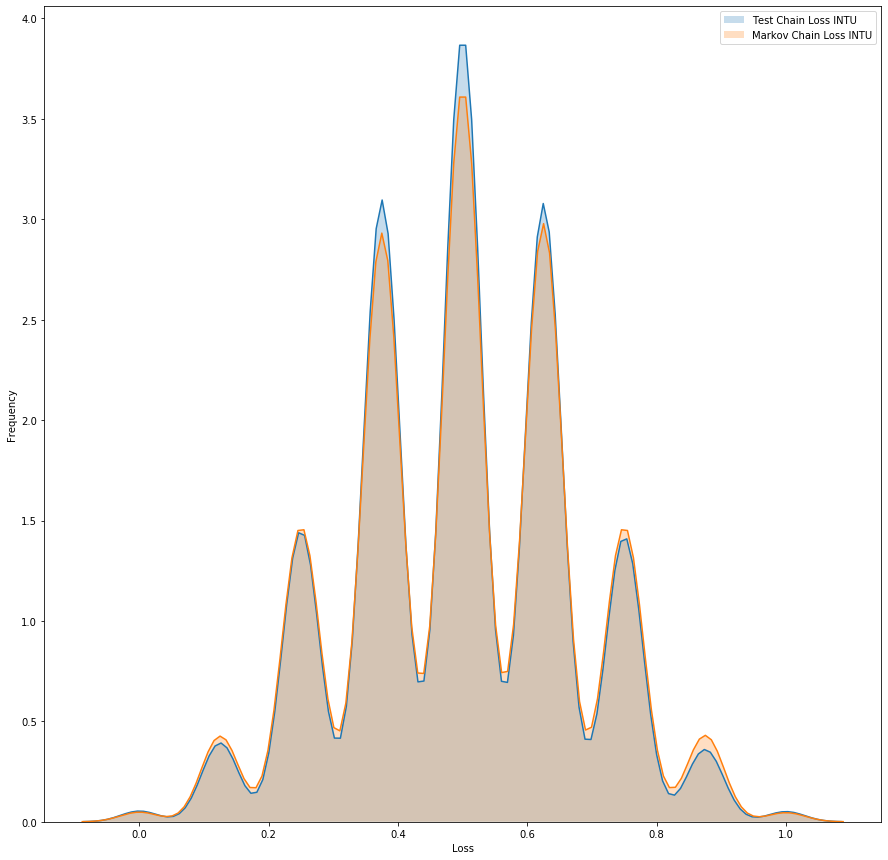

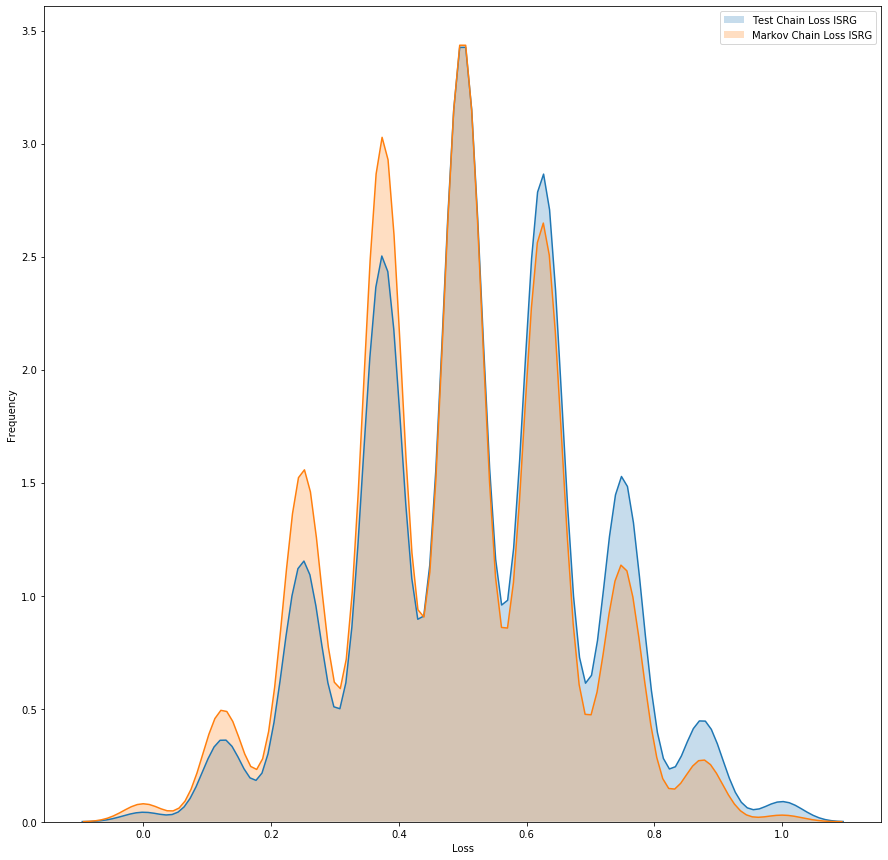

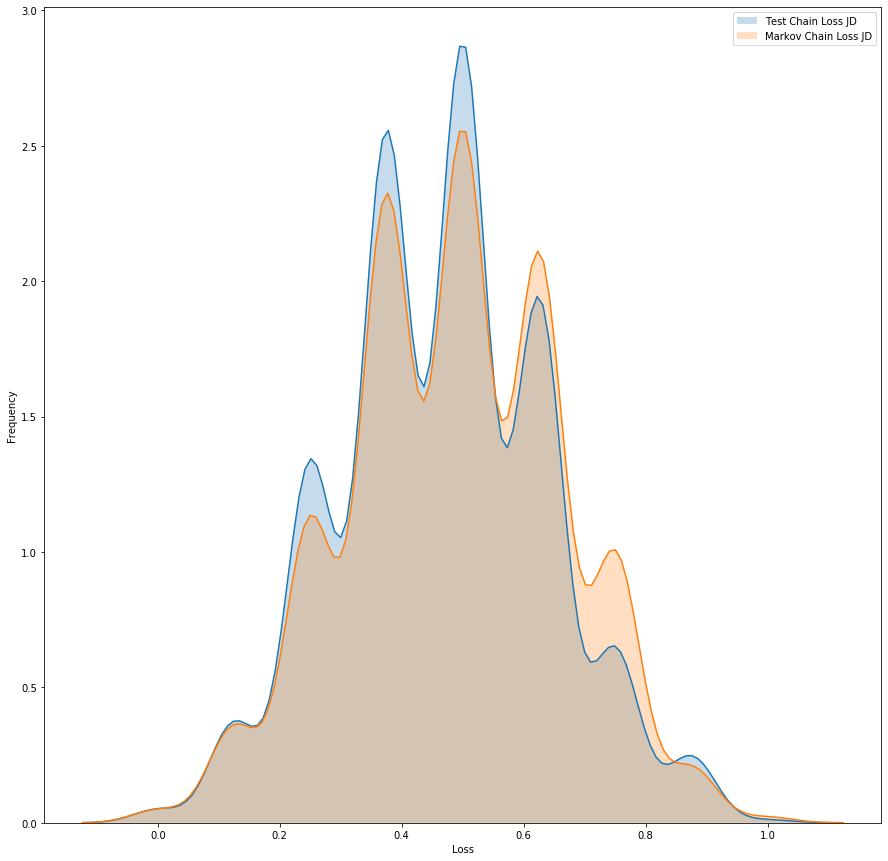

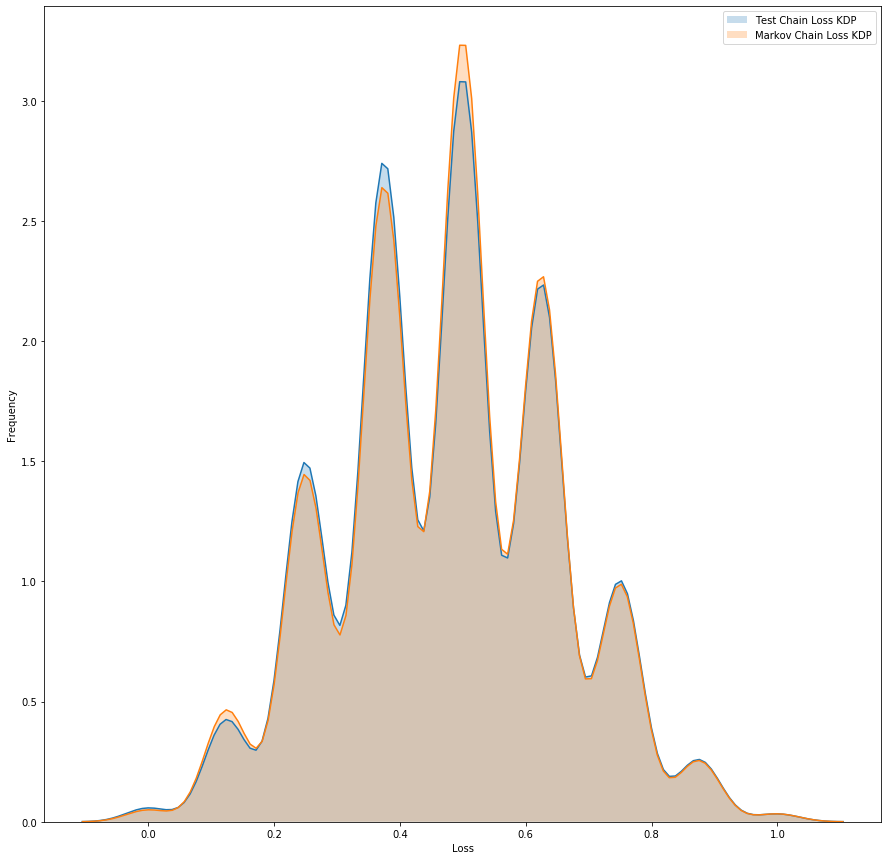

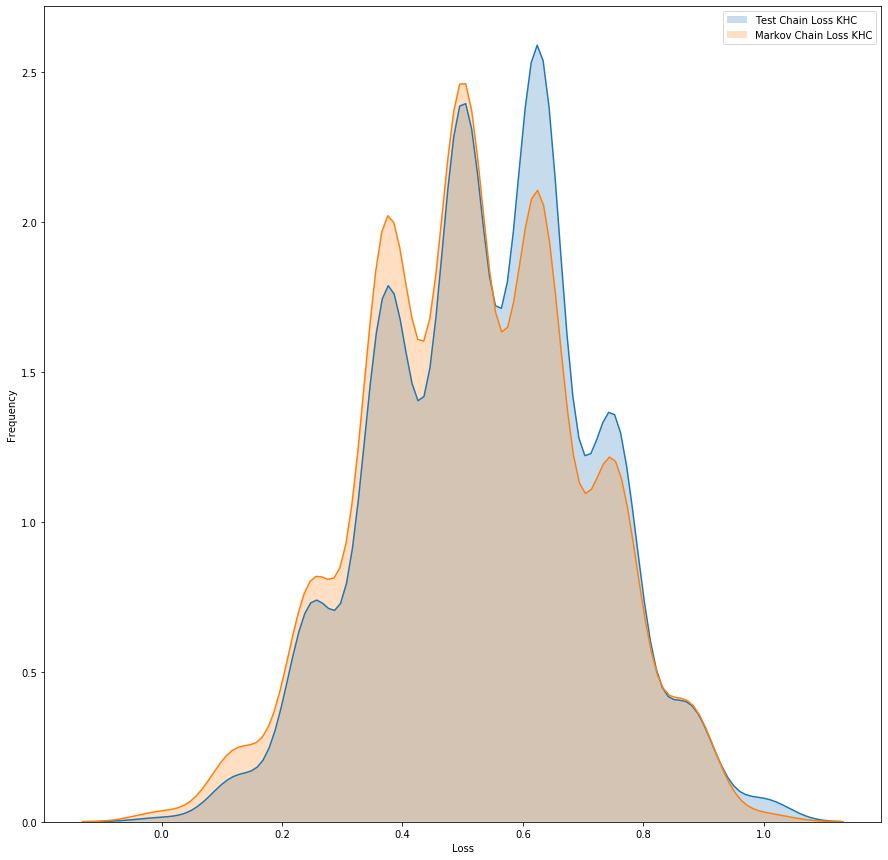

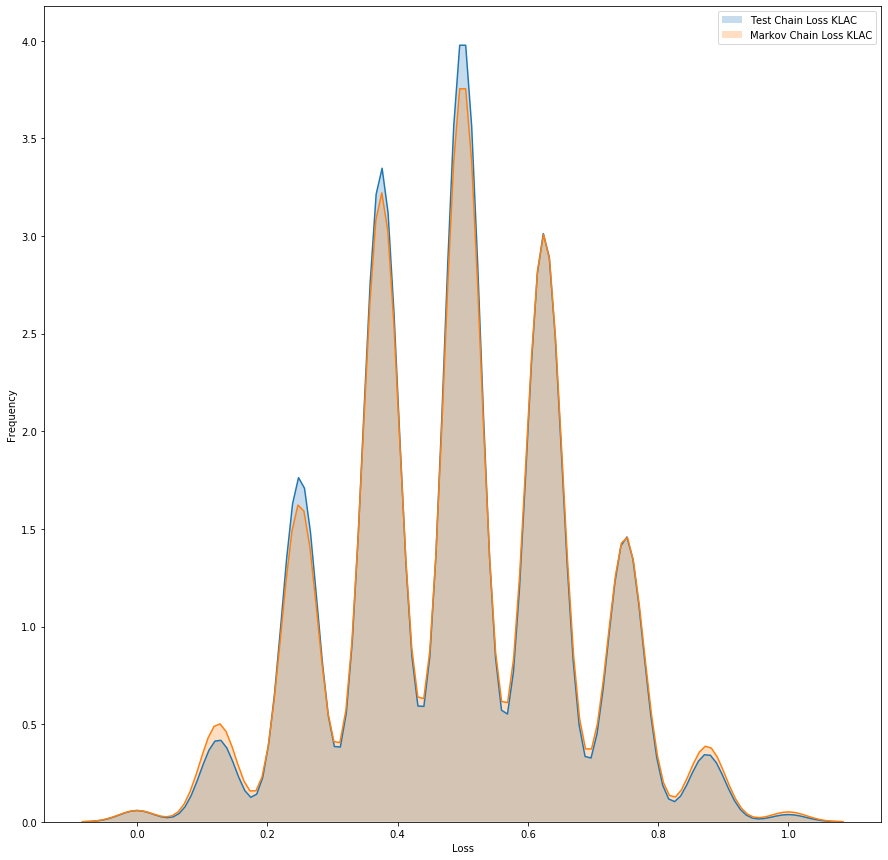

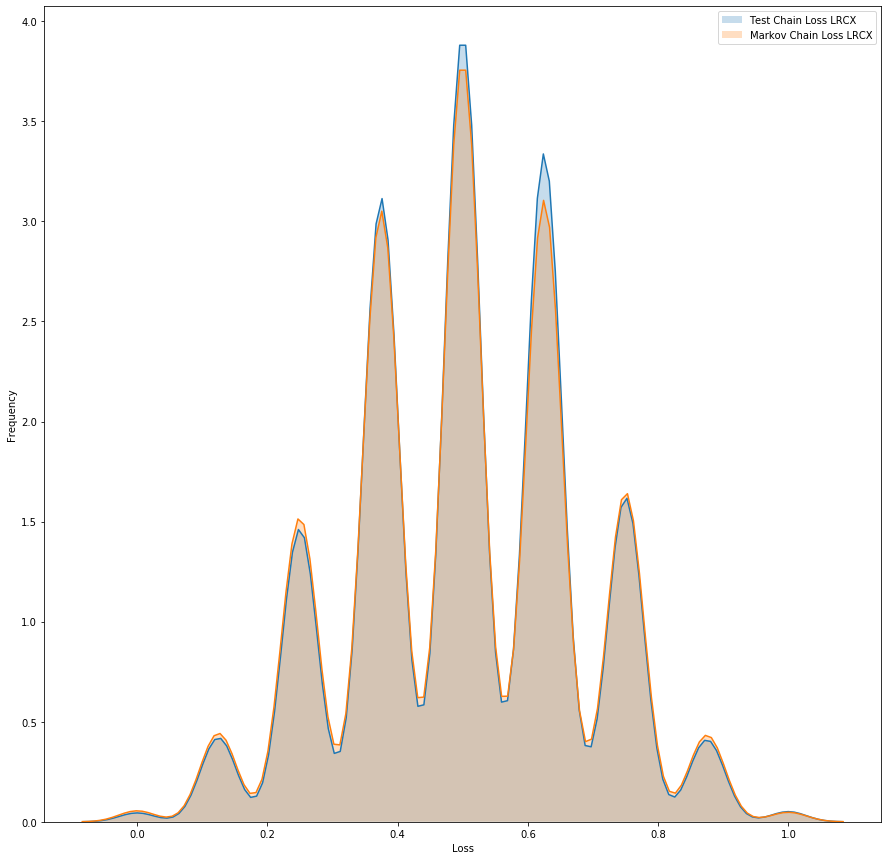

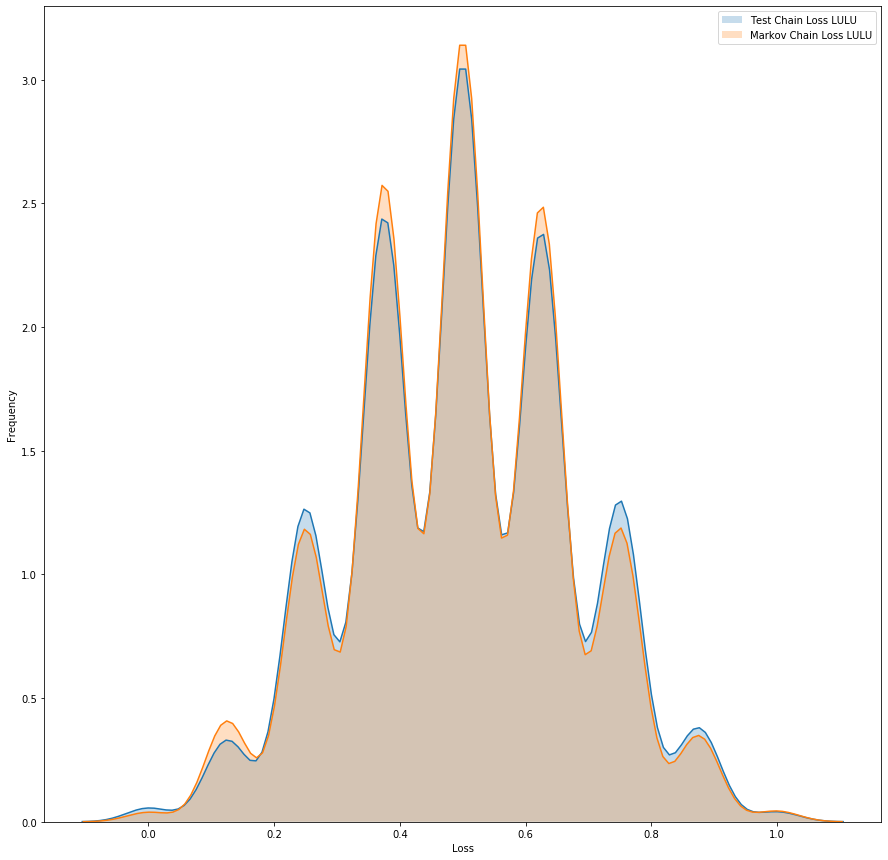

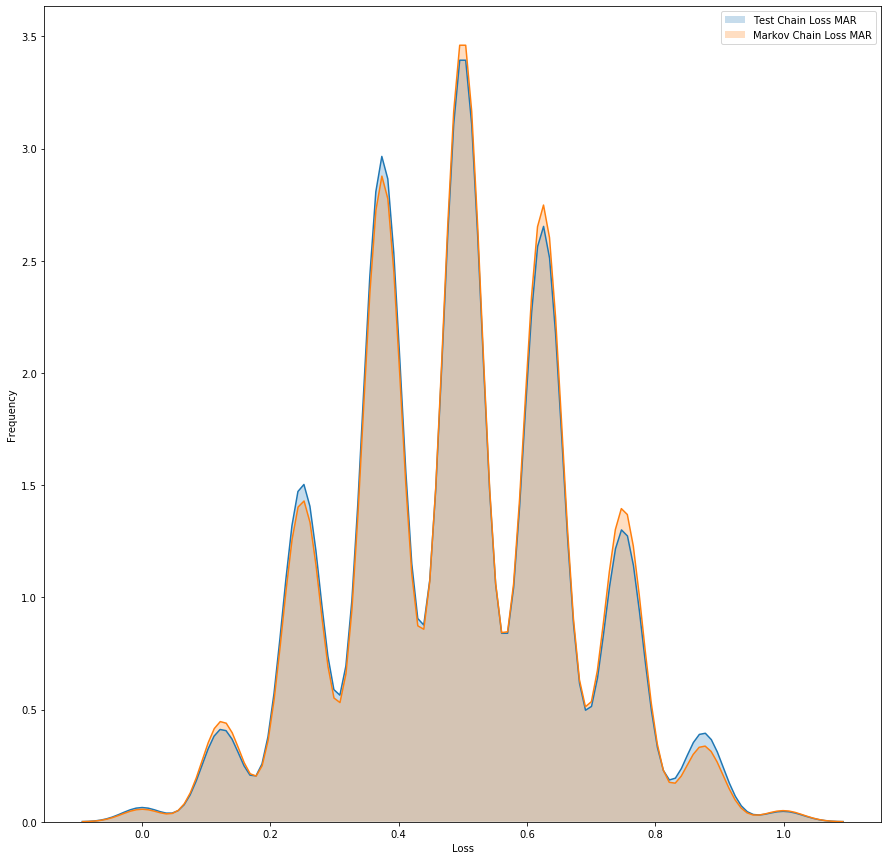

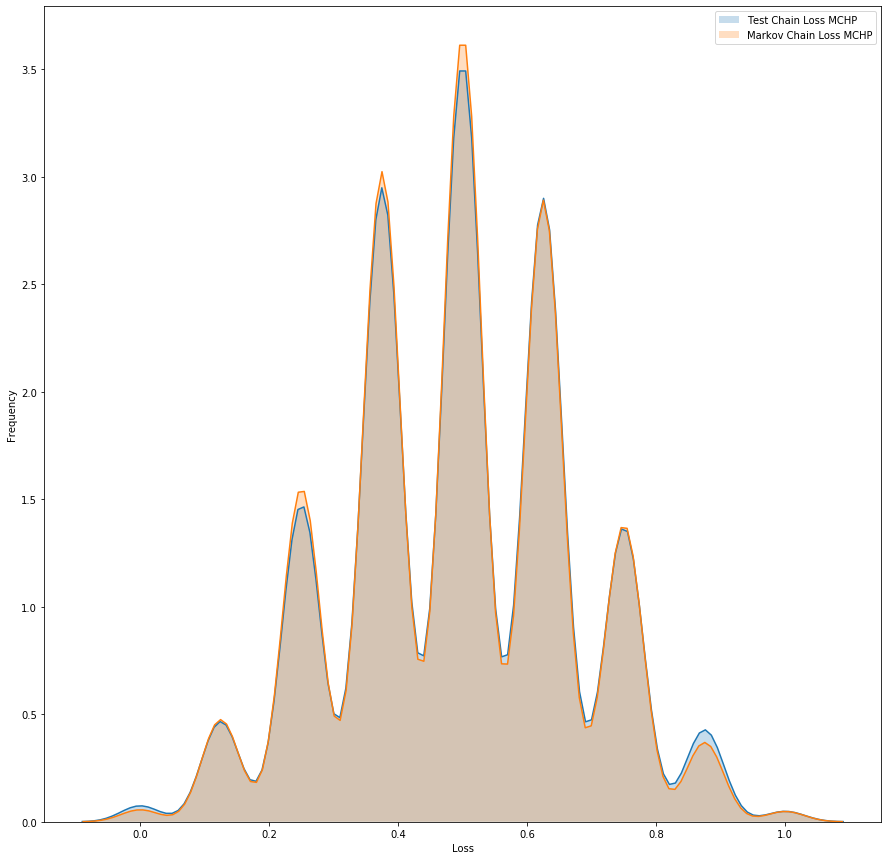

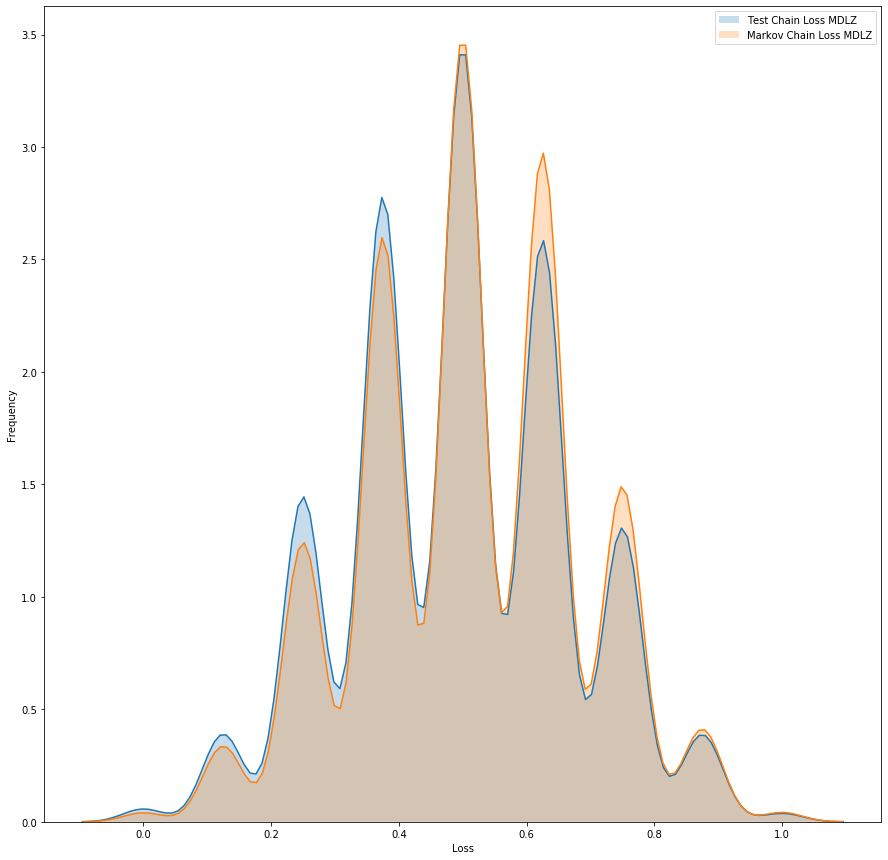

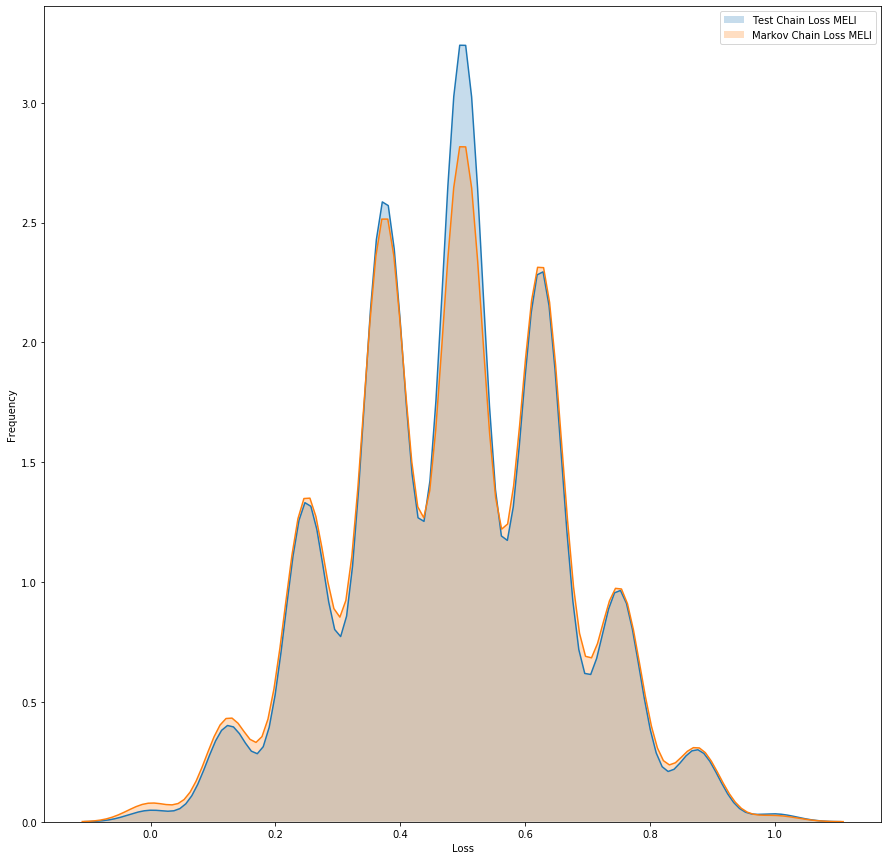

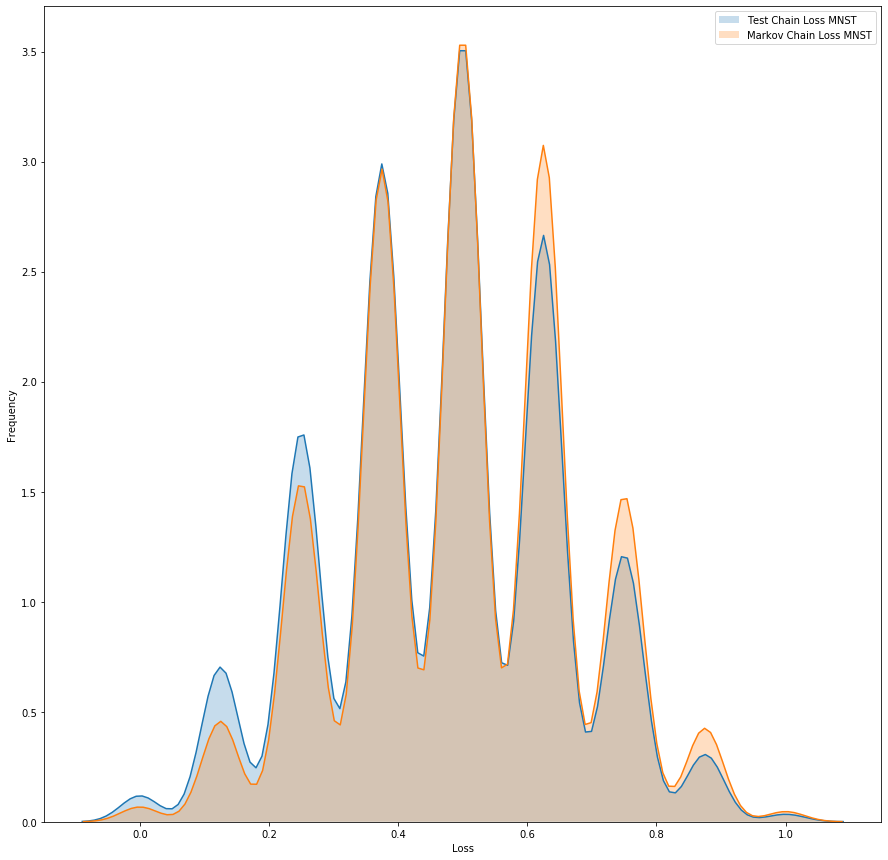

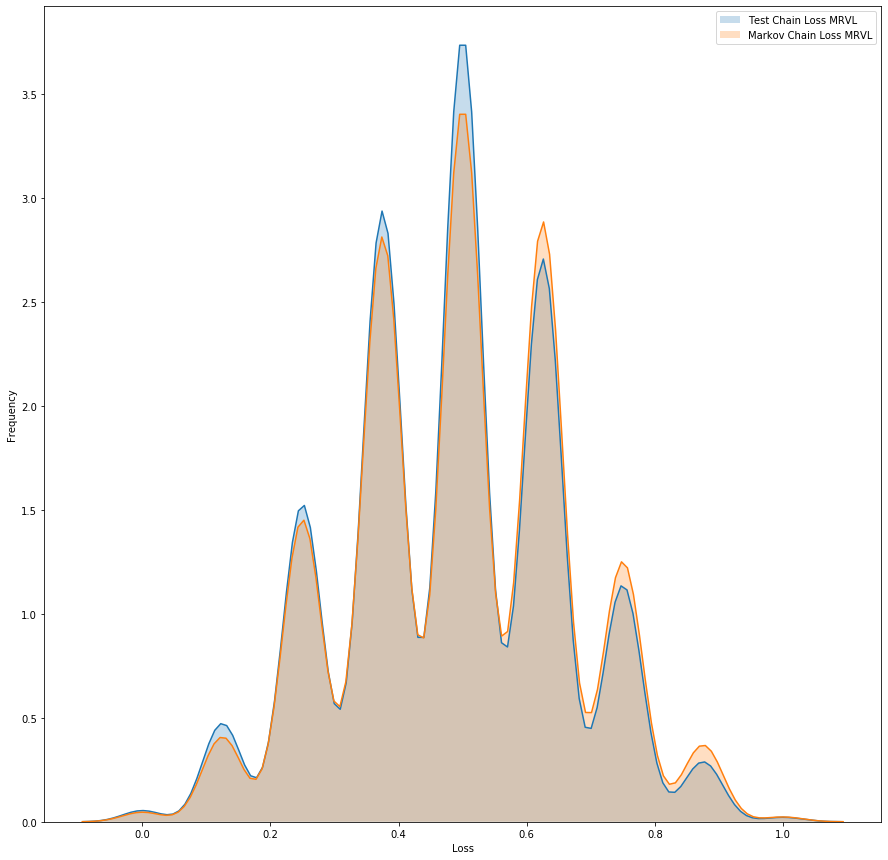

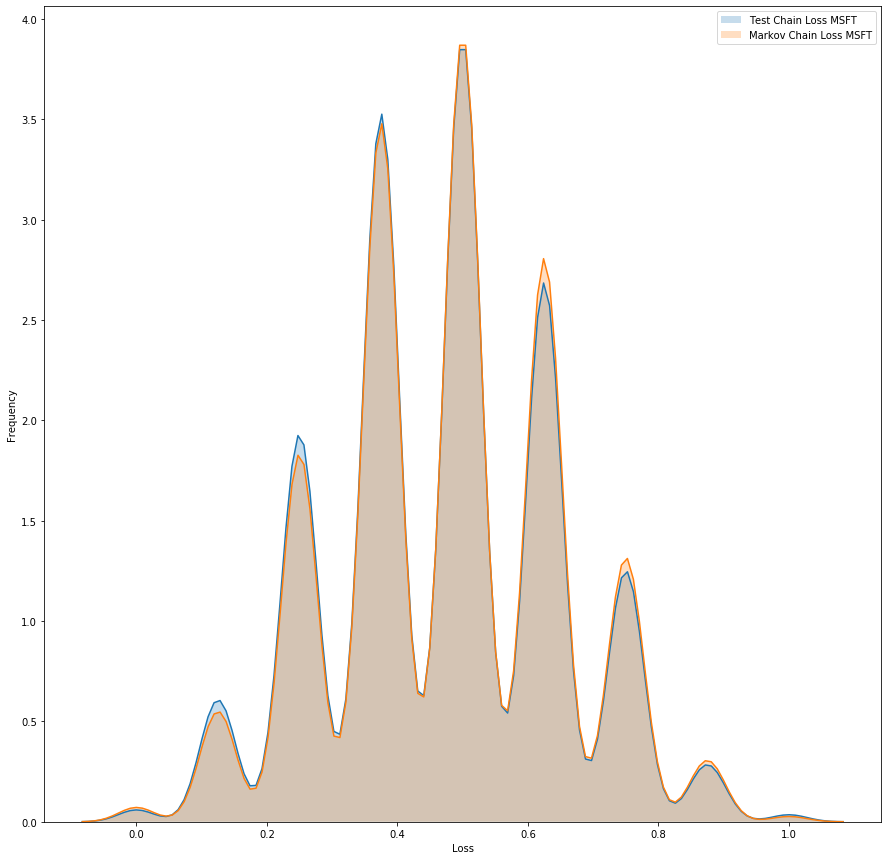

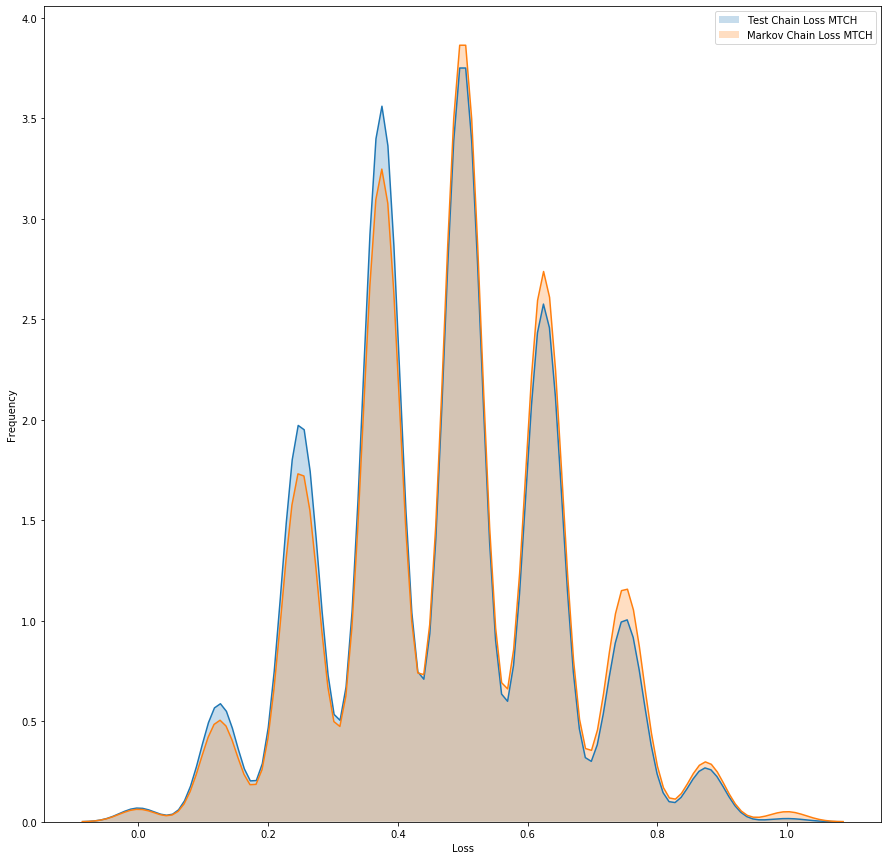

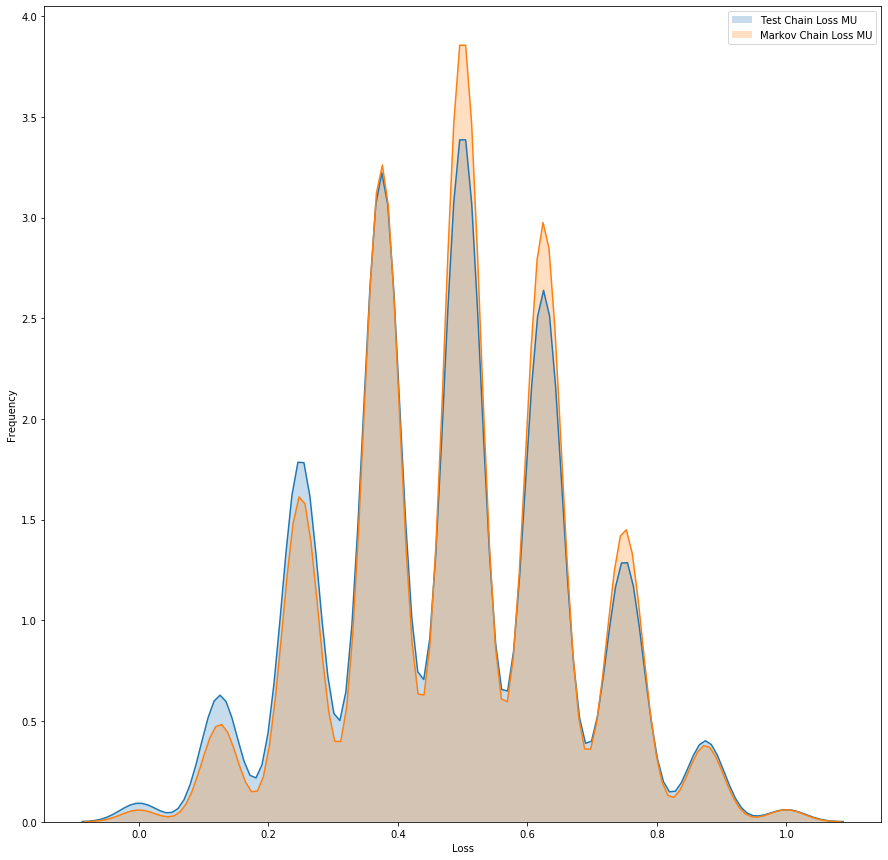

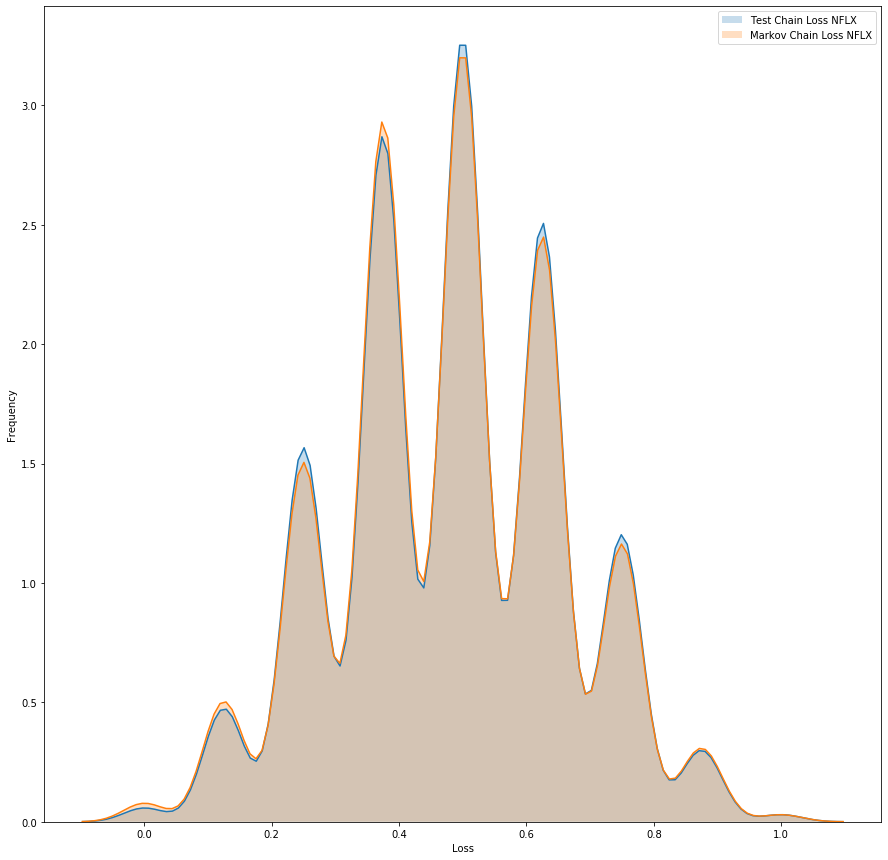

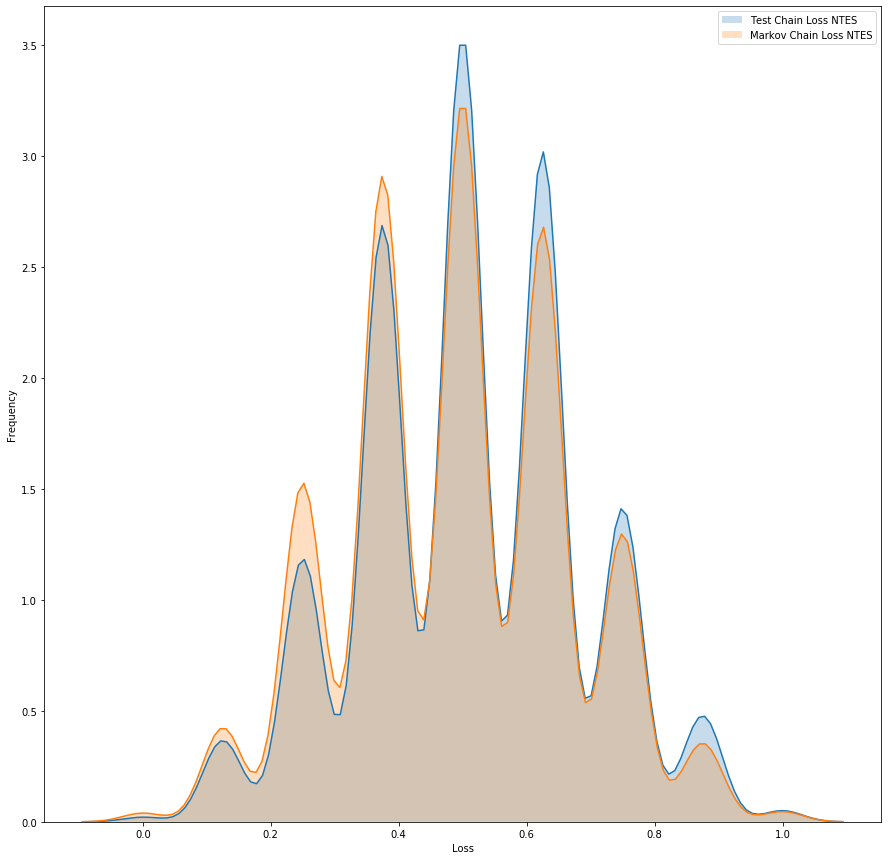

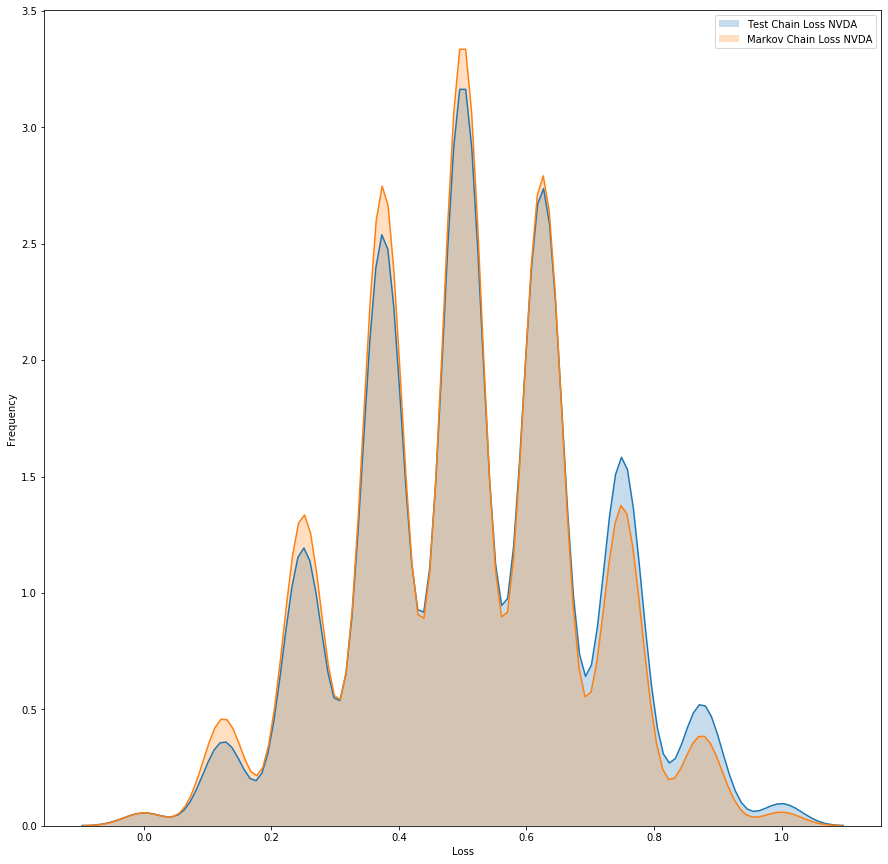

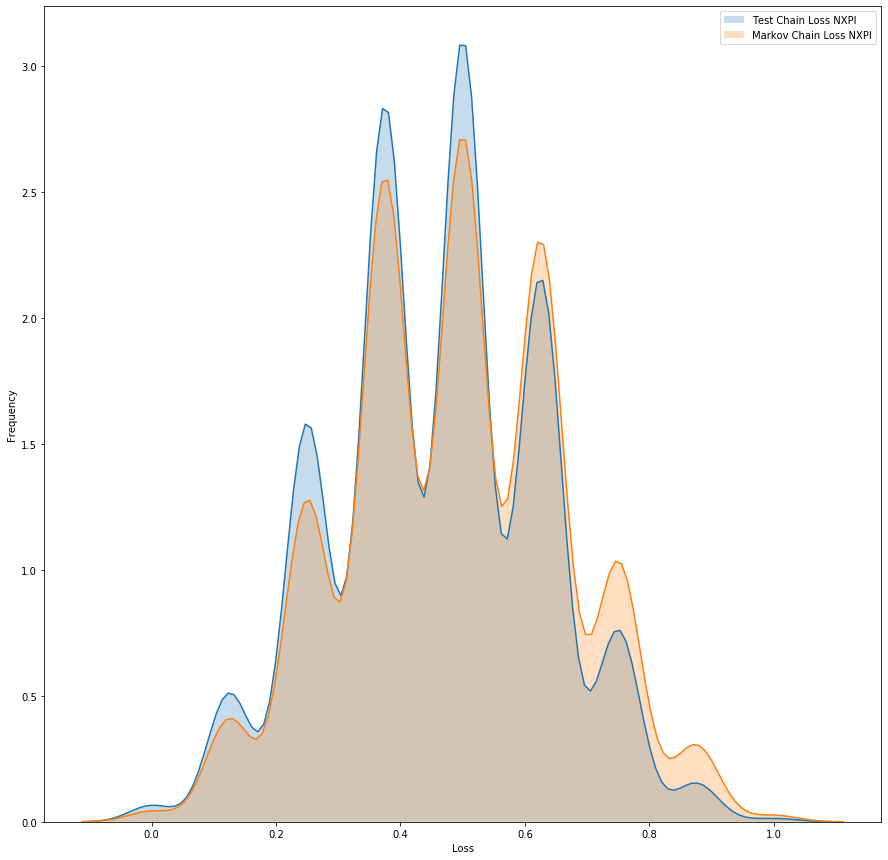

74.72527472527473% done!


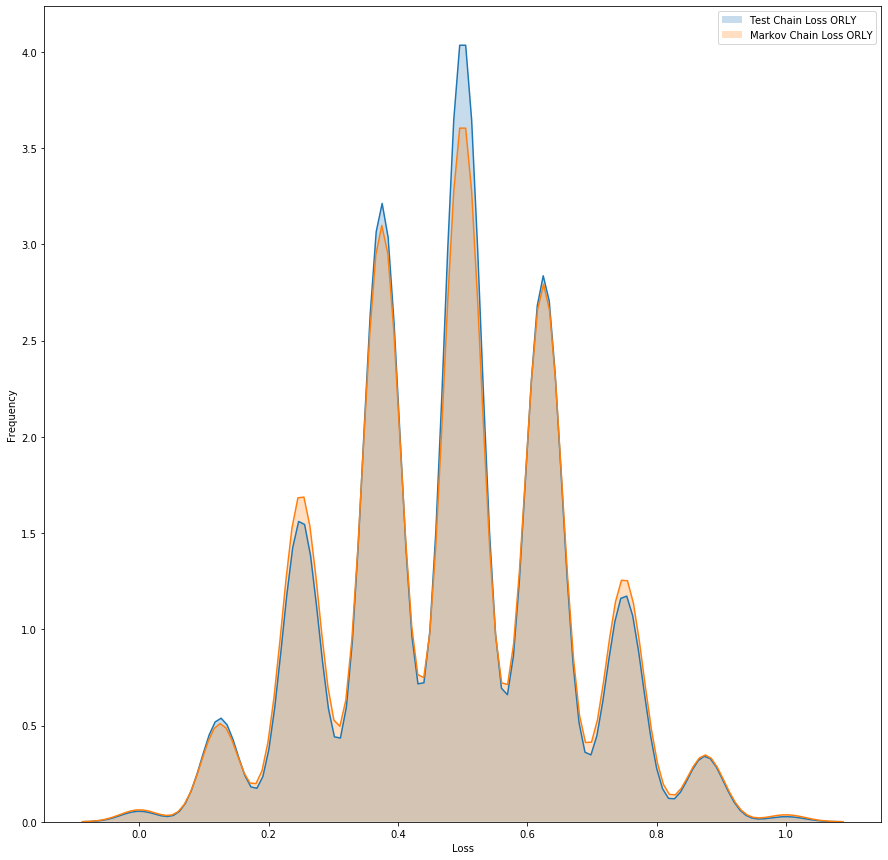

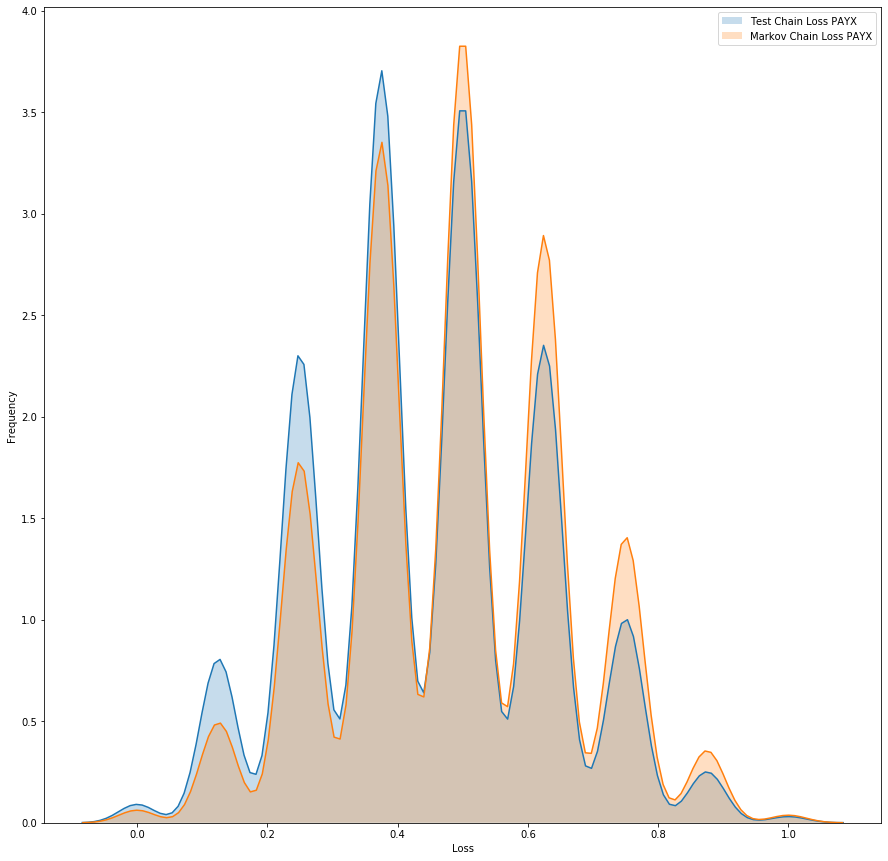

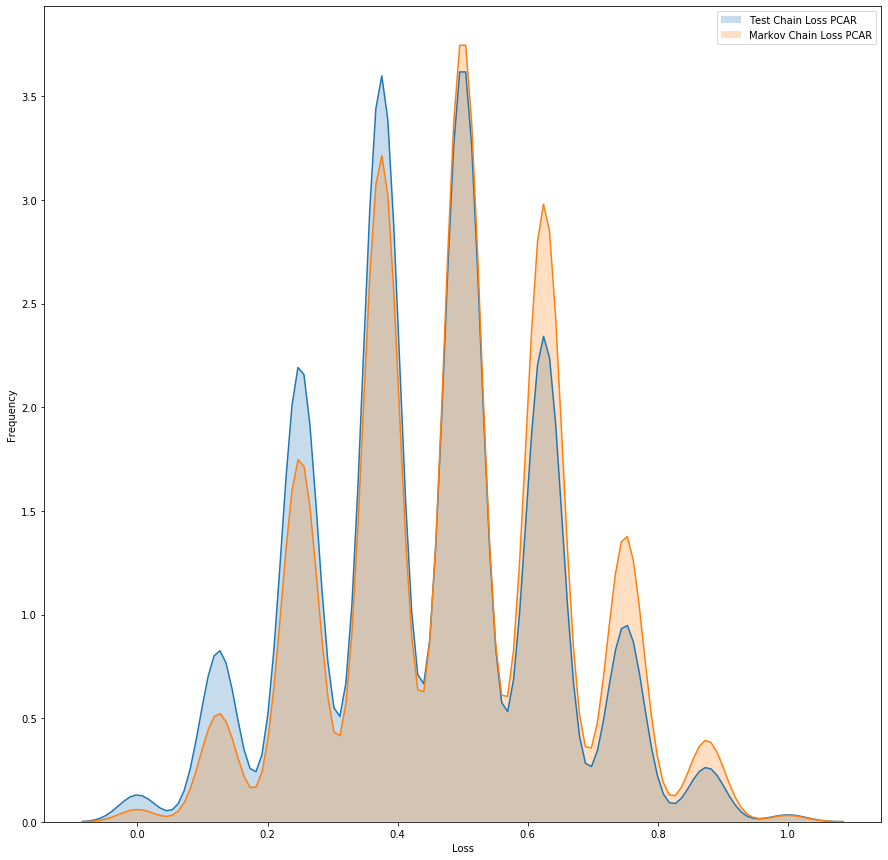

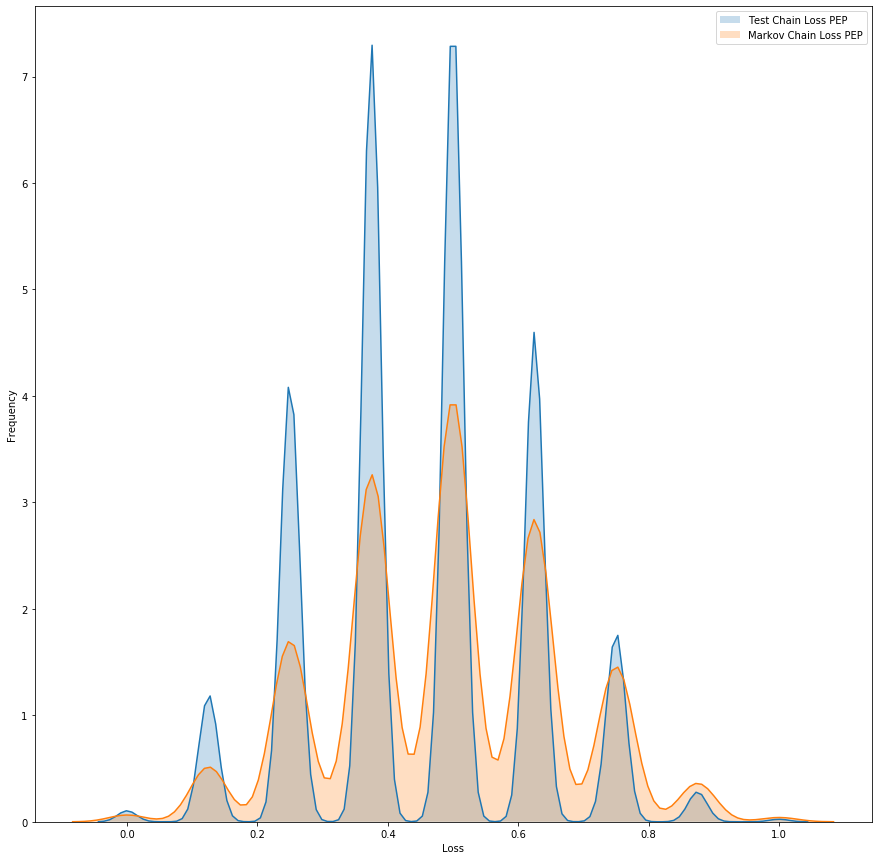

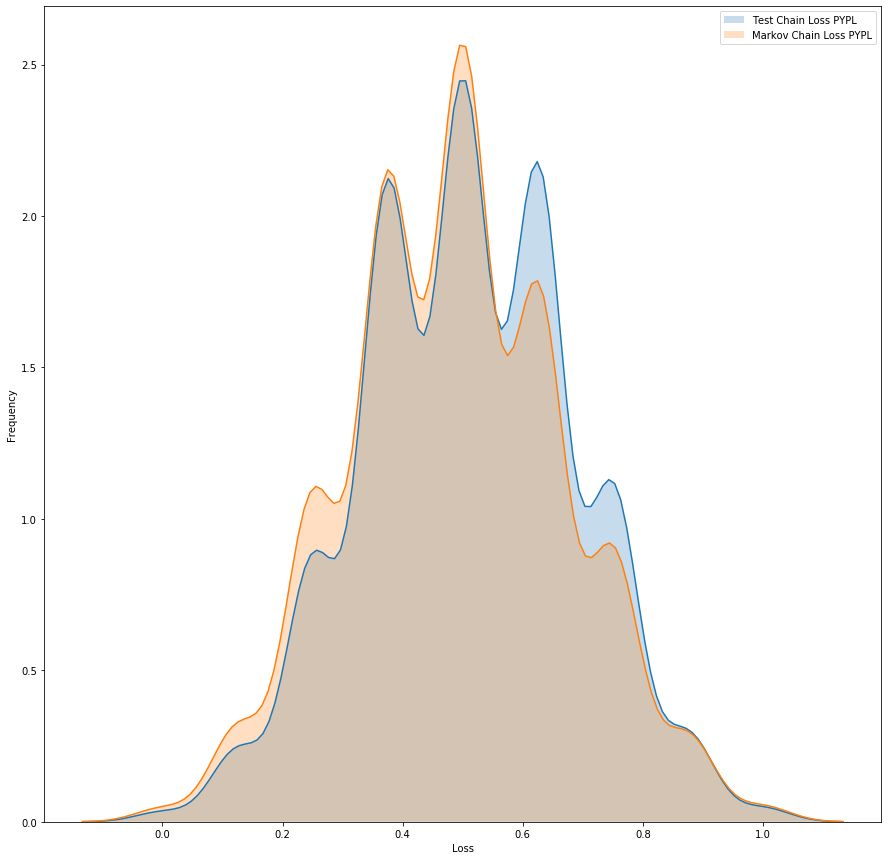

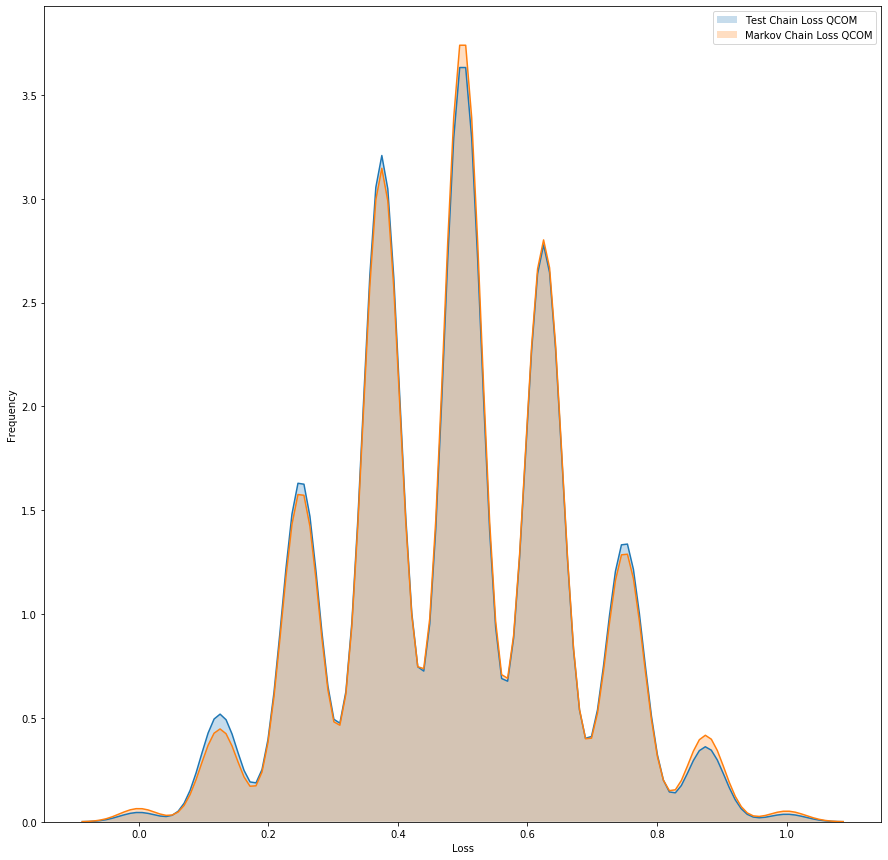

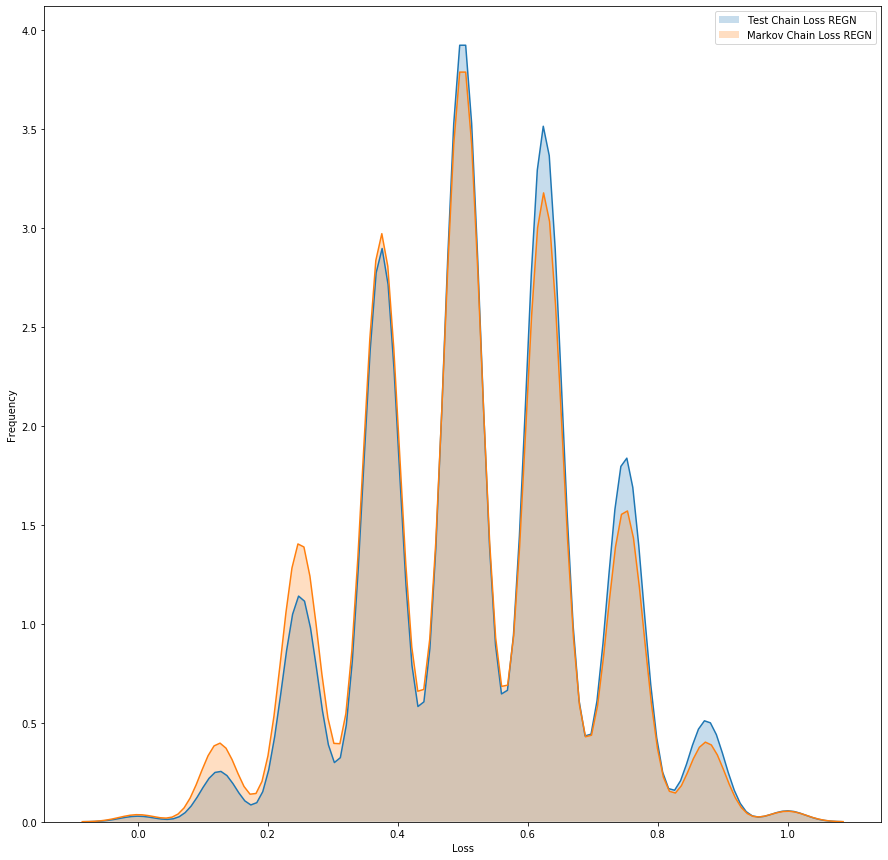

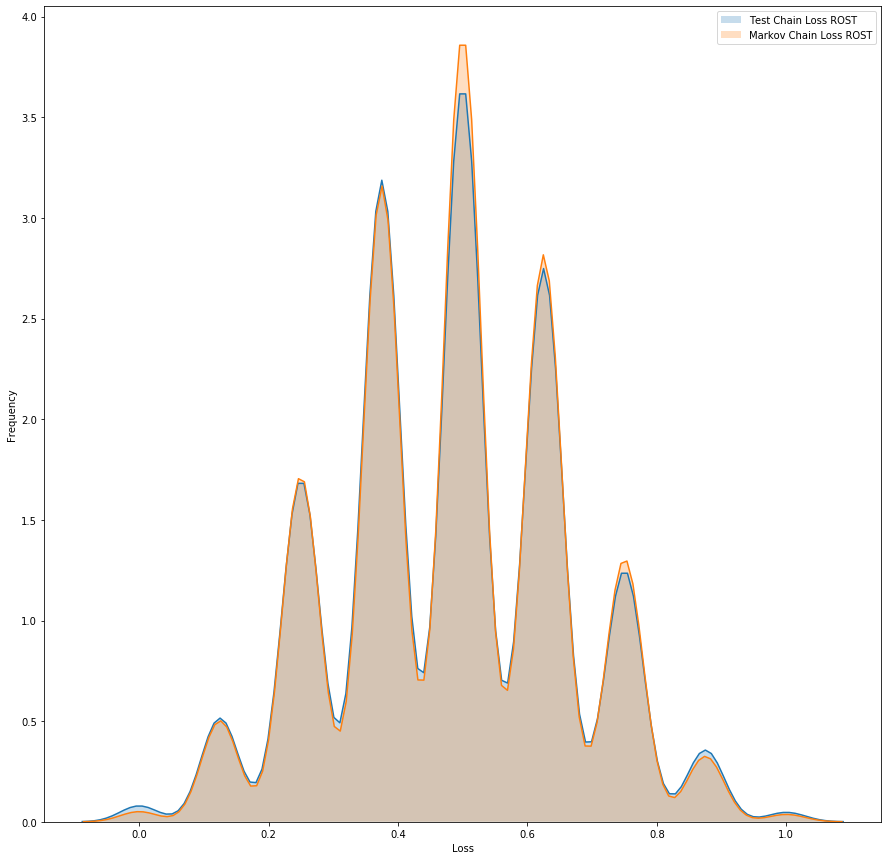

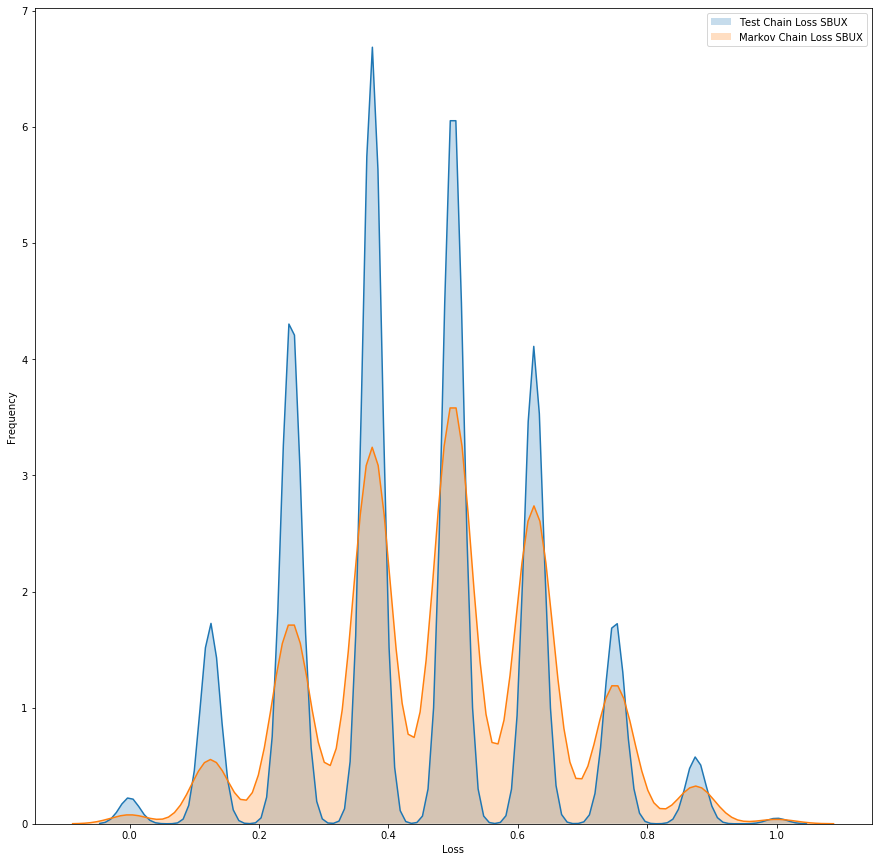

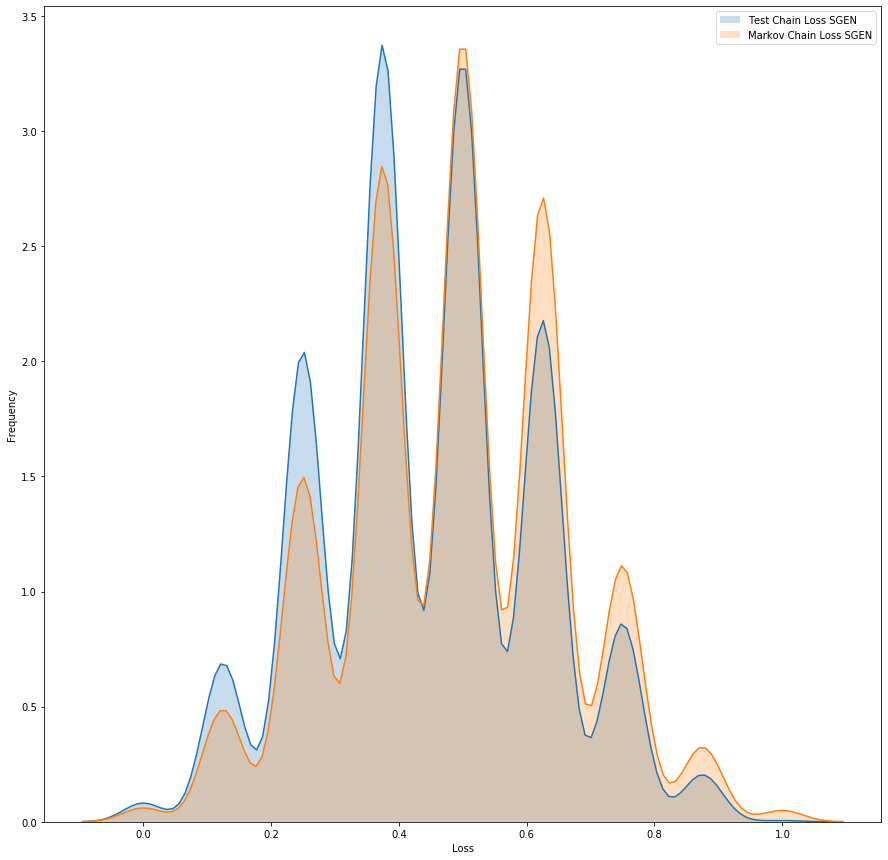

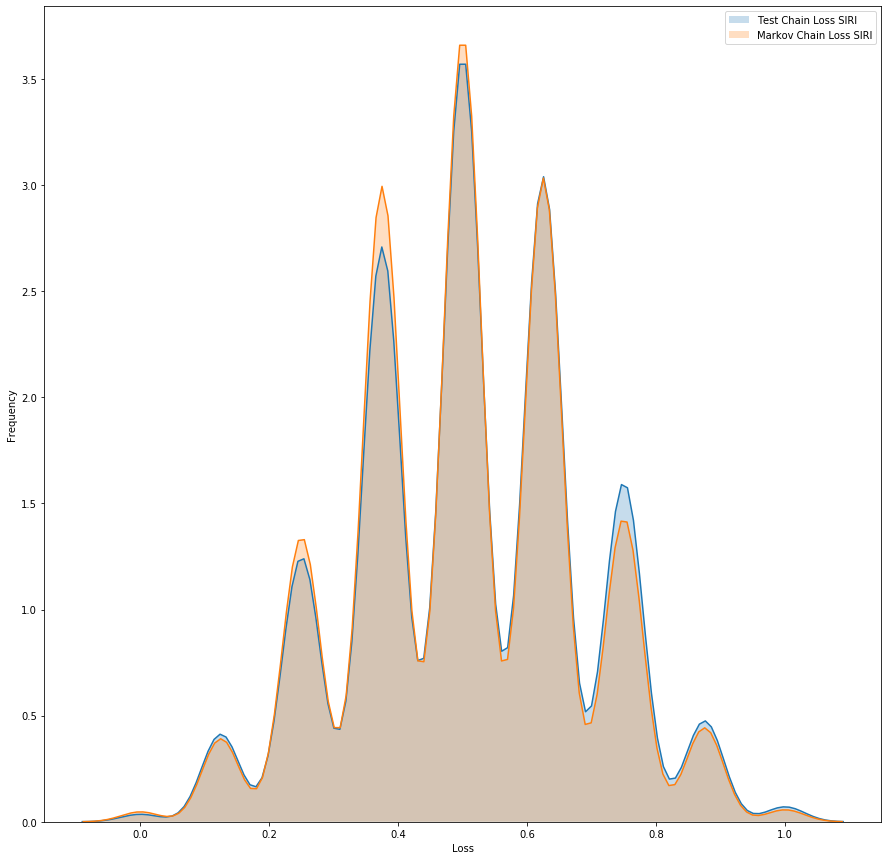

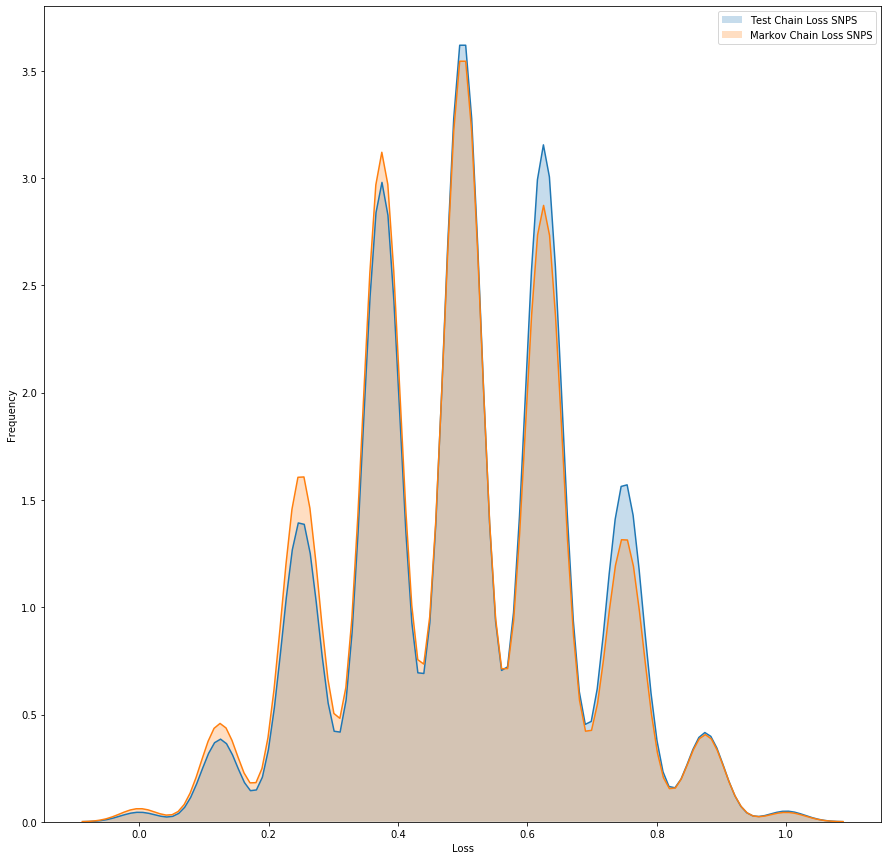

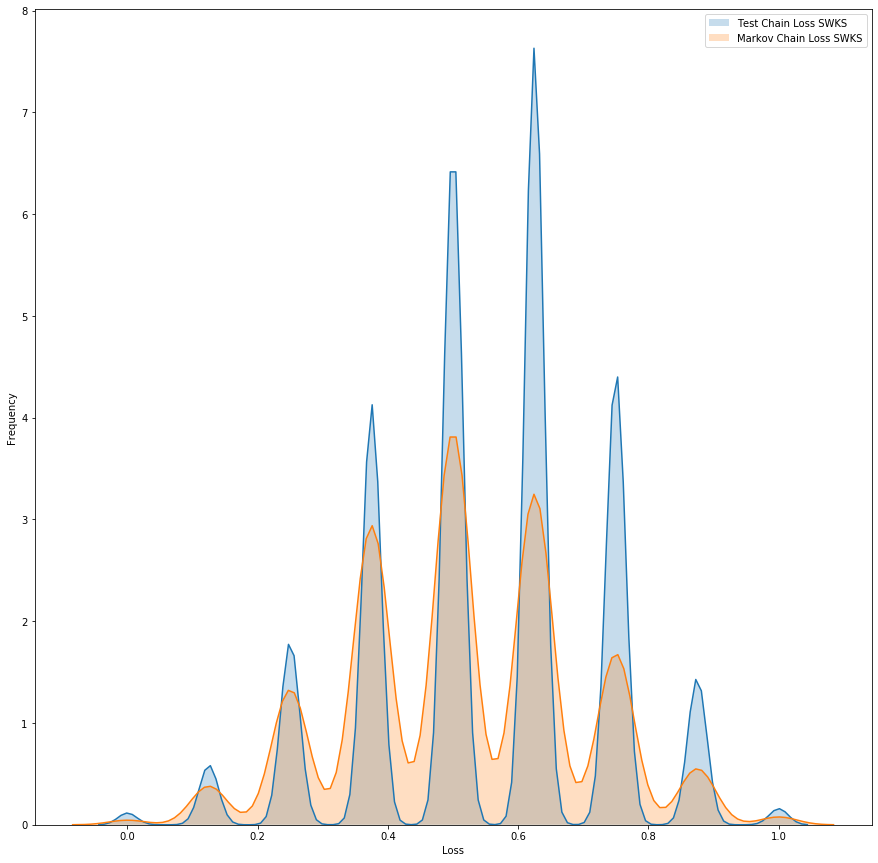

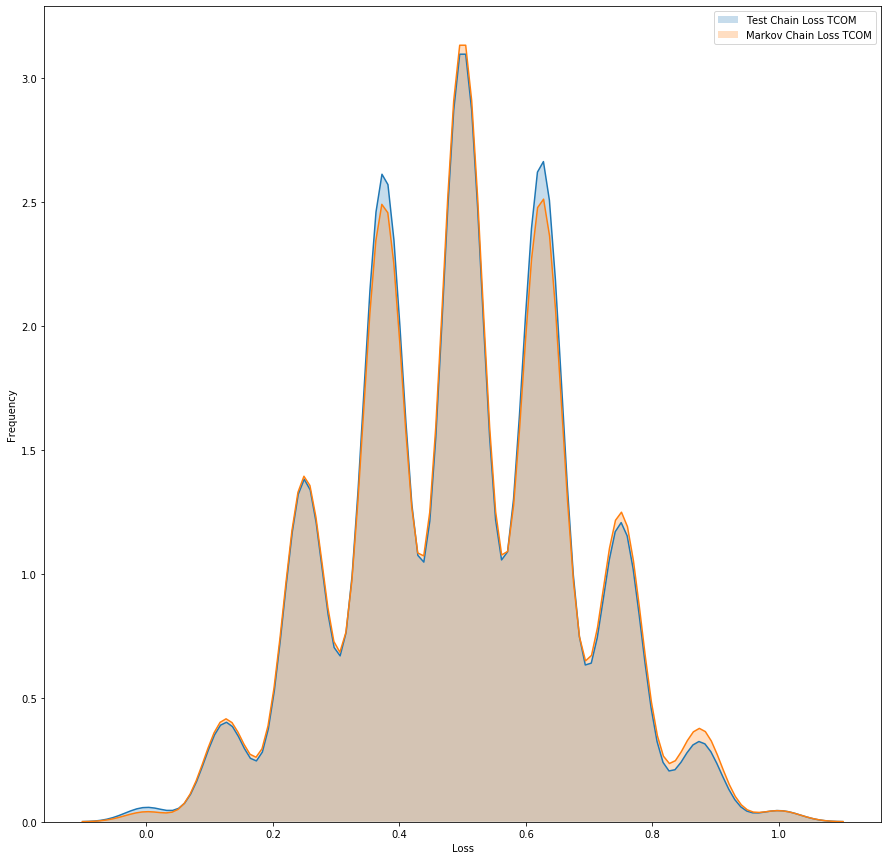

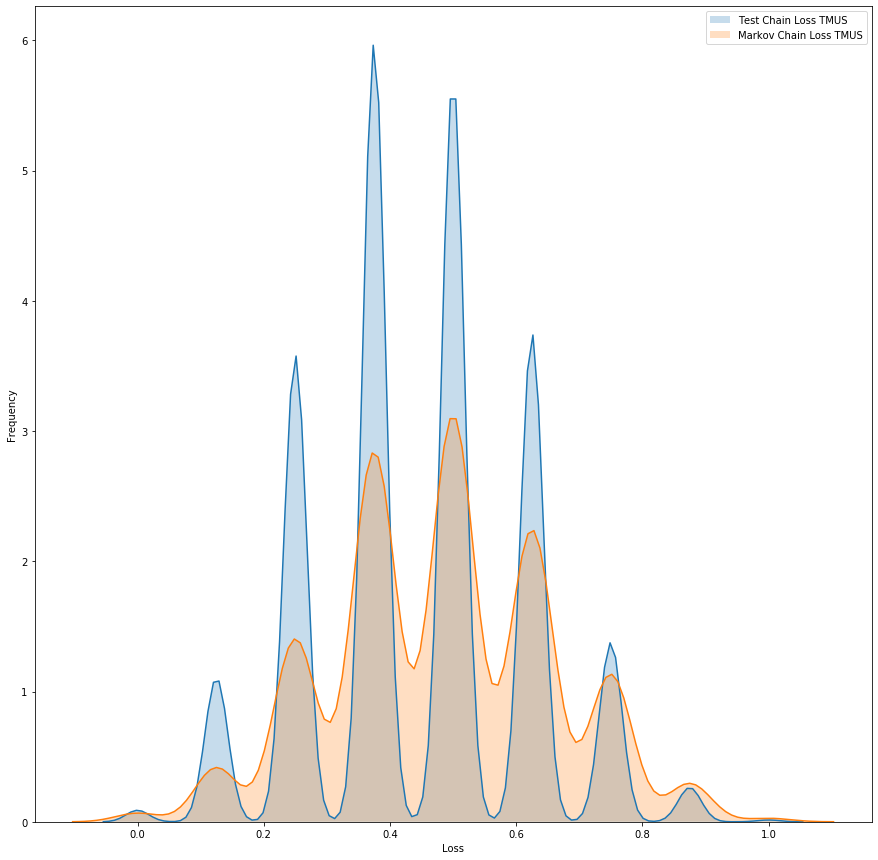

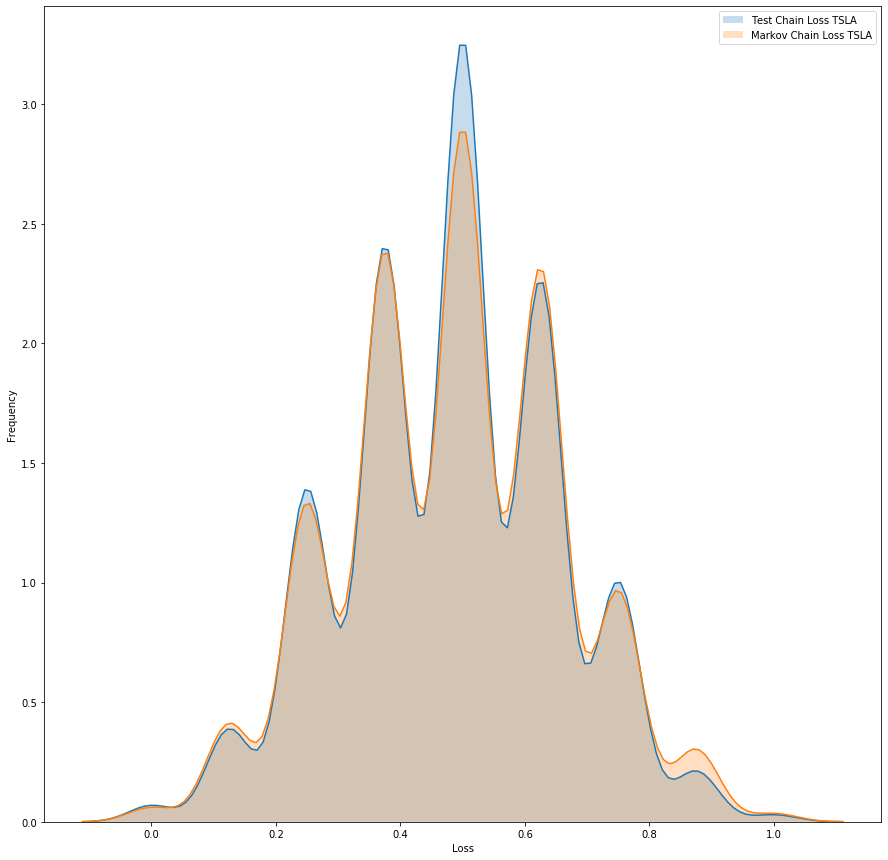

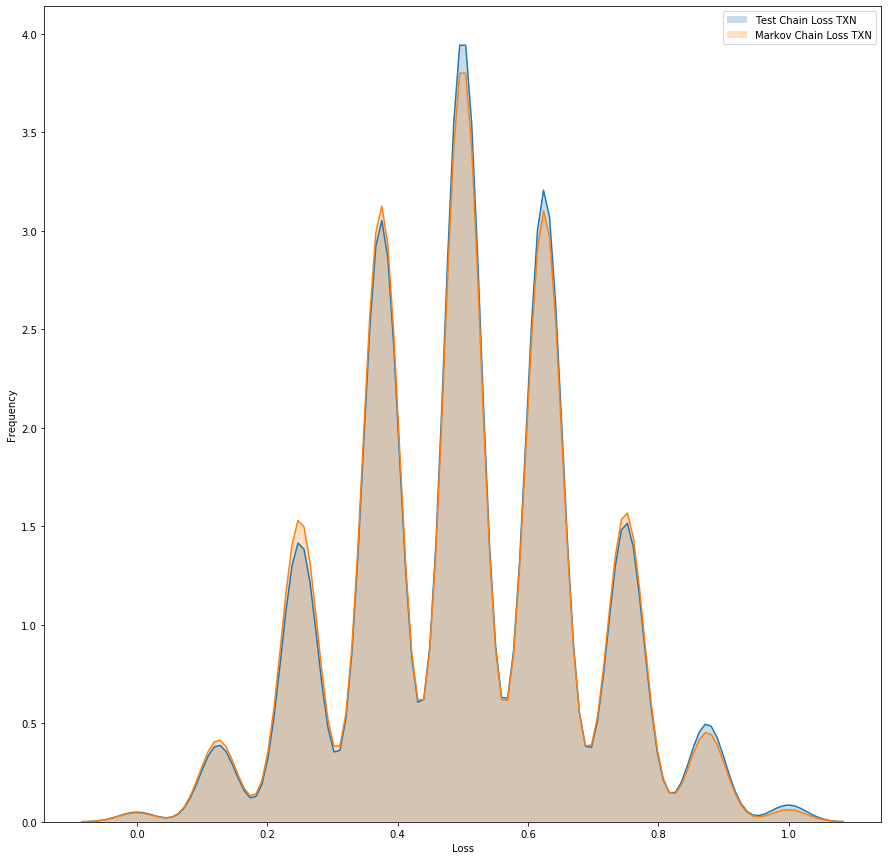

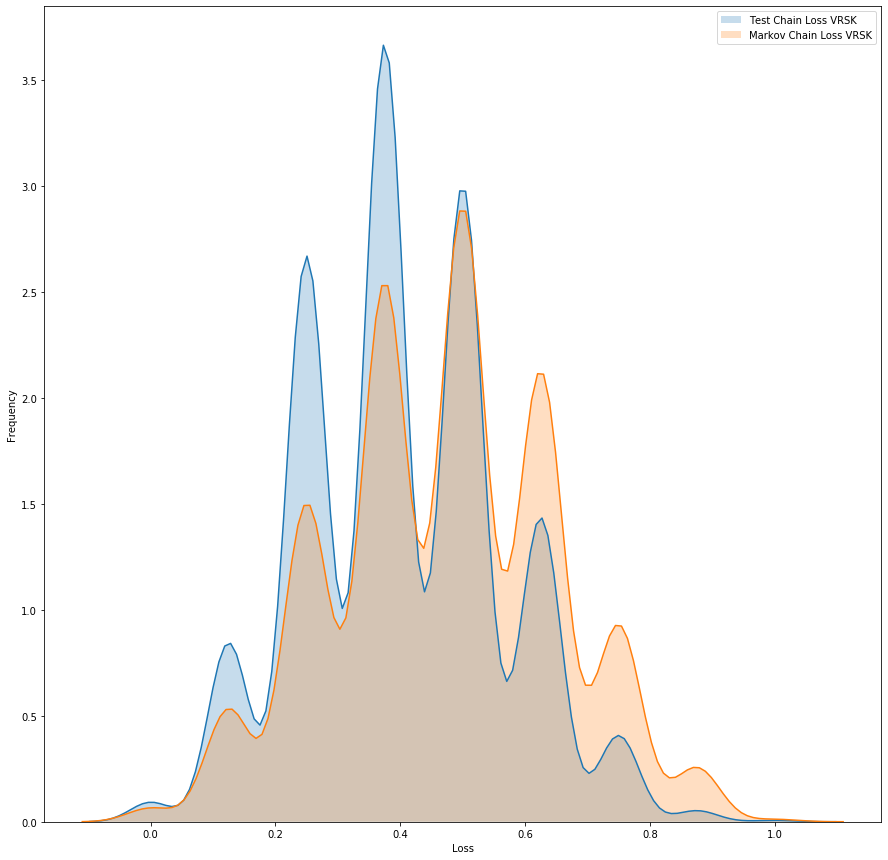

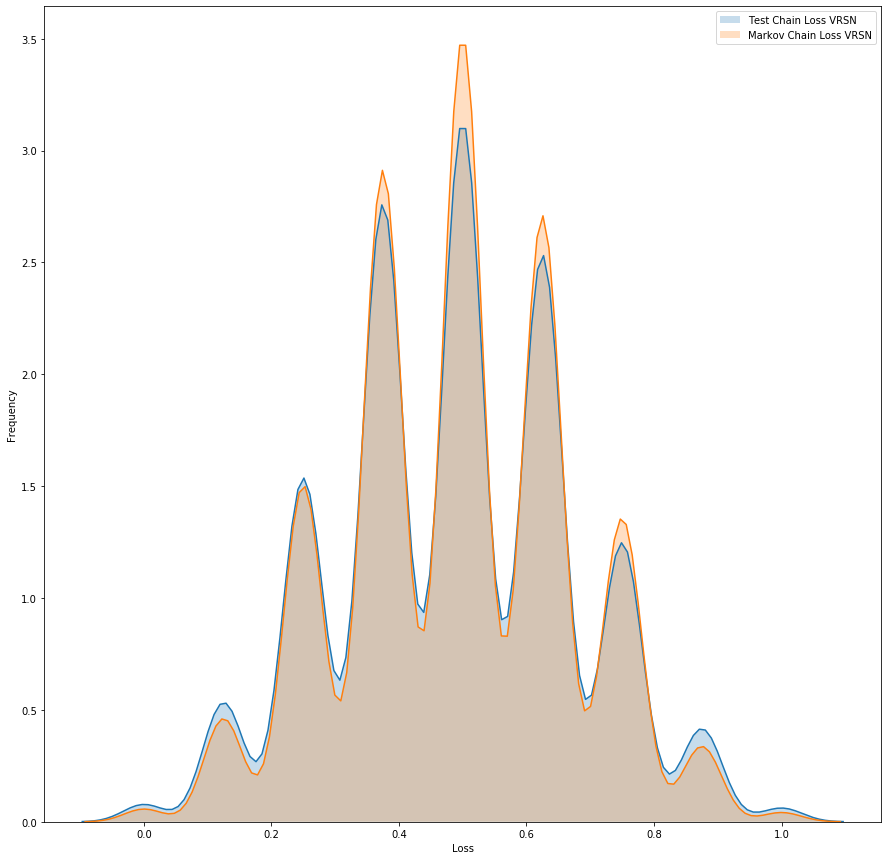

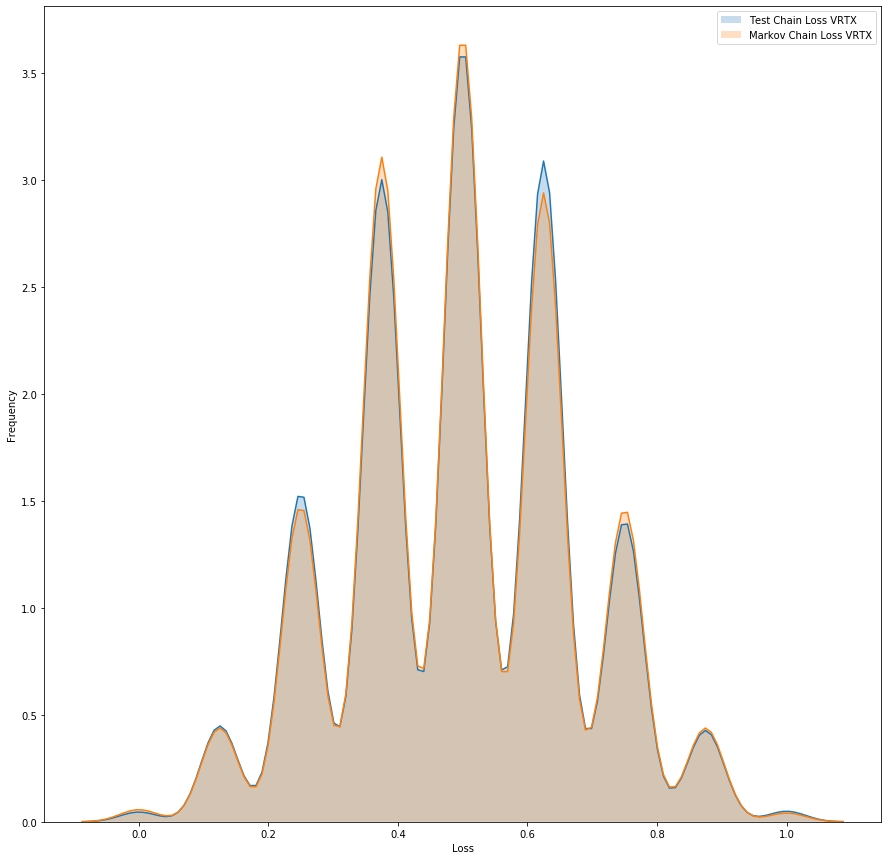

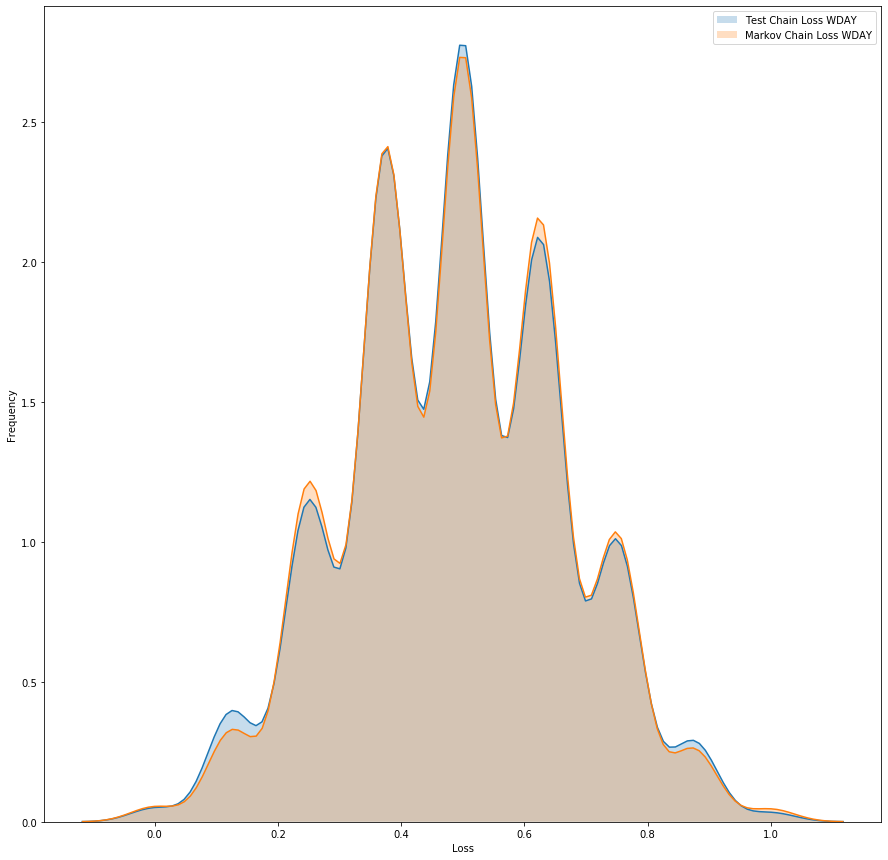

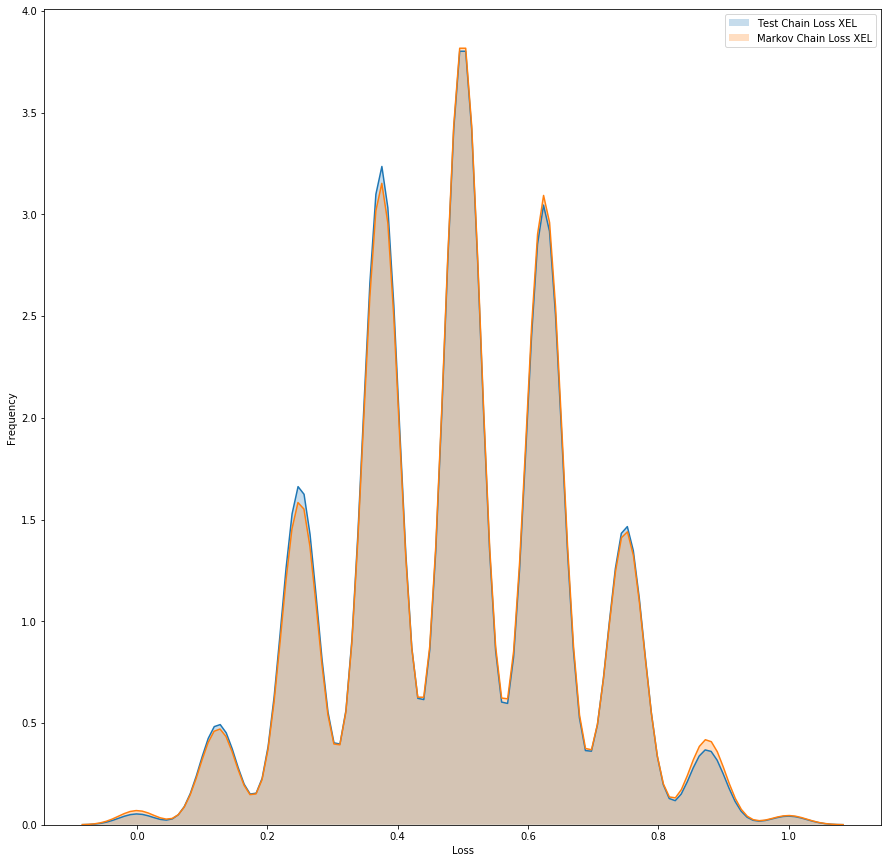

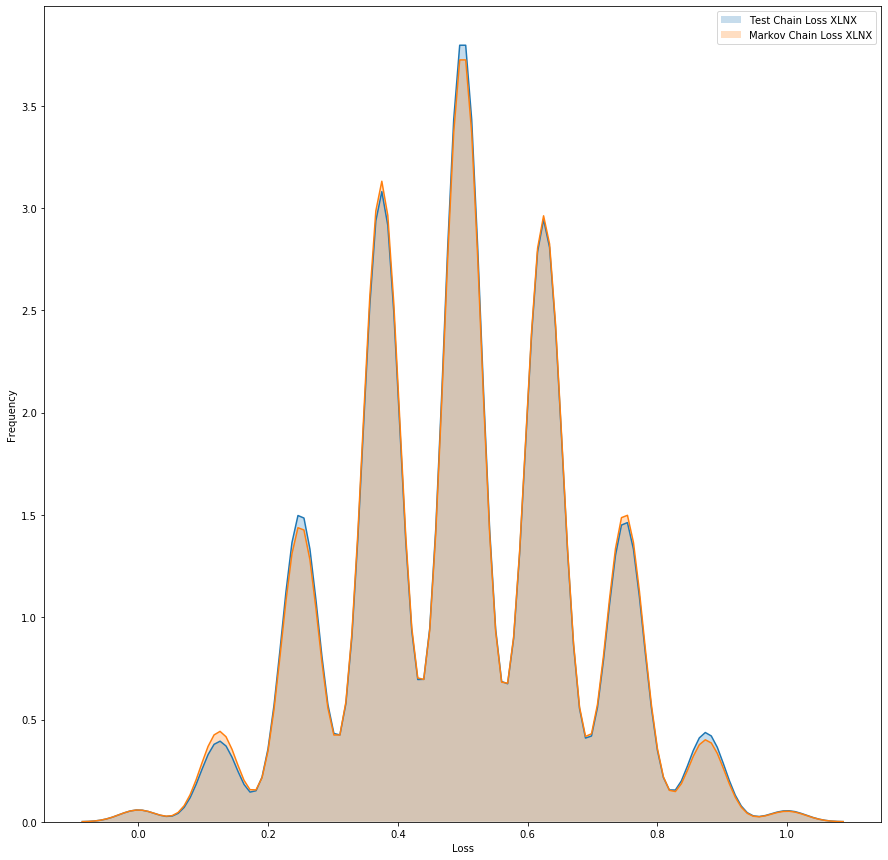

In [9]:
final_out = pd.DataFrame()
final_out["Ticker"] = list(all_data.keys())
testerrorqties = {}
for g in range(len(all_data)):
    if g in [1,23,46,68]:
        print(str(100*g / len(all_data))+"% done!")
    test_comps = [list(all_data.keys())[g]]
    test = npdf.iloc[np.where(npdf["Ticker"] == test_comps[0])]
    train = npdf.iloc[np.where(npdf["Ticker"] != test_comps[0])]
    train.reset_index(drop = True,inplace = True)
    test.reset_index(drop = True,inplace = True)
    npdfu = train.loc[npdf["t0"] == 1]
    npdfd = train.loc[npdf["t0"] == 0]
    n_neighbors = 5
    scale = pd.DataFrame()
    scale["MarketCap"] = norm(npdfu["MarketCap"])
    scale["PeRatio"] = norm(npdfu["PeRatio"])
    upknn = neighbors.KNeighborsClassifier(n_neighbors)
    X = scale[["MarketCap","PeRatio"]]
    y = npdfu["t1"]
    upknn.fit(X,y)
    scale = pd.DataFrame()
    scale["MarketCap"] = norm(npdfd["MarketCap"])
    scale["PeRatio"] = norm(npdfd["PeRatio"])
    downknn = neighbors.KNeighborsClassifier(n_neighbors)
    X = scale[["MarketCap","PeRatio"]]
    y = npdfd["t1"]
    downknn.fit(X,y)
    p = 9
    k = 0
    TEST1 = {}
    test1 = test.loc[test["Ticker"] == test_comps[0]][["t0","t1","PeRatio","MarketCap"]]
    test1.reset_index(drop = True,inplace = True)
    i=0
    while p+k <= len(test1):
        TEST1[i] = test1.iloc[k:p+k]
        k+=1
        i+=1
    np.random.seed(10)
    testloss = []
    n = 100
    for j in range(len(TEST1)):
        for i in range(n):
            out = proj(TEST1[j],"PeRatio","MarketCap",len(TEST1[j]),"t0")
            testloss.append(hamming_loss(out[1:],TEST1[j]["t1"][1:]))
    TM = pd.DataFrame(index = [1,0])

    tm = {"UU":0,"UD":0,"DU":0,"DD":0}

    for x in all_data.keys():
        if x not in test_comps:
            tm["UU"] += all_tm[x]["Up"]["Up"]
            tm["DU"] += all_tm[x]["Down"]["Up"]
            tm["UD"] += all_tm[x]["Up"]["Down"]
            tm["DD"] += all_tm[x]["Down"]["Down"]
    TM[1] = [tm["UU"],tm["UD"]]
    TM[0] = [tm["DU"],tm["DD"]]
    TM = scaleMatrix(TM)
    np.random.seed(10)
    ptstest1 = {}
    for i in range(len(TEST1)):
        ptstest1[i] = pd.DataFrame()
        ptstest1[i]["t0"] = [TEST1[i]["t0"][0]]
    ptsloss = []
    for j in range(len(TEST1)):
        for i in range(n):
            out = chain(init_state = ptstest1[j], matrix = TM, original_states = [1,0], init_state_col = "t0",n=len(TEST1[j])-1)
            ptsloss.append(hamming_loss(out.iloc[0][1:],TEST1[j]["t1"][1:]))
    f = plt.figure(g)
    f.set_figwidth(15)
    f.set_figheight(15)
    sns.kdeplot(testloss,shade=True)
    sns.kdeplot(ptsloss,shade=True)
    plt.xlabel("Loss")
    plt.ylabel("Frequency")
    plt.legend(["Test Chain Loss "+str(test_comps[0]),"Markov Chain Loss "+str(test_comps[0])])
    plt.show()
    testerrorqties[test_comps[0]] = {"Proposed Model":[x for x in pd.Series(testloss).describe(percentiles = [0.1+0.1*i for i in range(9)])],"Pure Time Series":[x for x in pd.Series(ptsloss).describe(percentiles = [0.1+0.1*i for i in range(9)])]}

In [10]:
testerrorqties

{'AAPL': {'Proposed Model': [13400.0,
   0.511455223880597,
   0.17742022614991151,
   0.0,
   0.25,
   0.375,
   0.375,
   0.5,
   0.5,
   0.5,
   0.625,
   0.625,
   0.75,
   1.0],
  'Pure Time Series': [13400.0,
   0.5001958955223881,
   0.17625798968938,
   0.0,
   0.25,
   0.375,
   0.375,
   0.5,
   0.5,
   0.5,
   0.625,
   0.625,
   0.75,
   1.0]},
 'ADBE': {'Proposed Model': [12900.0,
   0.4502422480620155,
   0.17008178511236,
   0.0,
   0.25,
   0.25,
   0.375,
   0.375,
   0.5,
   0.5,
   0.5,
   0.625,
   0.625,
   1.0],
  'Pure Time Series': [12900.0,
   0.48718992248062015,
   0.1756786944884779,
   0.0,
   0.25,
   0.375,
   0.375,
   0.5,
   0.5,
   0.5,
   0.625,
   0.625,
   0.75,
   1.0]},
 'ADI': {'Proposed Model': [13400.0,
   0.49707089552238803,
   0.17961241299143604,
   0.0,
   0.25,
   0.375,
   0.375,
   0.5,
   0.5,
   0.5,
   0.625,
   0.625,
   0.75,
   1.0],
  'Pure Time Series': [13400.0,
   0.49597014925373134,
   0.1769220018409439,
   0.0,
   0.25,
 

In [11]:
{"count":0, 
 "mean":1,
 "std":2,
 "min":3,
 "0.1":4,
 "0.2":5,
 "0.3":6,
 "0.4":7,
 "0.5":8,
 "0.6":9,
 "0.7":10,
 "0.8":11,
 "0.9":12,
 "max":13}

{'count': 0,
 'mean': 1,
 'std': 2,
 'min': 3,
 '0.1': 4,
 '0.2': 5,
 '0.3': 6,
 '0.4': 7,
 '0.5': 8,
 '0.6': 9,
 '0.7': 10,
 '0.8': 11,
 '0.9': 12,
 'max': 13}

In [28]:
pctreductionloss = []
avgcap = []
avgpe = []
q = 1
for x in testerrorqties.keys():
    l = (testerrorqties[x]["Pure Time Series"][q] - testerrorqties[x]["Proposed Model"][q]) / testerrorqties[x]["Pure Time Series"][q]
    pctreductionloss.append(l)
    print(l)
    avgcap.append(all_data[x]["MarketCap"][len(all_data[x])-1])
    avgpe.append(all_data[x]["PeRatio"][len(all_data[x])-1])
lossdf = pd.DataFrame()
lossdf["Reduction"] = pctreductionloss
lossdf["Average MktCap"] = avgcap
lossdf["Average P/E"] = avgpe
lossdf.head()

-0.02250983756364115
0.07583833883607141
-0.002219380078242506
0.0016459815347358209
-0.023749578217873227
0.18494000000000005
0.062326277528330074
-0.012703730191591186
-0.03307186376255337
0.051838138058714636
0.01574433086593817
-0.007831857146925612
0.06377462379386842
0.008595680670463061
-0.00040483098306462185
-0.010304681694327411
0.007265968232511034
-0.03379382290645856
0.041788617886178936
0.004751352538380109
0.02303603071470756
0.09256834343963413
0.0002532001688000846
0.1056178129348861
0.004249291784702585
0.08246710980492718
0.03693291723622107
0.11700121244779743
0.06942539247065994
0.014961592845951095
0.018992188696584488
0.06986711232108674
0.08910425291682339
0.09302787087669775
0.005167721615753883
0.1807759934357051
0.0028620376902146064
0.05237006856802142
0.12693179059794482
-0.027119848413074445
0.0031434678737583747
0.017580935251798543
0.07104544847200749
0.022826513873807207
-0.09292929292929294
-0.021433021806853435
-0.003891491612513189
0.0042680117370322

Reduction  Average MktCap  Average P/E
0  -0.022510       28.449760     3.422306
1   0.075838       26.208848     3.783121
2  -0.002219       24.846344     3.687804
3   0.001646       25.155930     3.540466
4  -0.023750       24.981045     4.007115

In [29]:
lossdf["Reduction"].describe()

count    91.000000
mean      0.022197
std       0.051175
min      -0.092929
25%      -0.004842
50%       0.006910
75%       0.054108
max       0.184940
Name: Reduction, dtype: float64

In [30]:
#lossdf.loc[lossdf["Reduction"] < 0].describe()

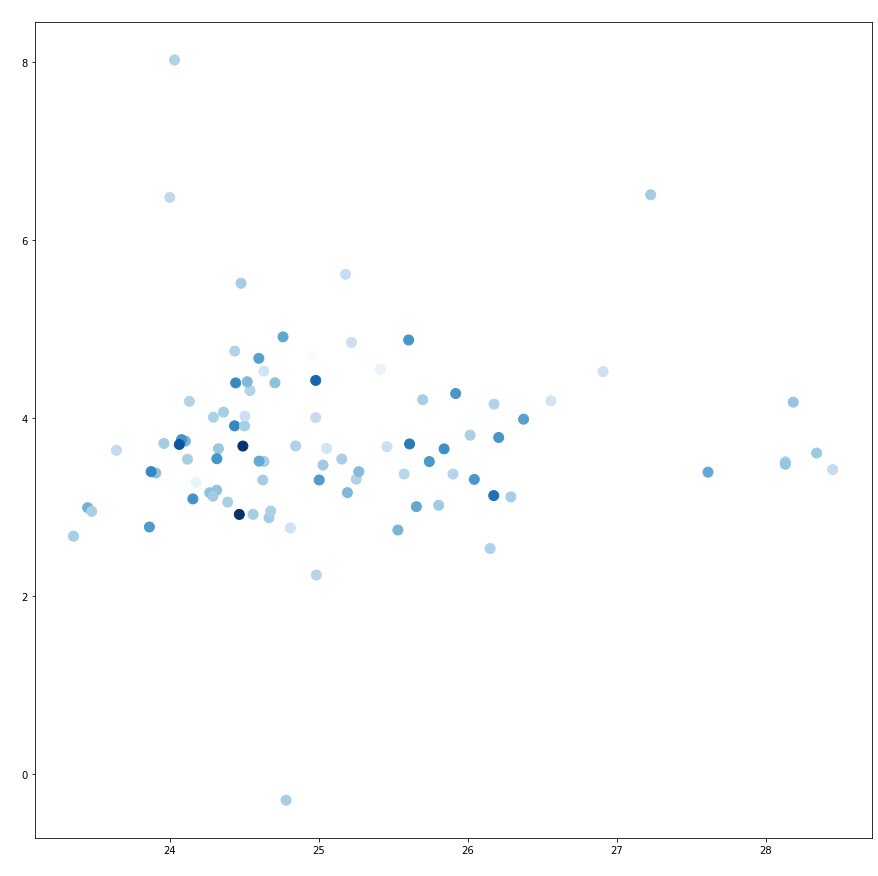

In [31]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.scatter(lossdf["Average MktCap"],lossdf["Average P/E"],c = lossdf["Reduction"],cmap="Blues",s = 100)
plt.xlabel("Market Cap",c="white")
plt.ylabel("P/E Ratio",c="white")
plt.title("Decrease in Loss",loc="left",c="white")
plt.show()

In [32]:
lossdf["Reduction"].describe(percentiles = [0.1+0.1*i for i in range(9)])

count    91.000000
mean      0.022197
std       0.051175
min      -0.092929
10%      -0.033072
20%      -0.010305
30%      -0.001805
40%       0.003472
50%       0.006910
60%       0.017581
70%       0.037518
80%       0.069867
90%       0.082467
max       0.184940
Name: Reduction, dtype: float64

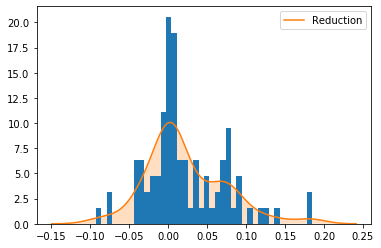

In [33]:
plt.hist(lossdf["Reduction"],density=True,bins=40)
sns.kdeplot(lossdf["Reduction"],shade=True)
plt.show()